<a href="https://colab.research.google.com/github/hzoscar/ds_challenge_3/blob/main/challenge_3_esencia_del_cliente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                                **Esencia del cliente**

En este desafio que corresponde al **tercer desafío (parte-1) del Bootcamp de Ciencia de Datos de Alura LATAM** se explora el comportamiento de los clientes de una cadena de supermercados. El objetivo es mejorar la experiencia de compra de los clientes a través de diferentes análisis para encontrar los patrones de compra de los clientes, identificando sus preferencias y hábitos, y utilizando esta información para ofrecerles un servicio personalizado y adaptado a sus necesidades. A tal fin se userá el **metodo k-means para realizar la clusterización de los clientes**.

El desafio esta dividido en **6 partes**:

**1. Preparando el ambiente:**  En la primera parte se prepara el ambiente de trabajo y se importa la base de datos con la cual se trabajará.

**2. Exploración de datos:** En la segunda parte se hace una exploración de datos dividiendo las variables del dataset en 4 grupos: variables del consumidor(consumer_columns), variables de los productos (products_columns), variables de las tiendas (stores_columns), y finalmente, las variables geográficas (geographic_columns) aunque estas ultimas no fueran consideradas en el análisis.

**3. Preprocesamiento y Obtención de Features:** En esta parte se crean las funciones que se utilizarán para los análisis posteriores y se escogen y se transforman, si es necesario, las variables más relevantes para ser usadas en el modelo de clusterización.

***En este file solo comparto el modelo final, el cual fue el fruto de un sin número de tests***. Las variables a considerar fueron las siguientes 6:

1. **ingreso_anual** (en la cual realicé una transformación)
2. **escolaridad** (la convertí en una variable ordinal)
3. **bebidas** (variable dummy obtenida del one_hot_encoder de la variable tipo)
4. **comida** (variable dummy obtenida del one_hot_encoder de la variable tipo)
5. **no comestibles** (variable dummy obtenida del one_hot_encoder de la variable tipo)
6. **bajo en grasa** (variable dummy)

**4. Clasterizacion y validación:** A través del método kmeans y seguiendo los lineamentos requeridos (El puntaje mínimo de Silhouette debe ser de 0.50; el de Davies-Bouldin máximo de 0.75; y el de CalinskiHarabasz, el número más alto posible.) se conclude que con las variables anteriormente escogídas **el mejor número de clusters es 7**!

Posteriormente se realiza una validación de la estructura y de la estabilidad de los clusters.

**5. Descripción de los clusters:** Se genera una serie de recomendaciones de estrategias para personalizar la experiencia de los clientes en cada uno de los clusters.

**6. Bonus - KPrototypes:** Finalmente, se realiza la clasterización del dataset objetivo "X" a través del método KPrototypes y se realiza el gráfico del codo.  

El dataset con el cual se trabaja se encuentra en kaggle: https://www.kaggle.com/datasets/ramjasmaurya/medias-cost-prediction-in-foodmart



---


# 1. Preparando el ambiente

---







## 1.1 Instalando e importando librerias



---



In [1]:
# Al final se realiza una comparación del modelo Kmeans con un modelo kprototypes.
# Para realiar dicha comparación es necesario importar kmodes
!pip install kmodes

In [2]:
#Instalar yellowbrick para visualizar el análisis de los clusters
!pip install yellowbrick

In [3]:
# Importando las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn import datasets
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import warnings
warnings.filterwarnings("ignore")

## 1.2 Importando la base de datos y data pre-processing


---



In [4]:
# Se hace la conexión a mi google coolab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Este es el file csv descargado de kaggle.
df_raw = pd.read_csv('/content/drive/MyDrive/data science/boot camp - data science - ALURA/challenge_3_esencia_del_cliente/media prediction and its cost.csv')

In [6]:
df_raw.head()

food_category food_department food_family  store_sales(in millions)  \
0  Breakfast Foods    Frozen Foods        Food                      7.36   
1  Breakfast Foods    Frozen Foods        Food                      5.52   
2  Breakfast Foods    Frozen Foods        Food                      3.68   
3  Breakfast Foods    Frozen Foods        Food                      3.68   
4  Breakfast Foods    Frozen Foods        Food                      4.08   

   store_cost(in millions)  unit_sales(in millions)         promotion_name  \
0                   2.7232                      4.0           Bag Stuffers   
1                   2.5944                      3.0  Cash Register Lottery   
2                   1.3616                      2.0    High Roller Savings   
3                   1.1776                      2.0  Cash Register Lottery   
4                   1.4280                      3.0       Double Down Sale   

  sales_country marital_status gender  ...  grocery_sqft frozen_sqft  \
0           USA              M      F  ...       18670.0      5415.0   
1           USA              M      M  ...       18670.0      5415.0   
2           USA              S      F  ...       18670.0      5415.0   
3           USA              M      F  ...       18670.0      5415.0   
4           USA              M      M  ...       18670.0      5415.0   

  meat_sqft coffee_bar video_store  salad_bar prepared_food  florist  \
0    3610.0        1.0         1.0        1.0           1.0      1.0   
1    3610.0        1.0         1.0        1.0           1.0      1.0   
2    3610.0        1.0         1.0        1.0           1.0      1.0   
3    3610.0        1.0         1.0        1.0           1.0      1.0   
4    3610.0        1.0         1.0        1.0           1.0      1.0   

           media_type    cost  
0  Daily Paper, Radio  126.62  
1  Daily Paper, Radio   59.86  
2  Daily Paper, Radio   84.16  
3     In-Store Coupon   95.78  
4               Radio   50.79  

[5 rows x 40 columns]

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60428 entries, 0 to 60427
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   food_category               60428 non-null  object 
 1   food_department             60428 non-null  object 
 2   food_family                 60428 non-null  object 
 3   store_sales(in millions)    60428 non-null  float64
 4   store_cost(in millions)     60428 non-null  float64
 5   unit_sales(in millions)     60428 non-null  float64
 6   promotion_name              60428 non-null  object 
 7   sales_country               60428 non-null  object 
 8   marital_status              60428 non-null  object 
 9   gender                      60428 non-null  object 
 10  total_children              60428 non-null  float64
 11  education                   60428 non-null  object 
 12  member_card                 60428 non-null  object 
 13  occupation                  604

In [8]:
# Noto qu hay dos columnas con un nombre similar. Reviso si el contenido entre las columnas coincide
(df_raw['avg_cars_at home(approx)']==df_raw['avg_cars_at home(approx).1']).unique()

array([ True])

In [9]:
# Al comprobar que hay una columna duplicada, elimino uno de las dos
df_raw.drop(columns='avg_cars_at home(approx).1',axis=1,inplace=True)

**Ahora se procede con la modificación del idioma de la base de datos. Se traducen los elementos del ingles al español.**

In [10]:
#Primer se renombran las columnas
df_raw.rename(columns={
    'food_category': 'categoria_alimento',
    'food_department': 'departamento',
    'food_family': 'tipo',
    'store_sales(in millions)': 'ventas_tienda(en millones)',
    'store_cost(in millions)': 'costo_tienda(en millones)',
    'unit_sales(in millions)': 'ventas_unitarias(en millones)',
    'promotion_name': 'promocion',
    'sales_country': 'pais',
    'marital_status': 'estado_civil',
    'gender': 'genero',
    'total_children': 'total_de_hijos',
    'education': 'escolaridad',
    'member_card': 'miembro',
    'occupation': 'ocupacion',
    'houseowner': 'vivienda_propia',
    'avg_cars_at home(approx)': 'promedio_autos(aprox)',
    'avg. yearly_income': 'ingreso_anual',
    'num_children_at_home': 'numero_hijos',
    'brand_name': 'marca',
    'SRP': 'precio_recomendado',
    'gross_weight': 'peso_bruto',
    'net_weight': 'peso_neto',
    'recyclable_package': 'empaque_reciclable',
    'low_fat': 'bajo_en_grasa',
    'units_per_case': 'unidades_por_caja',
    'store_type': 'comercio',
    'store_city': 'ciudad',
    'store_state': 'estado',
    'store_sqft': 'pies_cuadrados_tienda',
    'grocery_sqft': 'pies_cuadrados_comestibles',
    'frozen_sqft': 'pies_cuadrados_congelados',
    'meat_sqft': 'pies_cuadrados_carne',
    'coffee_bar': 'cafeteria',
    'video_store': 'tienda_de_videos',
    'salad_bar': 'barra_de_ensaladas',
    'prepared_food': 'comida_preparada',
    'florist': 'floristeria',
    'media_type': 'divulgacion',
    'cost': 'costo'
},inplace=True)

In [11]:
# Ahora se traducen los valores del dataset escritos en ingles
categoria_alimento = {
    'Vegetables': 'Vegetales',
    'Snack Foods': 'Alimentos para picar',
    'Dairy': 'Productos lácteos',
    'Meat': 'Carne',
    'Fruit': 'Fruta',
    'Jams and Jellies': 'Mermeladas y jaleas',
    'Baking Goods': 'Productos para hornear',
    'Breakfast Foods': 'Alimentos para el desayuno',
    'Bread': 'Pan',
    'Canned Soup': 'Sopa enlatada',
    'Beer and Wine': 'Cerveza y vino',
    'Paper Products': 'Productos de papel',
    'Bathroom Products': 'Productos de baño',
    'Electrical': 'Eléctrico',
    'Candy': 'Dulces',
    'Frozen Desserts': 'Postres congelados',
    'Specialty': 'Especialidades',
    'Starchy Foods': 'Alimentos ricos en almidón',
    'Magazines': 'Revistas',
    'Kitchen Products': 'Productos de cocina',
    'Eggs': 'Huevos',
    'Hot Beverages': 'Bebidas calientes',
    'Hygiene': 'Higiene',
    'Pain Relievers': 'Analgésicos',
    'Pizza': 'Pizza',
    'Carbonated Beverages': 'Bebidas carbonatadas',
    'Pure Juice Beverages': 'Bebidas de jugo puro',
    'Cleaning Supplies': 'Suministros de limpieza',
    'Side Dishes': 'Acompañamientos',
    'Frozen Entrees': 'Platos preparados congelados',
    'Drinks': 'Bebidas',
    'Plastic Products': 'Productos de plástico',
    'Hardware': 'Artículos de ferretería',
    'Cold Remedies': 'Remedios para el resfriado',
    'Decongestants': 'Descongestionantes',
    'Canned Tuna': 'Atún enlatado',
    'Seafood': 'Mariscos',
    'Canned Anchovies': 'Anchoas enlatadas',
    'Canned Clams': 'Almejas enlatadas',
    'Candles': 'Velas',
    'Miscellaneous': 'Misceláneos',
    'Canned Oysters': 'Ostras enlatadas',
    'Canned Shrimp': 'Camarones enlatados',
    'Packaged Vegetables': 'Vegetales envasados',
    'Canned Sardines': 'Sardinas enlatadas'
}

departamento = {
    'Produce': 'Productos frescos',
    'Snack Foods': 'Alimentos para picar',
    'Household': 'Artículos para el hogar',
    'Frozen Foods': 'Alimentos congelados',
    'Baking Goods': 'Productos para hornear',
    'Canned Foods': 'Alimentos enlatados',
    'Dairy': 'Productos lácteos',
    'Health and Hygiene': 'Salud e higiene',
    'Beverages': 'Bebidas',
    'Deli': 'Charcutería',
    'Baked Goods': 'Productos horneados',
    'Alcoholic Beverages': 'Bebidas alcohólicas',
    'Snacks': 'Snacks',
    'Starchy Foods': 'Alimentos ricos en almidón',
    'Periodicals': 'Publicaciones periódicas',
    'Eggs': 'Huevos',
    'Breakfast Foods': 'Alimentos para el desayuno',
    'Canned Products': 'Productos enlatados',
    'Checkout': 'Caja de salida',
    'Meat': 'Carne',
    'Seafood': 'Mariscos',
    'Carousel': 'Carrusel'
}

tipo= {'Food':'Comida', 'Non-Consumable':'No comestible', 'Drink':'Bebida'}

promocion = {
    'Weekend Markdown': 'Descuento de fin de semana',
    'Two Day Sale': 'Venta de dos días',
    'Price Savers': 'Ahorro de precios',
    'Price Winners': 'Ganadores de precios',
    'Save-It Sale': 'Venta Ahorra Ya',
    'Super Duper Savers': 'Super Ahorradores',
    'Super Savers': 'Super Ahorro',
    'One Day Sale': 'Venta de un día',
    'Double Down Sale': 'Venta Doble',
    'High Roller Savings': 'Ahorro para apostadores grandes',
    'Green Light Days': 'Días de luz verde',
    'Shelf Clearing Days': 'Días de liquidación de estanterías',
    'Price Slashers': 'Rebajadores de precios',
    'Free For All': 'Gratis para todos',
    'Cash Register Lottery': 'Lotería de la caja registradora',
    'Go For It': 'Adelante',
    'Two for One': 'Dos por uno',
    'Money Savers': 'Ahorradores de dinero',
    'Big Time Discounts': 'Descuentos de gran magnitud',
    'Price Destroyers': 'Destructores de precios',
    'Saving Days': 'Días de ahorro',
    'Dollar Cutters': 'Recortadores de dólares',
    'Unbeatable Price Savers': 'Ahorro de precios imbatible',
    'Sales Galore': 'Promociones por montones',
    'Big Promo': 'Gran promoción',
    'Dimes Off': 'Más barato',
    'Sales Days': 'Días de venta',
    'Price Cutters': 'Rebajando precios',
    'You Save Days': 'Días de ahorro',
    'Savings Galore': 'Ahorros por montones',
    'Bag Stuffers': 'Bolsas llenas',
    'Three for One': 'Tres por uno',
    'I Cant Believe It Sale': 'Venta No Puedo Creerlo',
    'Sale Winners': 'Ganadores de ventas',
    'Pick Your Savings': 'Elige tus ahorros',
    'Bye Bye Baby': 'Adiós bebé',
    'Best Savings': 'Mejores ahorros',
    'Tip Top Savings': 'Ahorro de primera clase',
    'Shelf Emptiers': 'Estantes vacíos',
    'Big Time Savings': 'Ahorro Enorme',
    'Wallet Savers': 'Ahorradores de billetera',
    'Dollar Days': 'Días de dólar',
    'Mystery Sale': 'Venta misteriosa',
    'Price Smashers': 'Aplastadores de precios',
    'Green Light Special': 'Especial luz verde',
    'Coupon Spectacular': 'Espectacular de cupones',
    'Super Wallet Savers': 'Super ahorradores de billetera',
    'Double Your Savings': 'Duplica tus ahorros',
    'Fantastic Discounts': 'Descuentos fantásticos'
}

escolaridad = {
    'Partial High School':'Primaria',
    'High School Degree':'Secundaria',
    'Bachelors Degree':'Superior',
    'Partial College':'Técnico',
    'Graduate Degree':'Maestría'
}

miembro = {
    'Bronze':'Bronce',
    'Golden': 'Oro',
    'Silver':'Plata'
}

ocupacion = {
    'Professional':'Profesional',
    'Skilled Manual':'Técnico',
    'Manual':'Obrero',
    'Management':'Gestión',
    'Clerical':'Cargo de Oficina'
}

pais = {
    'USA':'Estados Unidos',
    'Mexico':'México',
    'Canada':'Canadá'
}

estado_civil = {
    'S':'Soltero', 'M':'Casado'
}

genero ={
    'F':'Femenino',
    'M':'Masculino'
}

vivienda_propia={'Y':'Sí', 'N':'No'}

ingreso_anual={
    '$30K - $50K':40000,
    '$10K - $30K':20000,
    '$50K - $70K':60000,
    '$70K - $90K':80000,
    '$130K - $150K':140000,
    '$90K - $110K':100000,
    '$110K - $130K':120000,
    '$150K +':160000
}



comercio = {
    'Supermarket': 'Supermercado',
    'Deluxe Supermarket': 'Supermercado de lujo',
    'Gourmet Supermarket': 'Supermercado gourmet',
    'Mid-Size Grocery': 'Supermercado mediano',
    'Small Grocery': 'Pequeño supermercado'
}


divulgacion = {
    'Daily Paper, Radio': 'Periódico diario, radio',
    'Product Attachment': 'Anexo del producto',
    'Daily Paper, Radio, TV': 'Periódico diario, radio, televisión',
    'Daily Paper': 'Periódico diario',
    'Street Handout': 'Panfletos',
    'Radio': 'Radio',
    'Sunday Paper': 'Periódico dominical',
    'In-Store Coupon': 'Cupón en la tienda',
    'Sunday Paper, Radio': 'Periódico dominical, radio',
    'Cash Register Handout': 'Entrega en el punto de venta',
    'TV': 'Televisión',
    'Bulk Mail': 'Correo masivo',
    'Sunday Paper, Radio, TV': 'Periódico dominical, radio, televisión'
}

In [12]:
dict_map = [categoria_alimento, departamento, tipo, promocion, escolaridad, miembro, ocupacion,
            pais, estado_civil, genero, vivienda_propia, ingreso_anual, comercio, divulgacion]
columns_to_map = ['categoria_alimento', 'departamento', 'tipo', 'promocion', 'escolaridad', 'miembro', 'ocupacion',
                  'pais', 'estado_civil', 'genero', 'vivienda_propia', 'ingreso_anual', 'comercio', 'divulgacion']
final_dict = dict(zip(columns_to_map,dict_map))

In [13]:
for key in final_dict:
  df_raw[key]=df_raw[key].map(final_dict[key])

df_raw.head()

categoria_alimento          departamento    tipo  \
0  Alimentos para el desayuno  Alimentos congelados  Comida   
1  Alimentos para el desayuno  Alimentos congelados  Comida   
2  Alimentos para el desayuno  Alimentos congelados  Comida   
3  Alimentos para el desayuno  Alimentos congelados  Comida   
4  Alimentos para el desayuno  Alimentos congelados  Comida   

   ventas_tienda(en millones)  costo_tienda(en millones)  \
0                        7.36                     2.7232   
1                        5.52                     2.5944   
2                        3.68                     1.3616   
3                        3.68                     1.1776   
4                        4.08                     1.4280   

   ventas_unitarias(en millones)                        promocion  \
0                            4.0                    Bolsas llenas   
1                            3.0  Lotería de la caja registradora   
2                            2.0  Ahorro para apostadores grandes   
3                            2.0  Lotería de la caja registradora   
4                            3.0                      Venta Doble   

             pais estado_civil     genero  ...  pies_cuadrados_comestibles  \
0  Estados Unidos       Casado   Femenino  ...                     18670.0   
1  Estados Unidos       Casado  Masculino  ...                     18670.0   
2  Estados Unidos      Soltero   Femenino  ...                     18670.0   
3  Estados Unidos       Casado   Femenino  ...                     18670.0   
4  Estados Unidos       Casado  Masculino  ...                     18670.0   

  pies_cuadrados_congelados pies_cuadrados_carne cafeteria tienda_de_videos  \
0                    5415.0               3610.0       1.0              1.0   
1                    5415.0               3610.0       1.0              1.0   
2                    5415.0               3610.0       1.0              1.0   
3                    5415.0               3610.0       1.0              1.0   
4                    5415.0               3610.0       1.0              1.0   

   barra_de_ensaladas  comida_preparada  floristeria              divulgacion  \
0                 1.0               1.0          1.0  Periódico diario, radio   
1                 1.0               1.0          1.0  Periódico diario, radio   
2                 1.0               1.0          1.0  Periódico diario, radio   
3                 1.0               1.0          1.0       Cupón en la tienda   
4                 1.0               1.0          1.0                    Radio   

    costo  
0  126.62  
1   59.86  
2   84.16  
3   95.78  
4   50.79  

[5 rows x 39 columns]

In [14]:
df_raw.to_csv('/content/drive/MyDrive/data science/boot camp - data science - ALURA/challenge_3_esencia_del_cliente/universal_food_spanish.csv')

In [15]:
# Leer el archivo CSV y cargar los datos en un DataFrame
df = pd.read_csv('/content/drive/MyDrive/data science/boot camp - data science - ALURA/challenge_3_esencia_del_cliente/universal_food_spanish.csv')
# Ahora, 'df' contiene los datos del archivo CSV y se puede utilizar para realizar análisis y manipulación de datos.

In [16]:
# Configurar pandas para mostrar todas las columnas en la salida
pd.set_option('display.max_columns', None)
# Mostrar las primeras 5 filas del DataFrame 'df'
df.head()

Unnamed: 0          categoria_alimento          departamento    tipo  \
0           0  Alimentos para el desayuno  Alimentos congelados  Comida   
1           1  Alimentos para el desayuno  Alimentos congelados  Comida   
2           2  Alimentos para el desayuno  Alimentos congelados  Comida   
3           3  Alimentos para el desayuno  Alimentos congelados  Comida   
4           4  Alimentos para el desayuno  Alimentos congelados  Comida   

   ventas_tienda(en millones)  costo_tienda(en millones)  \
0                        7.36                     2.7232   
1                        5.52                     2.5944   
2                        3.68                     1.3616   
3                        3.68                     1.1776   
4                        4.08                     1.4280   

   ventas_unitarias(en millones)                        promocion  \
0                            4.0                    Bolsas llenas   
1                            3.0  Lotería de la caja registradora   
2                            2.0  Ahorro para apostadores grandes   
3                            2.0  Lotería de la caja registradora   
4                            3.0                      Venta Doble   

             pais estado_civil     genero  total_de_hijos escolaridad miembro  \
0  Estados Unidos       Casado   Femenino             1.0    Primaria     NaN   
1  Estados Unidos       Casado  Masculino             0.0    Superior   Plata   
2  Estados Unidos      Soltero   Femenino             4.0    Primaria     NaN   
3  Estados Unidos       Casado   Femenino             2.0  Secundaria  Bronce   
4  Estados Unidos       Casado  Masculino             0.0    Primaria  Bronce   

     ocupacion vivienda_propia  promedio_autos(aprox)  ingreso_anual  \
0      Técnico              Sí                    1.0          20000   
1  Profesional              Sí                    4.0          60000   
2       Obrero              No                    1.0          20000   
3       Obrero              Sí                    2.0          40000   
4      Técnico              No                    2.0          40000   

   numero_hijos       marca  precio_recomendado  peso_bruto  peso_neto  \
0           1.0  Carrington                1.84       19.70      17.70   
1           0.0  Carrington                1.84       19.70      17.70   
2           0.0  Carrington                1.84       19.70      17.70   
3           2.0  Carrington                1.84       19.70      17.70   
4           0.0      Golden                1.36        7.12       5.11   

   empaque_reciclable  bajo_en_grasa  unidades_por_caja              comercio  \
0                 1.0            0.0               17.0  Supermercado de lujo   
1                 1.0            0.0               17.0  Supermercado de lujo   
2                 1.0            0.0               17.0  Supermercado de lujo   
3                 1.0            0.0               17.0  Supermercado de lujo   
4                 0.0            1.0               29.0  Supermercado de lujo   

  ciudad estado  pies_cuadrados_tienda  pies_cuadrados_comestibles  \
0  Salem     OR                27694.0                     18670.0   
1  Salem     OR                27694.0                     18670.0   
2  Salem     OR                27694.0                     18670.0   
3  Salem     OR                27694.0                     18670.0   
4  Salem     OR                27694.0                     18670.0   

   pies_cuadrados_congelados  pies_cuadrados_carne  cafeteria  \
0                     5415.0                3610.0        1.0   
1                     5415.0                3610.0        1.0   
2                     5415.0                3610.0        1.0   
3                     5415.0                3610.0        1.0   
4                     5415.0                3610.0        1.0   

   tienda_de_videos  barra_de_ensaladas  comida_preparada  floristeria  \
0               1.0                 1.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60428 entries, 0 to 60427
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     60428 non-null  int64  
 1   categoria_alimento             60428 non-null  object 
 2   departamento                   60428 non-null  object 
 3   tipo                           60428 non-null  object 
 4   ventas_tienda(en millones)     60428 non-null  float64
 5   costo_tienda(en millones)      60428 non-null  float64
 6   ventas_unitarias(en millones)  60428 non-null  float64
 7   promocion                      60428 non-null  object 
 8   pais                           60428 non-null  object 
 9   estado_civil                   60428 non-null  object 
 10  genero                         60428 non-null  object 
 11  total_de_hijos                 60428 non-null  float64
 12  escolaridad                    60428 non-null 

In [18]:
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

**Comentario:** El dataset que será objeto de estudio tiene 39 columnas (la primera se añadió durante la imprtación de los datos) y 60429 filas (registro de clientes)

### 1.2.1 valores nulos


---



In [19]:
## Calcular la cantidad de valores nulos (NaN) en cada columna del DataFrame 'df'
df.isna().sum()

categoria_alimento                   0
departamento                         0
tipo                                 0
ventas_tienda(en millones)           0
costo_tienda(en millones)            0
ventas_unitarias(en millones)        0
promocion                            0
pais                                 0
estado_civil                         0
genero                               0
total_de_hijos                       0
escolaridad                          0
miembro                          13867
ocupacion                            0
vivienda_propia                      0
promedio_autos(aprox)                0
ingreso_anual                        0
numero_hijos                         0
marca                                0
precio_recomendado                   0
peso_bruto                           0
peso_neto                            0
empaque_reciclable                   0
bajo_en_grasa                        0
unidades_por_caja                    0
comercio                 

**Comentario:** La columna "miembro" que da a conocer el tipo de membresía que tienen lo clientes con esta cadena de supermercados tiene 13867 valores nulos. Se hará una imputación de dichos valores si se considera que esa variable es relavante para el modelo de clusterización.

### 1.2.2 Columnas duplicadas?


---



<Axes: >

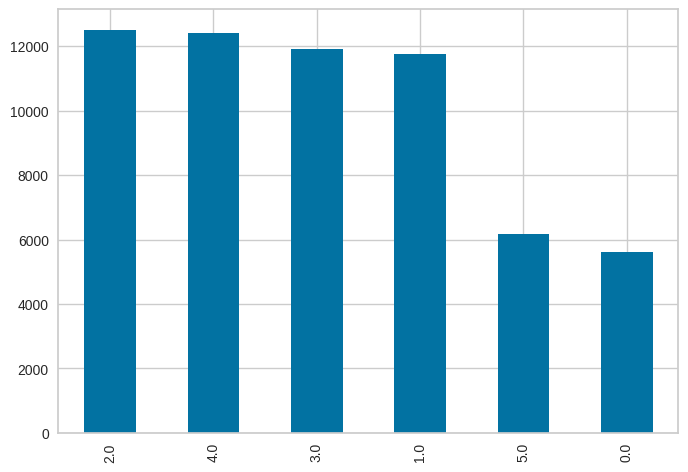

In [20]:
df.total_de_hijos.value_counts().plot(kind='bar')

<Axes: >

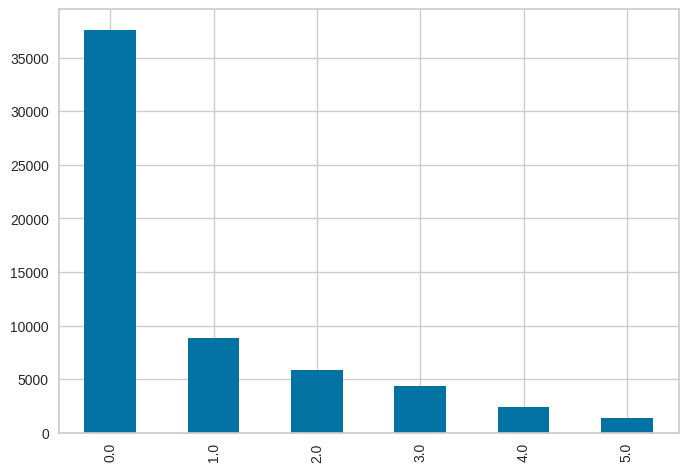

In [21]:
df.numero_hijos.value_counts().plot(kind='bar')

**Comentario:** Hay 2 columnas que tienen información sobre el número de hijos que tiene un cliente. Como fue mencionado anteriormente, se considerará la variable que sea relavante para el modelo de clusterización.



---


# 2. Exploración de los datos


---



In [22]:
# Obtener la lista de nombres de las columnas del DataFrame 'df'
df.columns

Index(['categoria_alimento', 'departamento', 'tipo',
       'ventas_tienda(en millones)', 'costo_tienda(en millones)',
       'ventas_unitarias(en millones)', 'promocion', 'pais', 'estado_civil',
       'genero', 'total_de_hijos', 'escolaridad', 'miembro', 'ocupacion',
       'vivienda_propia', 'promedio_autos(aprox)', 'ingreso_anual',
       'numero_hijos', 'marca', 'precio_recomendado', 'peso_bruto',
       'peso_neto', 'empaque_reciclable', 'bajo_en_grasa', 'unidades_por_caja',
       'comercio', 'ciudad', 'estado', 'pies_cuadrados_tienda',
       'pies_cuadrados_comestibles', 'pies_cuadrados_congelados',
       'pies_cuadrados_carne', 'cafeteria', 'tienda_de_videos',
       'barra_de_ensaladas', 'comida_preparada', 'floristeria', 'divulgacion',
       'costo'],
      dtype='object')

In [23]:
# Este bucle itera a través de cada columna en el DataFrame 'df'.
# En cada iteración, imprime información sobre la columna, incluyendo su nombre y la cantidad de valores únicos que contiene.
# Esto permite hacerse una idea del tipo de variables que contiene el dataset (numericas, categoricas y/o binarias)
for column in df.columns:
  print(f'columna: {column}, unique: {len(df[column].unique())}')

columna: categoria_alimento, unique: 45
columna: departamento, unique: 22
columna: tipo, unique: 3
columna: ventas_tienda(en millones), unique: 1033
columna: costo_tienda(en millones), unique: 9919
columna: ventas_unitarias(en millones), unique: 6
columna: promocion, unique: 48
columna: pais, unique: 3
columna: estado_civil, unique: 2
columna: genero, unique: 2
columna: total_de_hijos, unique: 6
columna: escolaridad, unique: 5
columna: miembro, unique: 4
columna: ocupacion, unique: 5
columna: vivienda_propia, unique: 2
columna: promedio_autos(aprox), unique: 5
columna: ingreso_anual, unique: 8
columna: numero_hijos, unique: 6
columna: marca, unique: 111
columna: precio_recomendado, unique: 315
columna: peso_bruto, unique: 376
columna: peso_neto, unique: 332
columna: empaque_reciclable, unique: 2
columna: bajo_en_grasa, unique: 2
columna: unidades_por_caja, unique: 36
columna: comercio, unique: 5
columna: ciudad, unique: 19
columna: estado, unique: 10
columna: pies_cuadrados_tienda, uni

**Comentario importante:** Aquí se realiza el **primer filtro** de las variables que se considerarán en el proyecto.


**1.** Dado que el objetivo es el de agrupar los clientes teniendo en cuenta sus características y preferencias, todos los nombres de las variables (columnas) que contienen dicha información son guardados en la lista **"customer_columns"**.


**2.** En cambio, los nombres de las variables que brindan información sobre los productos consumidos por los clientes se guardaron en la lista **"products_columns"**. Se excluyeron las variables que no se consideran relevantes para el modelo.


**3.** Los nombres de las variables que brindan información sobre las características de los supermercados en los cuales los clientes realizan sus compras se guardaron en la lista **"stores_columns"**. Se excluyeron las variables que no se consideran relevantes para el modelo.


**4.** Finalmente, Los nombres de las variables que brindan información sobre la posición geográfica de los clientes se guardaron en la lista **"geographic_columns"**. Se excluyeron las variables que no se consideran relevantes para el modelo.

In [40]:
customer_columns=['estado_civil',
       'genero', 'escolaridad', 'miembro', 'ocupacion', 'vivienda_propia',
       'promedio_autos(aprox)', 'ingreso_anual', 'total_de_hijos','numero_hijos']

In [25]:
products_columns=['categoria_alimento', 'departamento', 'tipo','promocion','marca','empaque_reciclable',
       'bajo_en_grasa', 'unidades_por_caja','precio_recomendado']

In [26]:
stores_columns=['ventas_unitarias(en millones)','comercio','pies_cuadrados_tienda', 'pies_cuadrados_comestibles',
       'pies_cuadrados_congelados', 'pies_cuadrados_carne', 'cafeteria',
       'tienda_de_videos', 'barra_de_ensaladas', 'comida_preparada',
       'floristeria', 'divulgacion']

In [27]:
geographic_columns=['pais','ciudad','estado']

In [89]:
# Este función llamada "plot_porcentajes" que toma el nombre de una columna,
# los datos y un color como argumentos para visualizar el conteo de los valores
# en esa columna, junto con los porcentajes correspondientes. El gráfico resultante
# es un gráfico de barras horizontales con etiquetas de porcentaje en la parte superior de cada barra.

def plot_porcentajes(columna,datos,color):
  plt.figure(figsize=(10,6))
  grafico = sns.countplot(x=columna,data=df, orient='h',color=color)
  grafico.set_ylabel('Conteo', fontsize=17)
  sns.set_style('darkgrid')

  sizes = []

  for p in grafico.patches:
    height = p.get_height()
    sizes.append(height)
    grafico.text(p.get_x()+p.get_width()/1.6, height+200, f'{round(height/len(datos)*100,2)}%', ha='center', va='bottom', fontsize = 12,rotation=90)
    grafico.set_title('Conteo variable ' + columna, weight='bold')
    grafico.set_xticklabels(grafico.get_xticklabels(),rotation=90)
  grafico.set_ylim(0,max(sizes)*1.1)

In [66]:
def plot_columns(data, columns, color='green', rows=3, cols=3,rotation=45):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 6*rows))
    fig.tight_layout(pad=8.0)

    # Iterate through columns and plot on subplots
    for i, column in enumerate(columns):
        row = i // cols
        col = i % cols

        grafico = sns.countplot(x=column,data=data ,orient='h', color=color, ax=axes[row, col])
        grafico.set_ylabel('Conteo', fontsize=17)

        sizes = []

        for p in grafico.patches:
            height = p.get_height()
            sizes.append(height)
            grafico.text(p.get_x()+p.get_width()/1.6, height+200, f'{round(height/len(data)*100,2)}%', ha='center', va='bottom', fontsize=12, rotation=rotation)
            grafico.set_title('Conteo variable ' + column, weight='bold', pad=20)
            grafico.set_xticklabels(grafico.get_xticklabels(), rotation=rotation)
        grafico.set_ylim(0, max(sizes)*1.1)

    plt.show()

In [29]:
# Esta función llamada categorical_crosstable que toma un conjunto de datos, una columna de referencia,
# un conjunto de columnas a analizar y un color para los mapas de calor. La función itera sobre las columnas en set_columns
# y crea un mapa de calor para cada tabla cruzada, mostrando la relación entre la columna de referencia y cada columna en set_columns.
# Cada mapa de calor se muestra individualmente.
def categorical_crosstable(data, reference_column, set_columns,color,annot):
  for column in set_columns:
    plt.figure(figsize=(10,6))
    figure =sns.heatmap(pd.crosstab(data[reference_column],data[column]), cmap=color, annot=annot, cbar=False, fmt='g')
    plt.show()

In [30]:
# Esta función llamada num_and_cat_boxplot toma un conjunto de datos, una lista de columnas categóricas,
# una columna numérica y un color para los boxplots. La función itera sobre las columnas categóricas
# en cat_columns y crea un boxplot para cada combinación de una columna categórica y una numérica.
# Cada boxplot se muestra individualmente.

def num_and_cat_boxplot(data,cat_columns,num_column,color):
  for column in cat_columns:
    plt.figure(figsize=(10,6))
    figure = sns.catplot(x=column, y=num_column, kind="box", data=data,color=color)
    plt.show()

# 2.1 Clientes


---



### 2.1.1 EDA


---



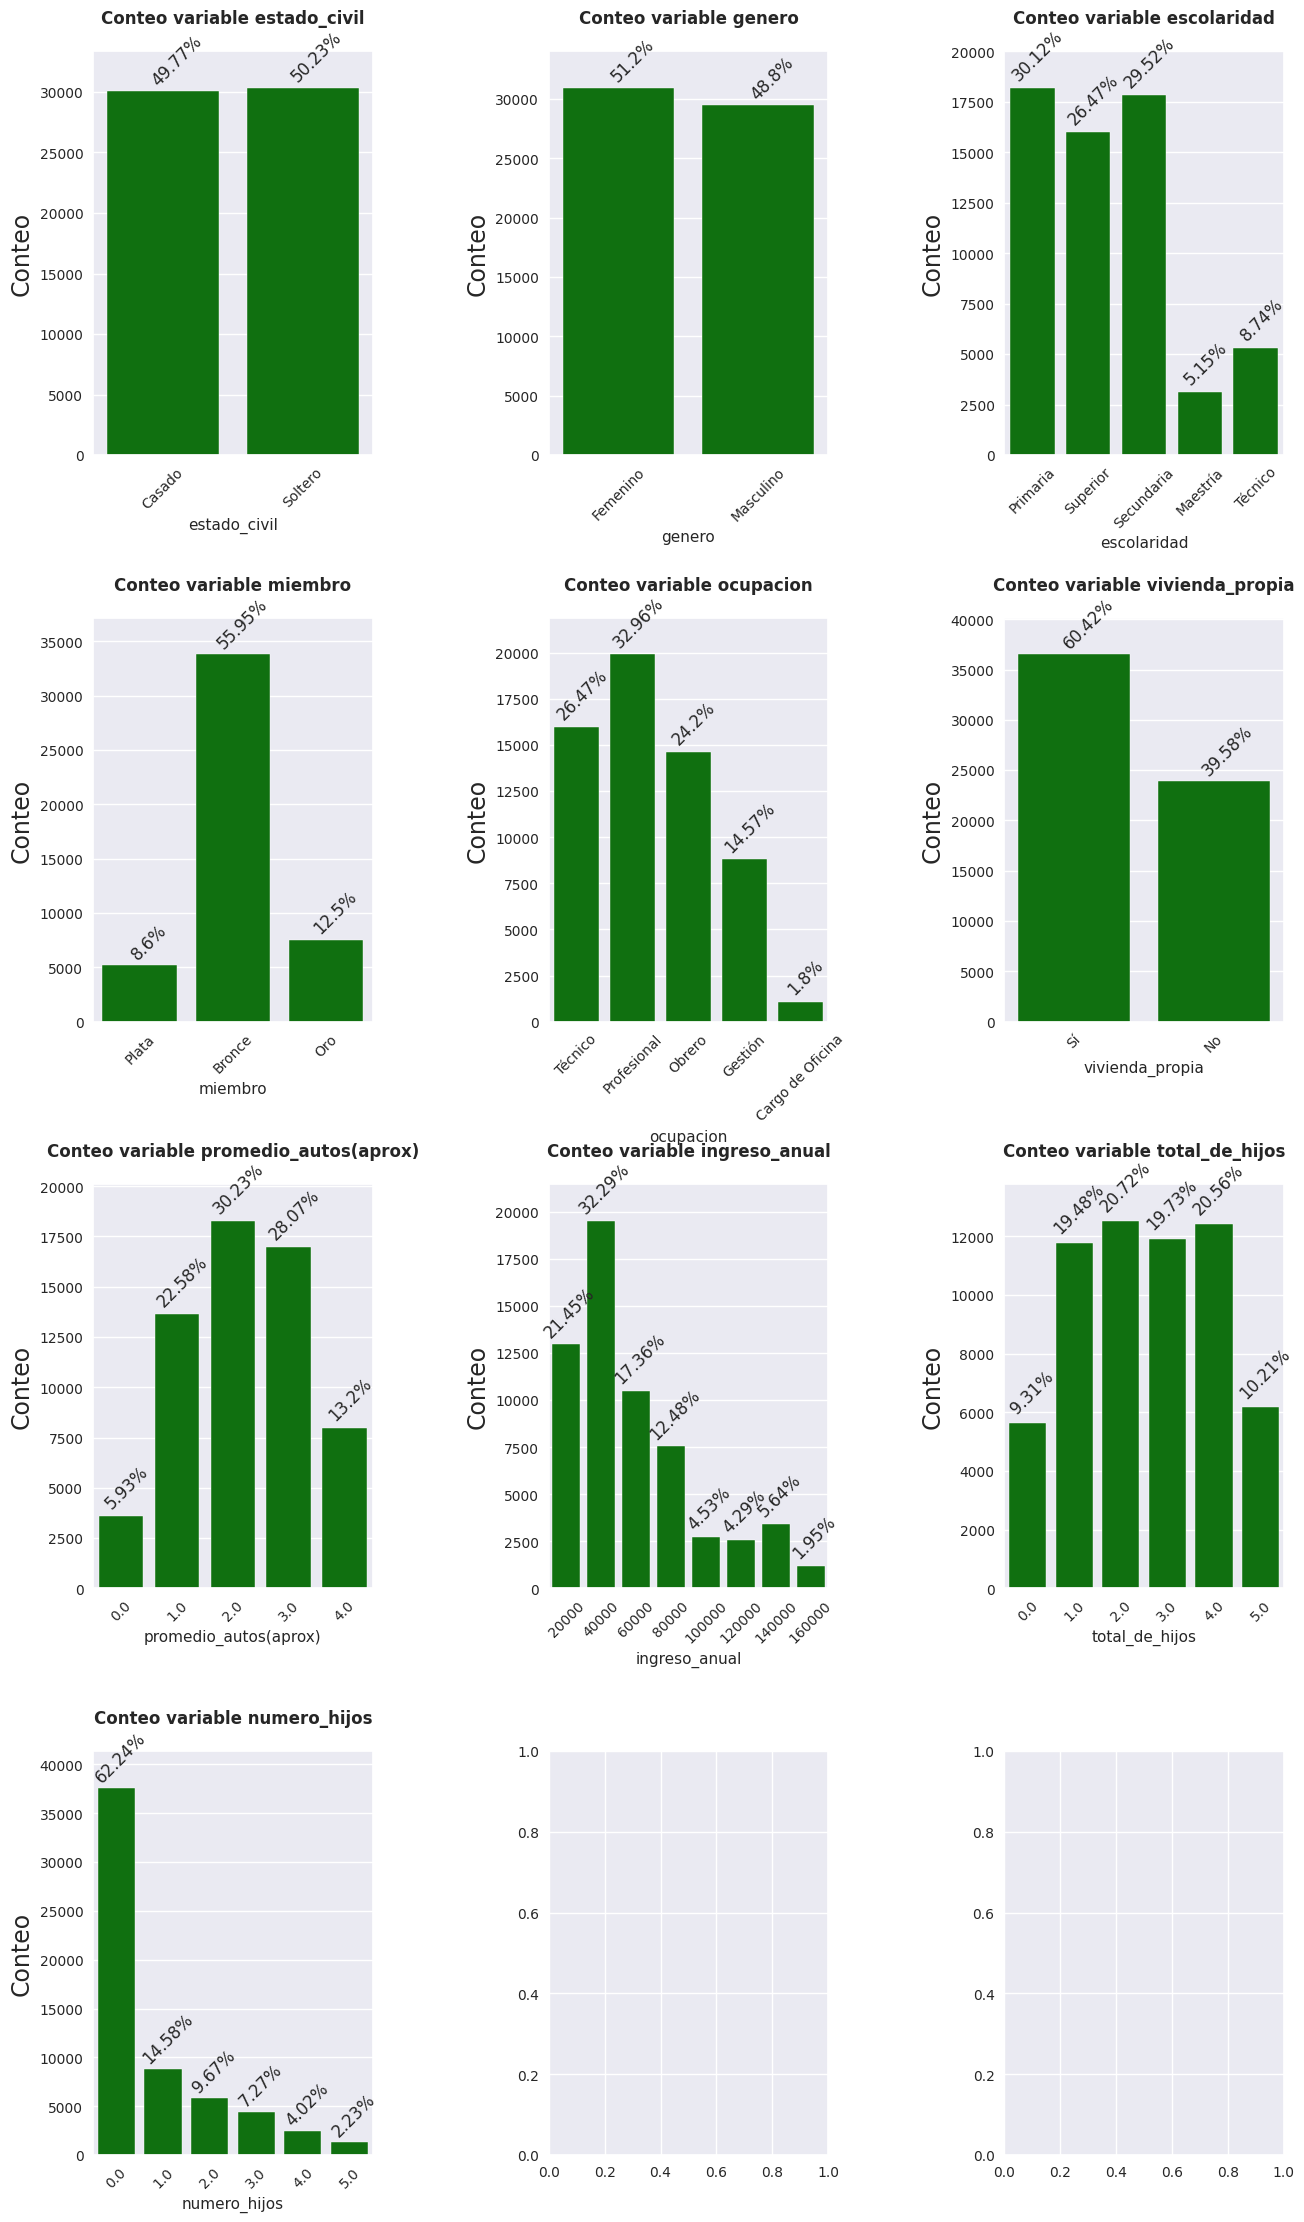

In [67]:
plot_columns(df, customer_columns, color='green', rows=4, cols=3,rotation=45)


**Comentario:** A grandes razgos se podría decir que nuestro cliente modelo, está en la membrecia bronce tiene casa propia y no tiene hijos o tiene entre 1 y 4 hijos. El grado de escolaridad no supera la educación superior (excluyendo el tecnico), tiene al menos un carro pero no más de 3 y sus ingresos no supera más de los $40.000. Del género y estado civil no se puede abstraer información relevante.

Dado que el poder adquisitivo de un cliente es principalmente definido por sus ingresos, el **análisis bivariado** se hacé en función a la variable **"ingreso_anual"**. Variable que será considerada como parte del modelo de clasterización

### 2.1.2 Analisis Bivariado (con respecto al nivel de ingresos)


---



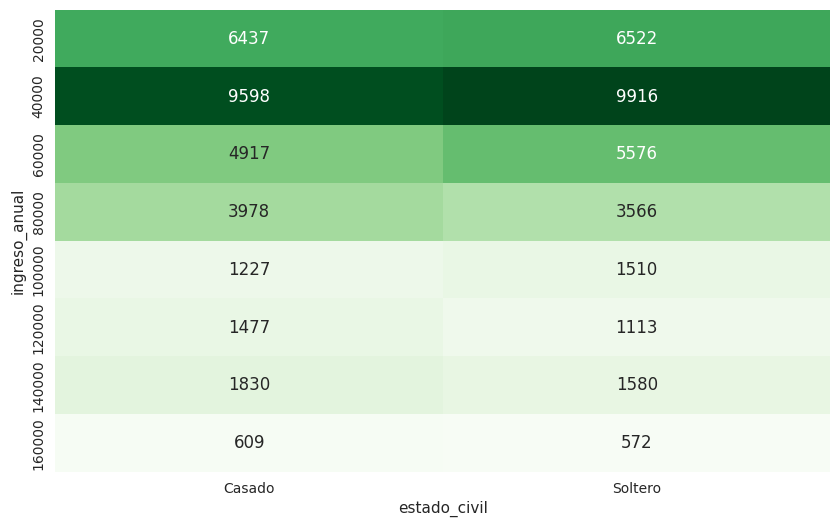

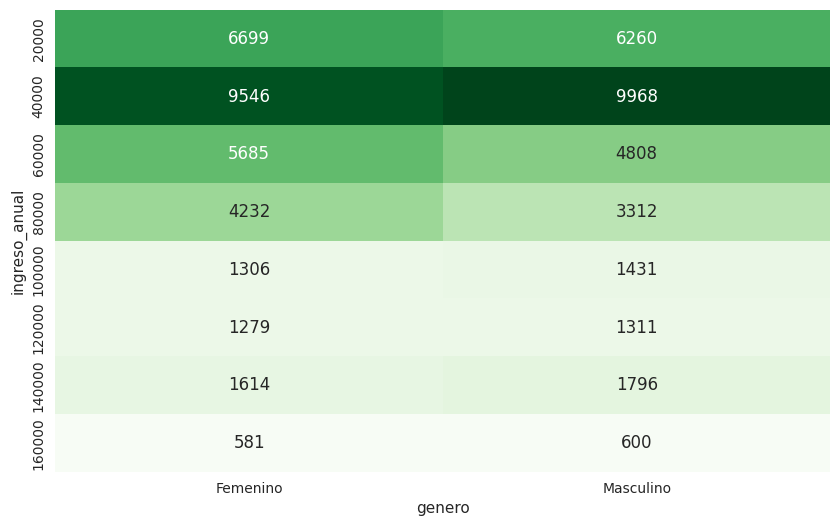

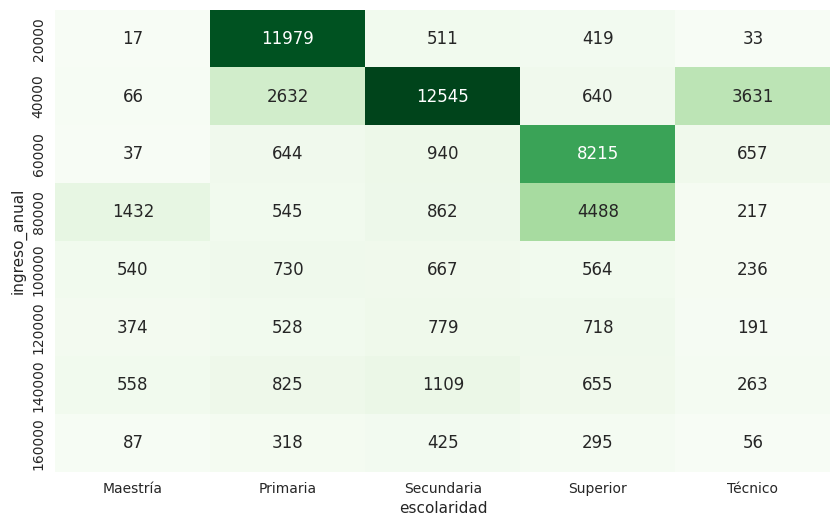

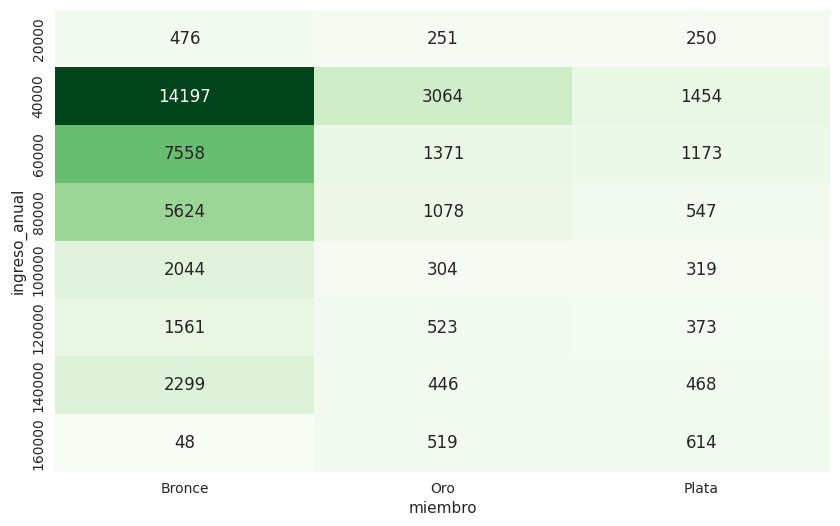

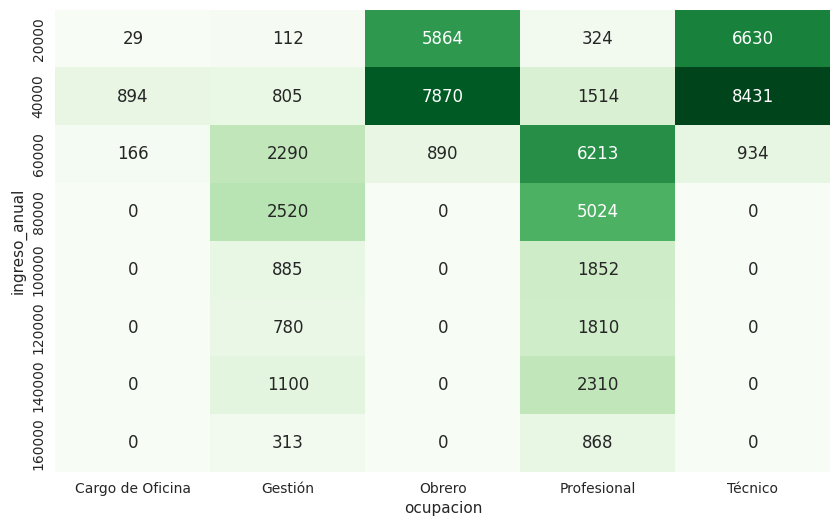

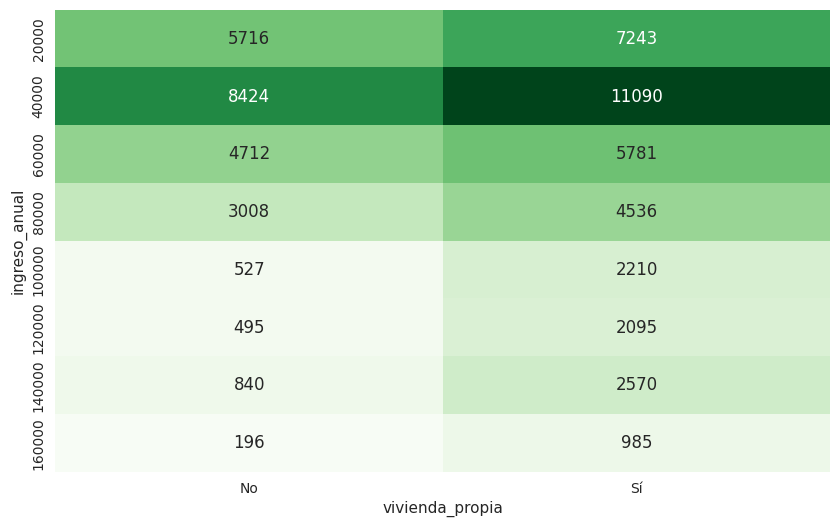

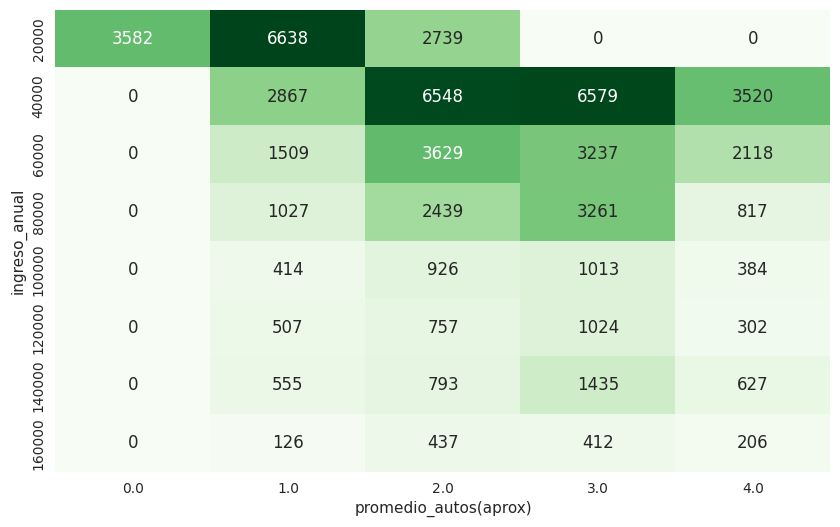

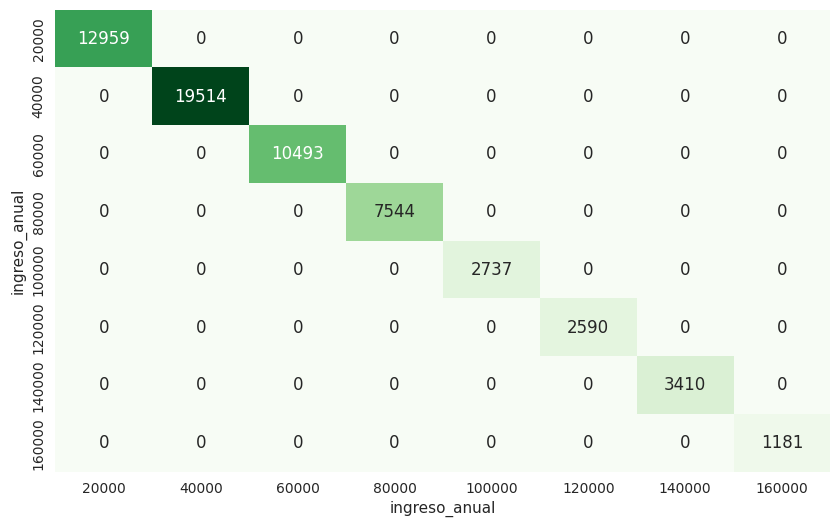

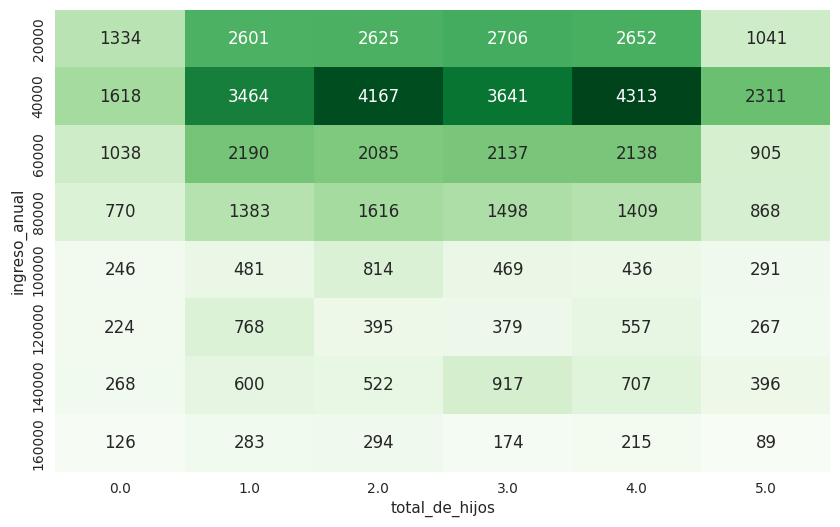

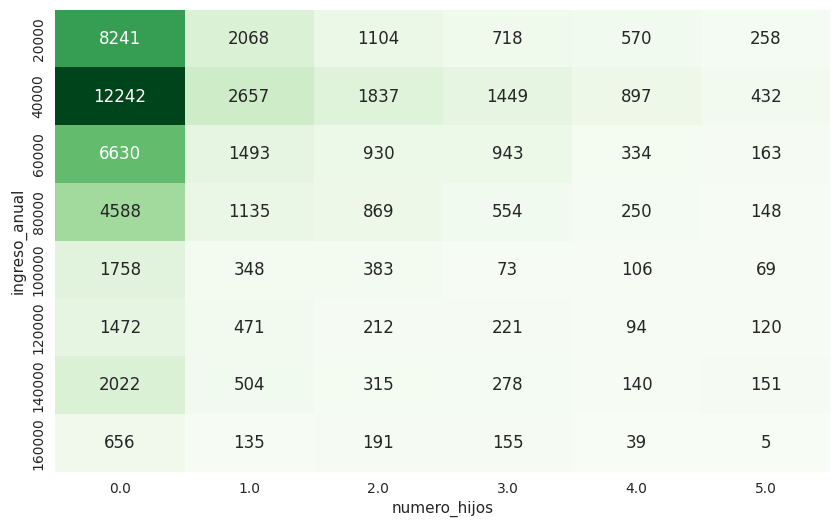

In [ ]:
categorical_crosstable(df,'ingreso_anual',customer_columns,'Greens',True)

Insights:

**1.** Si evidencia una relación positiva entre la variable **"ingreso_anual"** y la variable **"escolaridad"**. Dado que las categorias que tienen mayor número de registros son las de primaria, secundaria e superior; es en dichas variables donde se evidencia más claramente dicha relación positiva. Por lo cual, se considera de añadir esta variable en el modelo de clusterización.

**2.** Otro aspecto importante a considerar, es que hay solo 2 profesiones que tienen valores mayores a los $6000 en terminos del ingreso_anual.


# 2.2 Productos


---



### 2.1.1 EDA


---


In [ ]:
products_columns

['categoria_alimento',
 'departamento',
 'tipo',
 'promocion',
 'marca',
 'empaque_reciclable',
 'bajo_en_grasa',
 'unidades_por_caja',
 'precio_recomendado']

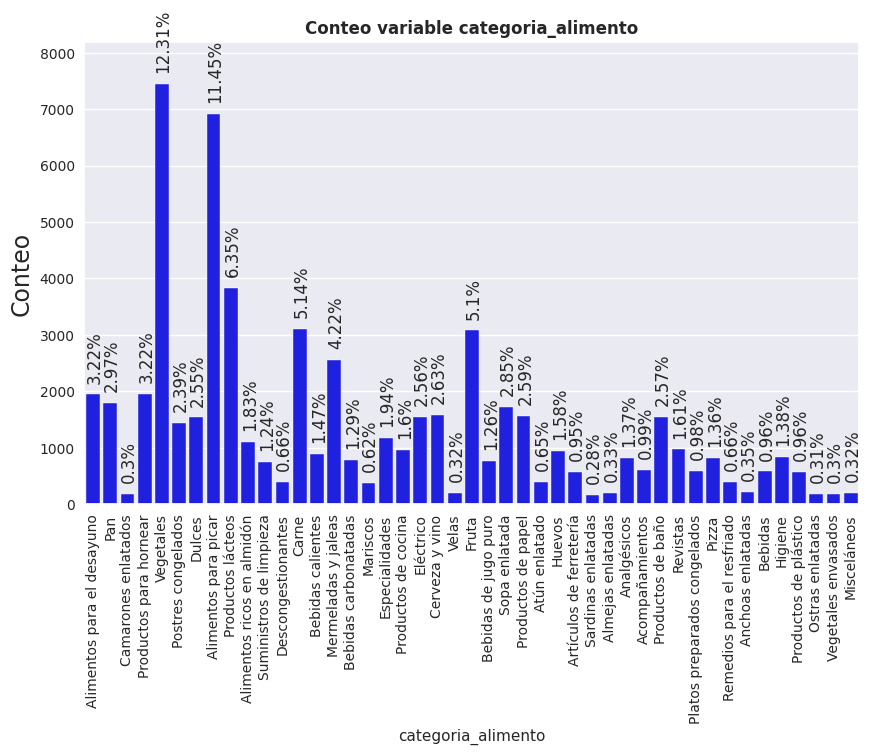

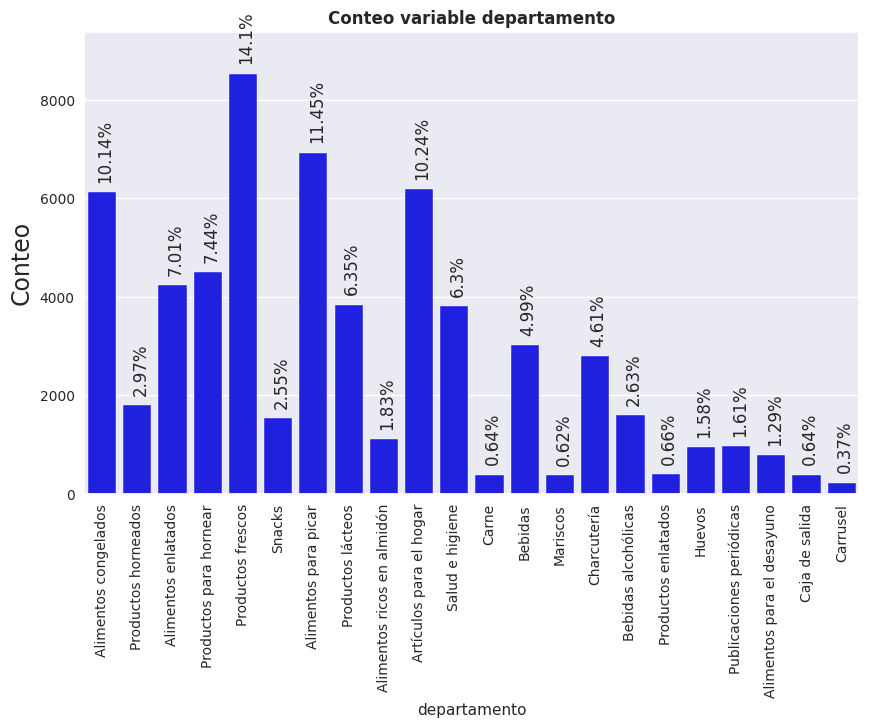

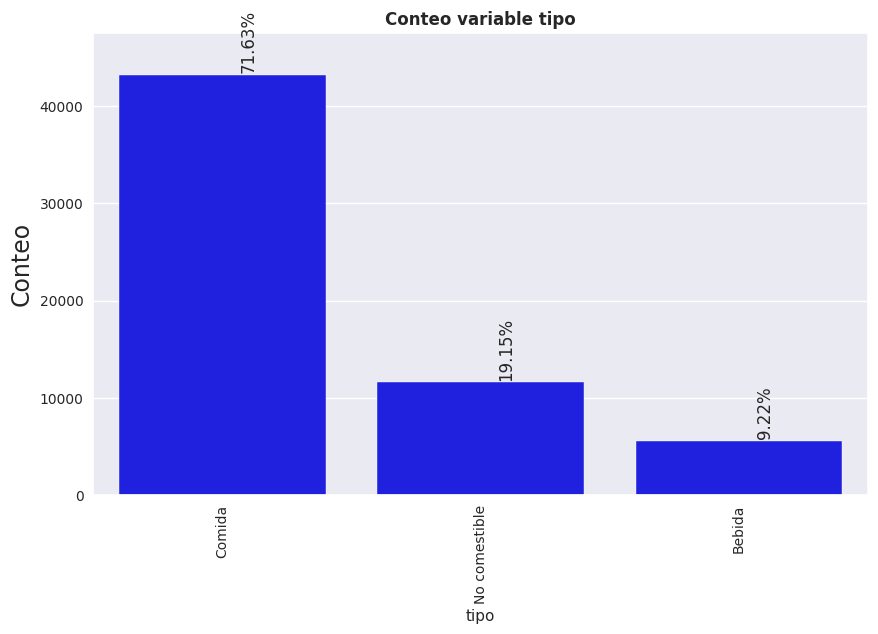

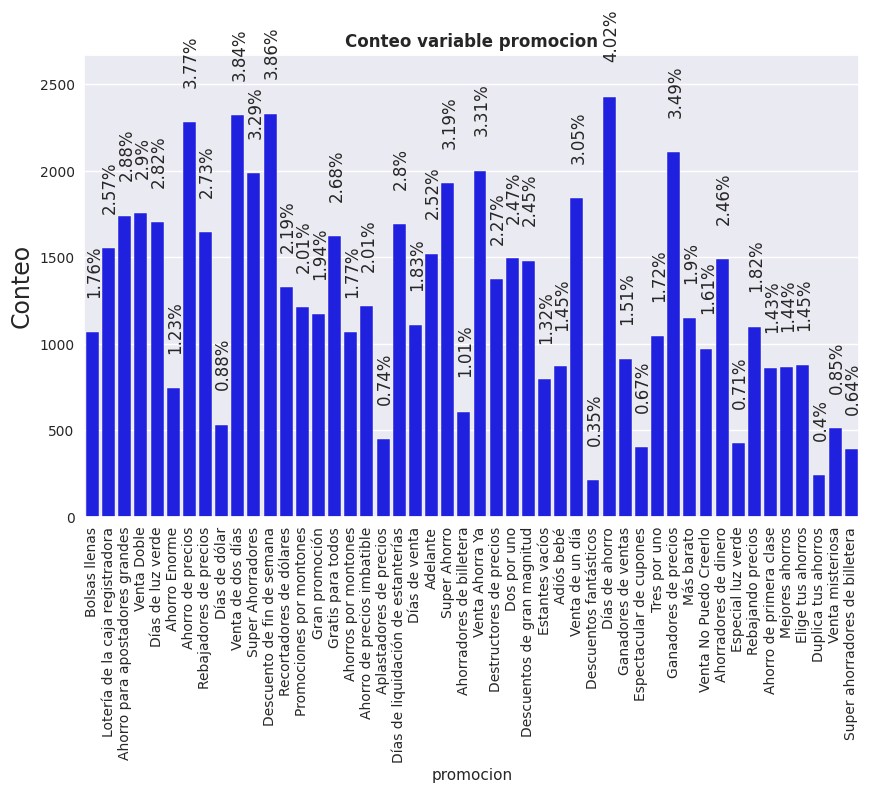

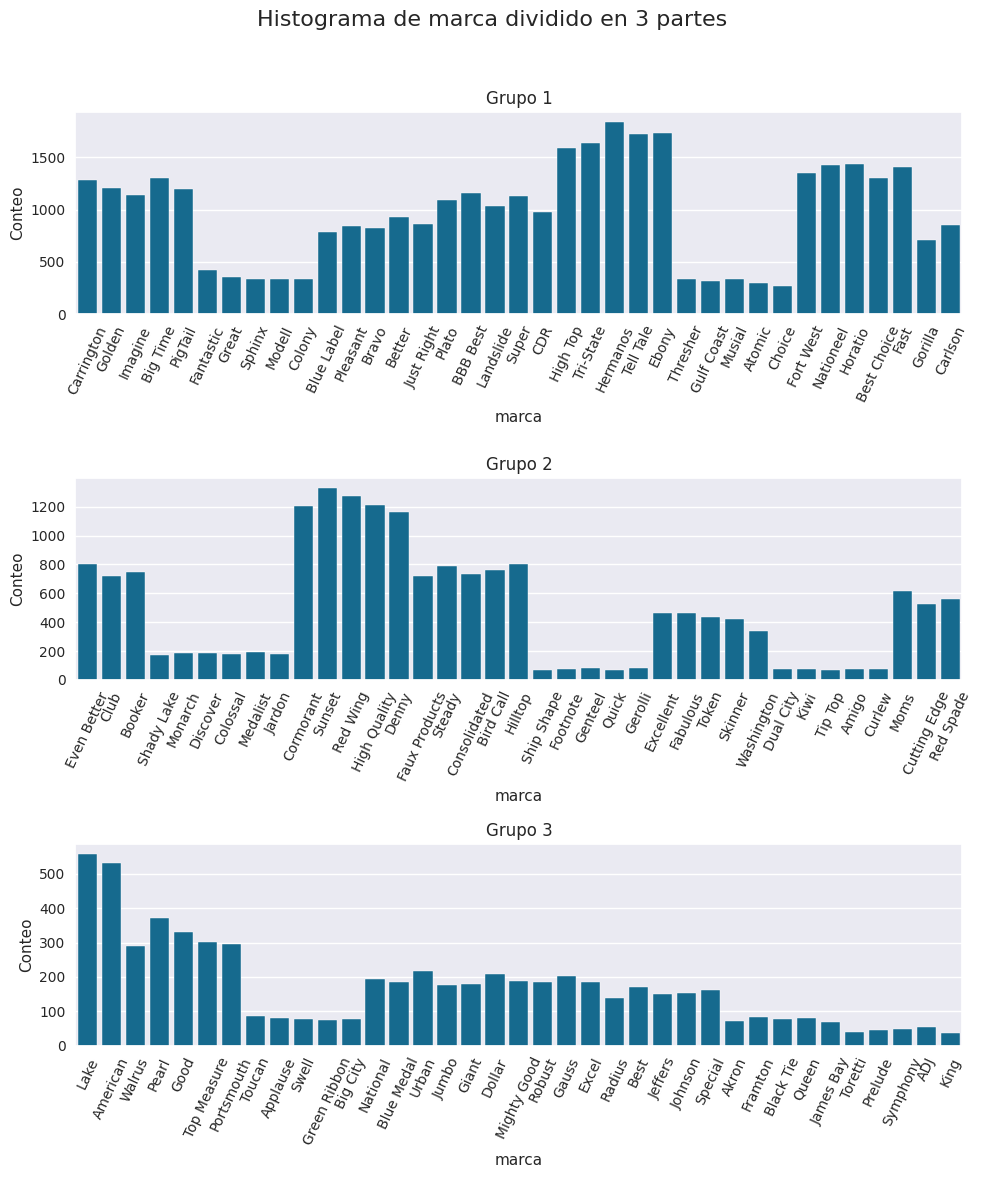

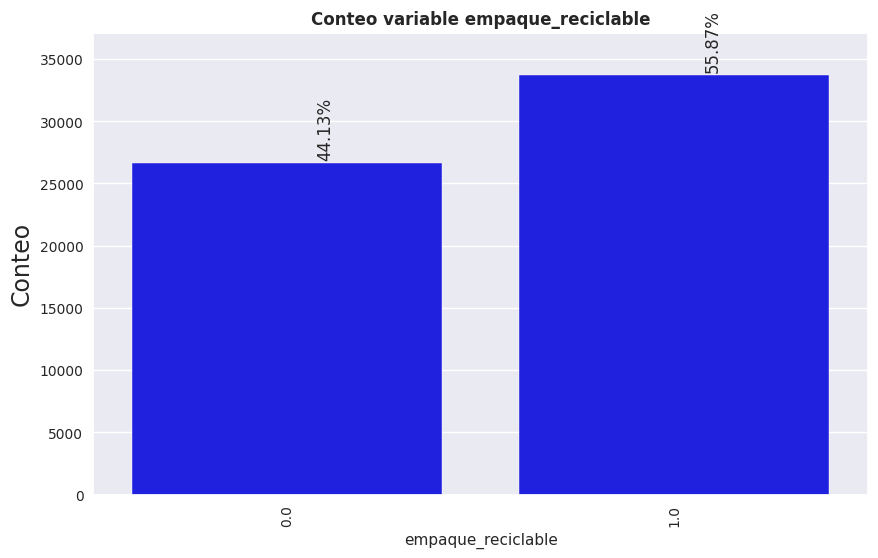

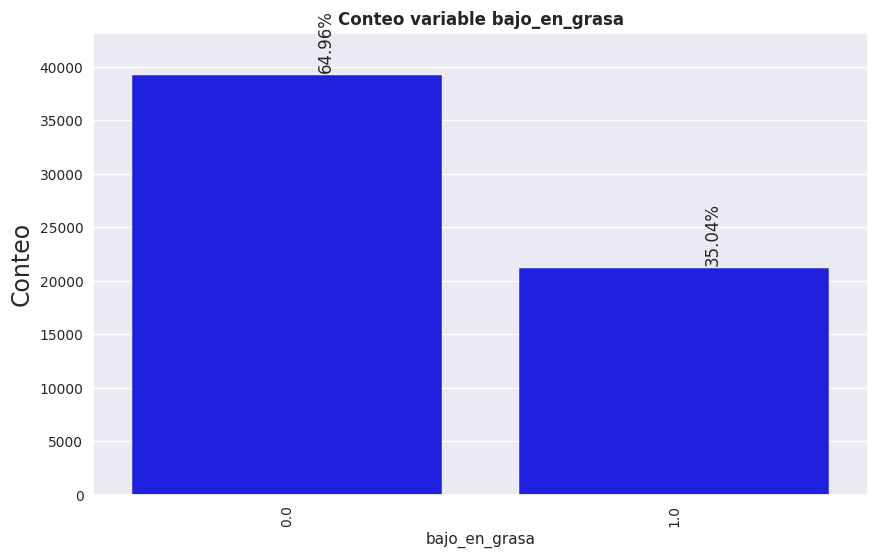

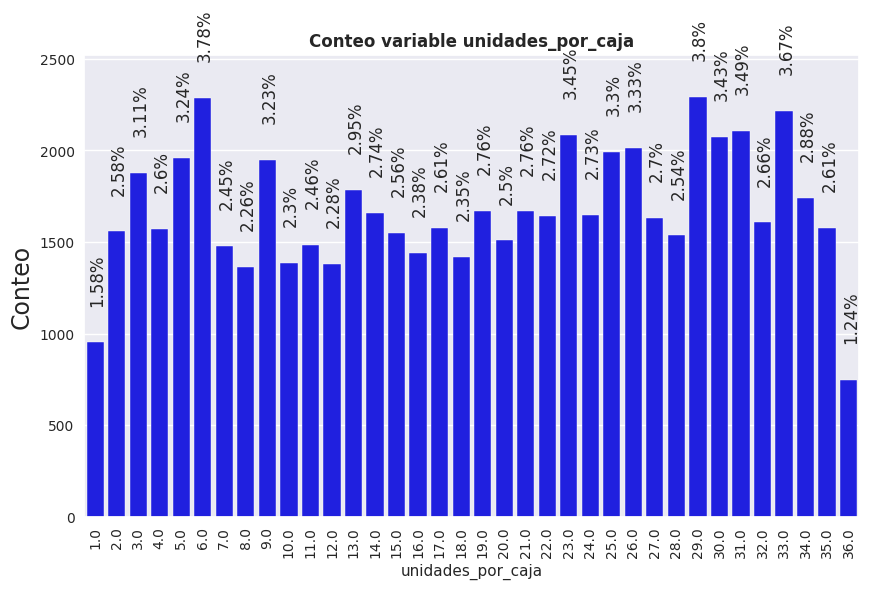

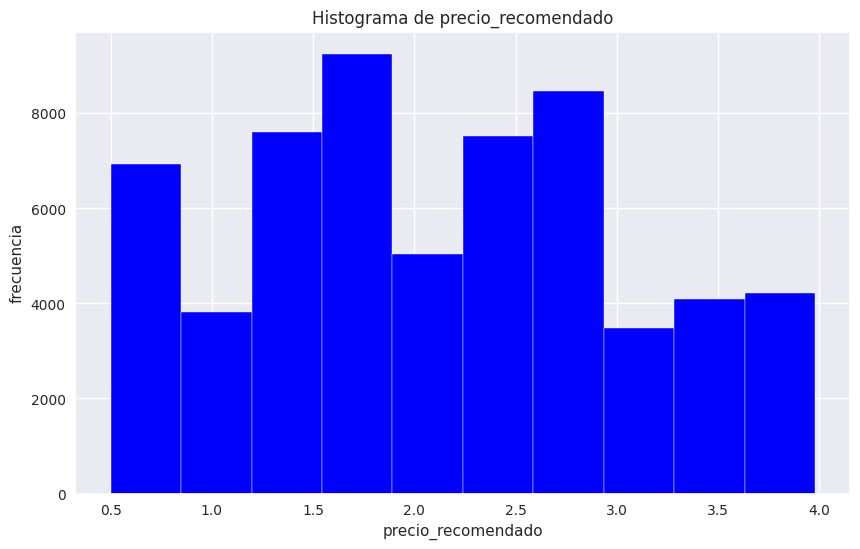

In [92]:
# Se utiliza la misma estrategia aplicada con la variable de los cliente.
# La unica diferencia es que se hace una consideración especial para las
# variables numéricas continuas (precio_recomendado). Se usan histogramas
# en vez de diagramas de barras.

for i in products_columns:
  if i=='precio_recomendado':
    plt.figure(figsize=(10,6))
    plt.hist(df[i],color='blue')
    plt.title('Histograma de ' + i)
    plt.xlabel(i)
    plt.ylabel('frecuencia')
  elif i=='marca':
    # Dividir las categorías en grupos de 10
    grupos = [df['marca'].unique()[i:i+37] for i in range(0, len(df['marca'].unique()), 37)]

      # Crear un gráfico de barras para cada grupo
    fig, axes = plt.subplots(nrows=len(grupos), figsize=(10, 4 * len(grupos)))#, sharex=True)
    plt.title('Histograma de marca dividido en 3 partes')

    for i, grupo in enumerate(grupos):
    # Filtrar el DataFrame para incluir solo las categorías en el grupo actual
      df_grupo = df[df['marca'].isin(grupo)]

    # Crear un gráfico de barras utilizando seaborn
      sns.countplot(x='marca', data=df_grupo, order=grupo, ax=axes[i])

      axes[i].set_ylabel('Conteo')
      axes[i].set_title(f'Grupo {i+1}')
      axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=65)

    # Añadir un título general
    fig.suptitle('Histograma de marca dividido en 3 partes', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el rect para dejar espacio para el título general
    plt.show()
  else:
   plot_porcentajes(i,df,'blue')

### 2.1.2 Analisis Bivariado (con respecto al nivel de ingresos)


---



In [ ]:
df[products_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60428 entries, 0 to 60427
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   categoria_alimento  60428 non-null  object 
 1   departamento        60428 non-null  object 
 2   tipo                60428 non-null  object 
 3   promocion           60428 non-null  object 
 4   marca               60428 non-null  object 
 5   empaque_reciclable  60428 non-null  float64
 6   bajo_en_grasa       60428 non-null  float64
 7   unidades_por_caja   60428 non-null  float64
 8   precio_recomendado  60428 non-null  float64
dtypes: float64(4), object(5)
memory usage: 4.1+ MB


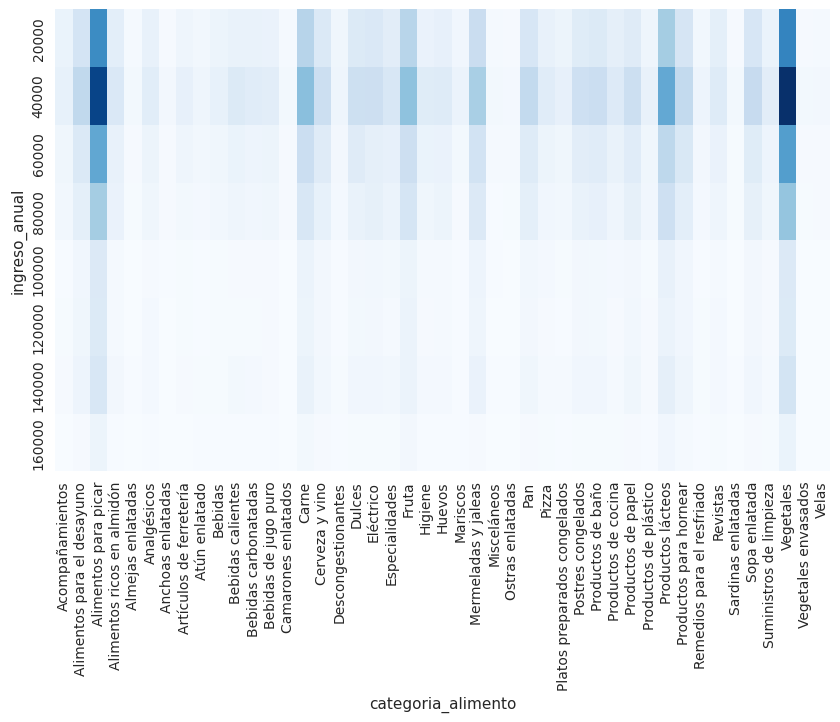

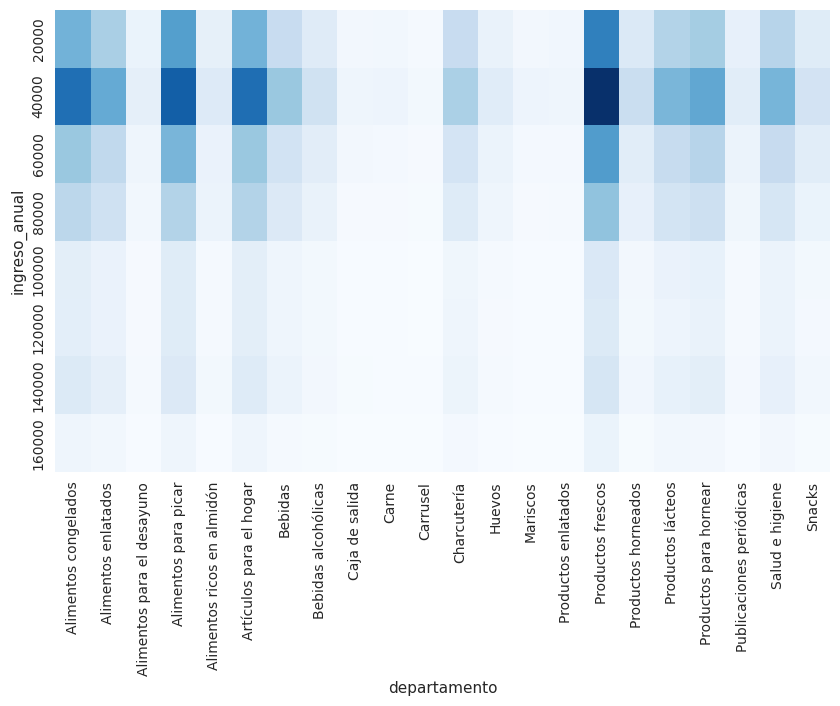

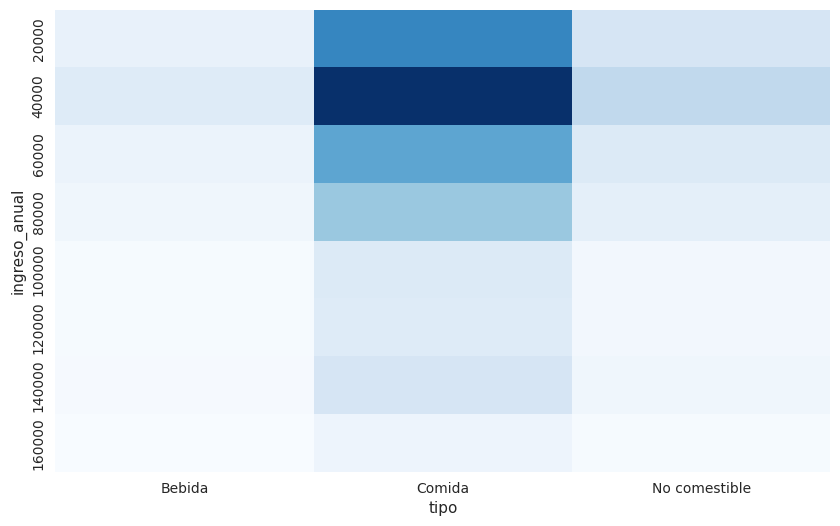

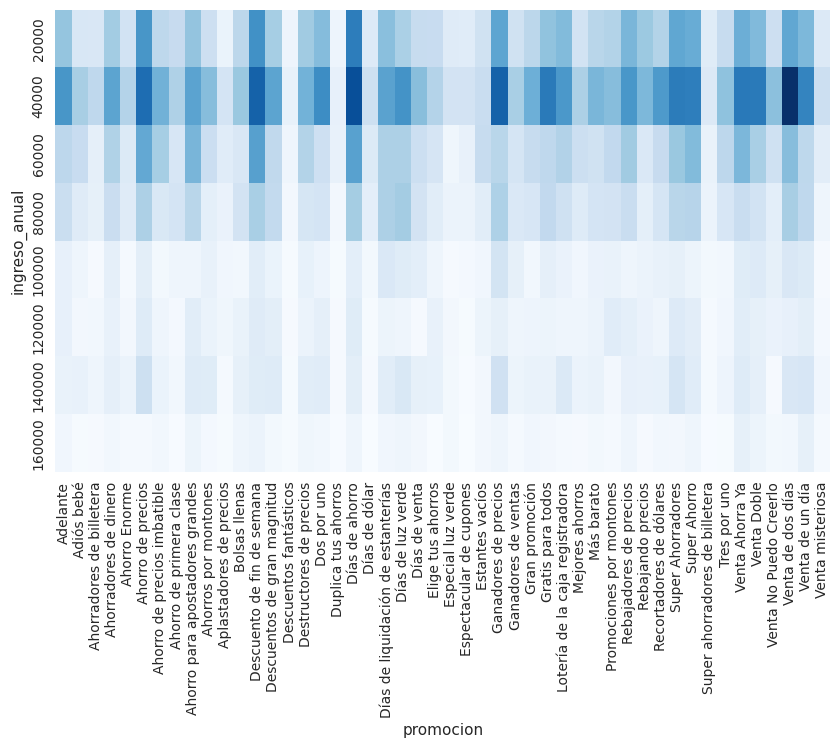

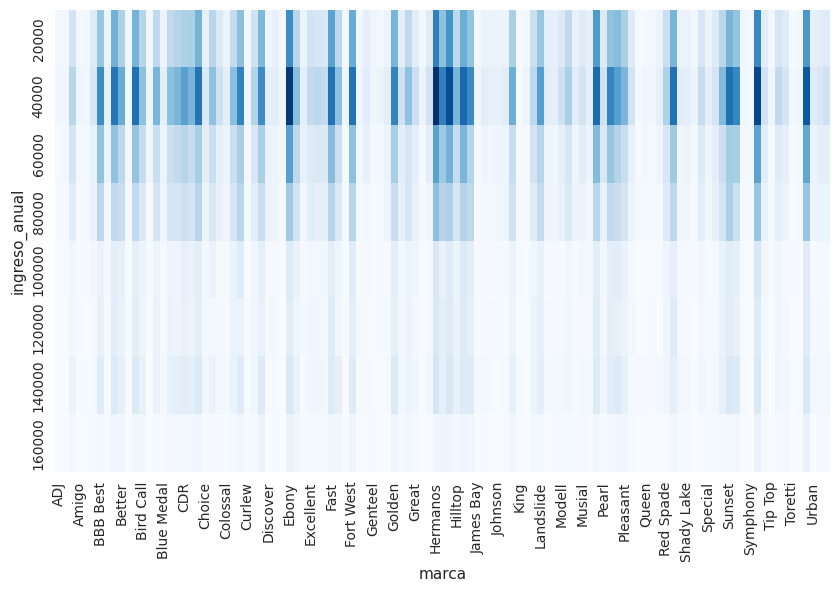

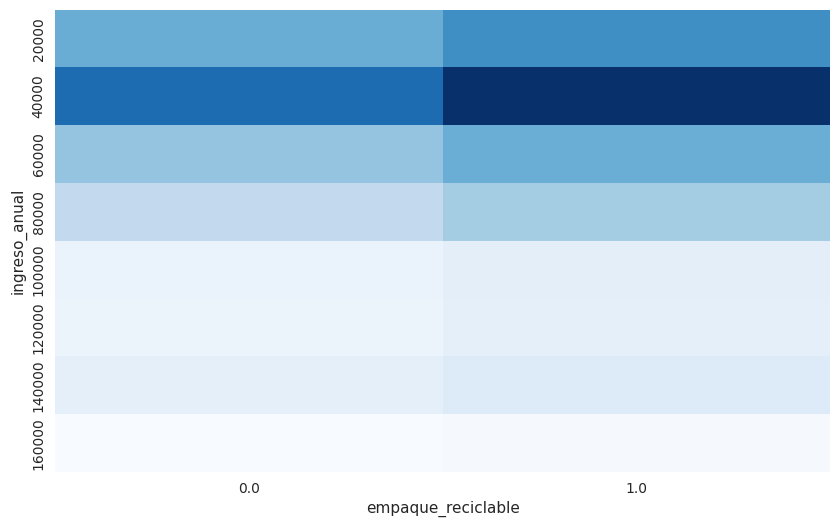

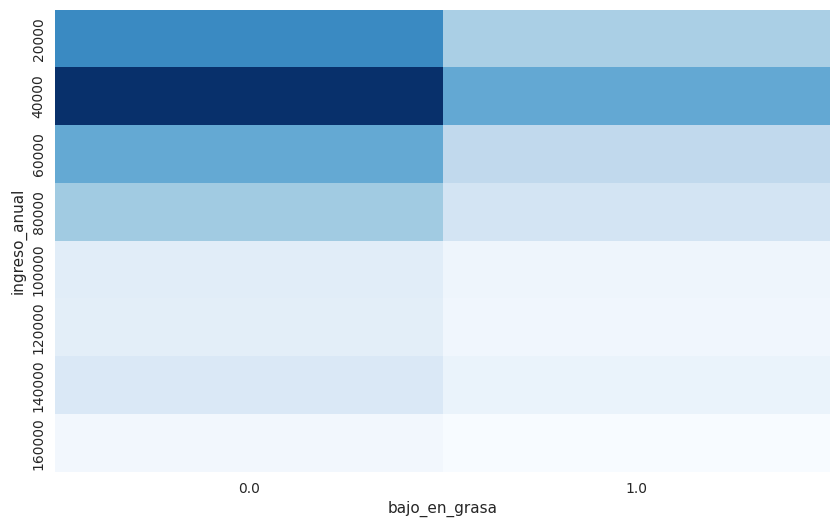

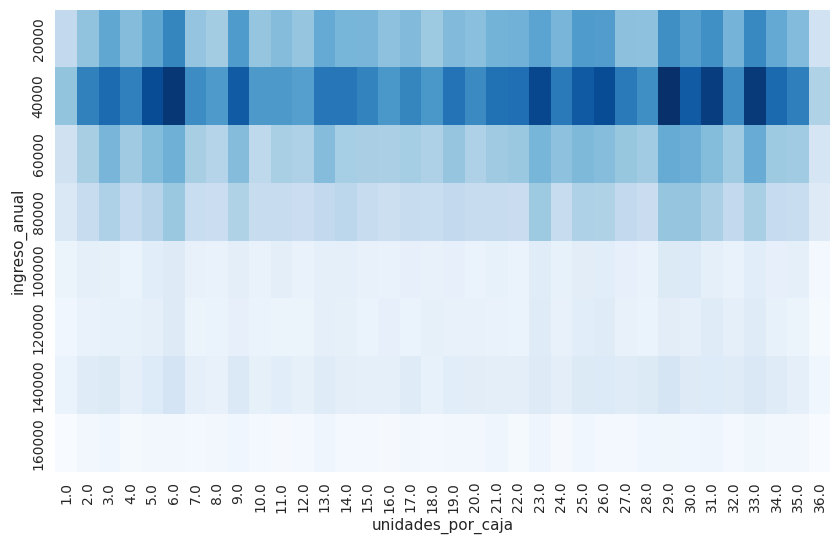

In [ ]:
categorical_crosstable(df,'ingreso_anual',['categoria_alimento','departamento','tipo','promocion','marca','empaque_reciclable','bajo_en_grasa','unidades_por_caja'],'Blues',False)

<Figure size 1000x600 with 0 Axes>

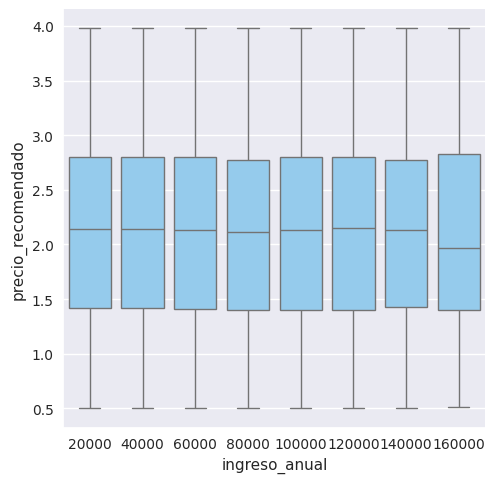

In [ ]:
num_and_cat_boxplot(df,['ingreso_anual'],'precio_recomendado','lightskyblue')

**Comentario:** Como era de esperarse, para todas las variables relacionadas con los productos, la gran mayoría estan concentradas en la franja menor a #8000.

**insights:** Con respecto al tipo de variables que se podrían considerar en el modelo, dado que visualmente no se evidencian patrones particulares, se considera tomar aquellas variables que no tienen muchas categorías. Es importante que el modelo final tenga algunas variables de este grupo porque ofrece información sobre las preferencias de los clientes.


# 2.3 Tiendas


---


### 2.3.1 EDA


---

<ipython-input-18-89549a42be81>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  grafico.set_xticklabels(grafico.get_xticklabels(),rotation=90)
<ipython-input-18-89549a42be81>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  grafico.set_xticklabels(grafico.get_xticklabels(),rotation=90)
<ipython-input-18-89549a42be81>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  grafico.set_xticklabels(grafico.get_xticklabels(),rotation=90)
<ipython-input-18-89549a42be81>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  grafico.set_xticklabels(grafico.get_xticklabels(),rotation=90)
<ipython-input-18-89549a42be81>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  grafico.set_xticklabels(grafico.get_xticklabels(),rotation=90)
<ipython-input-18-89549a42be81>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  grafico

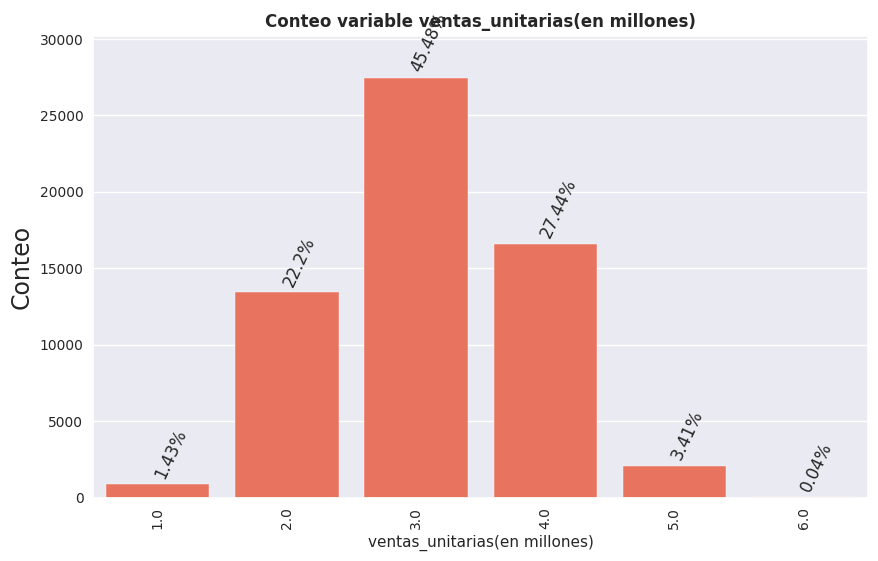

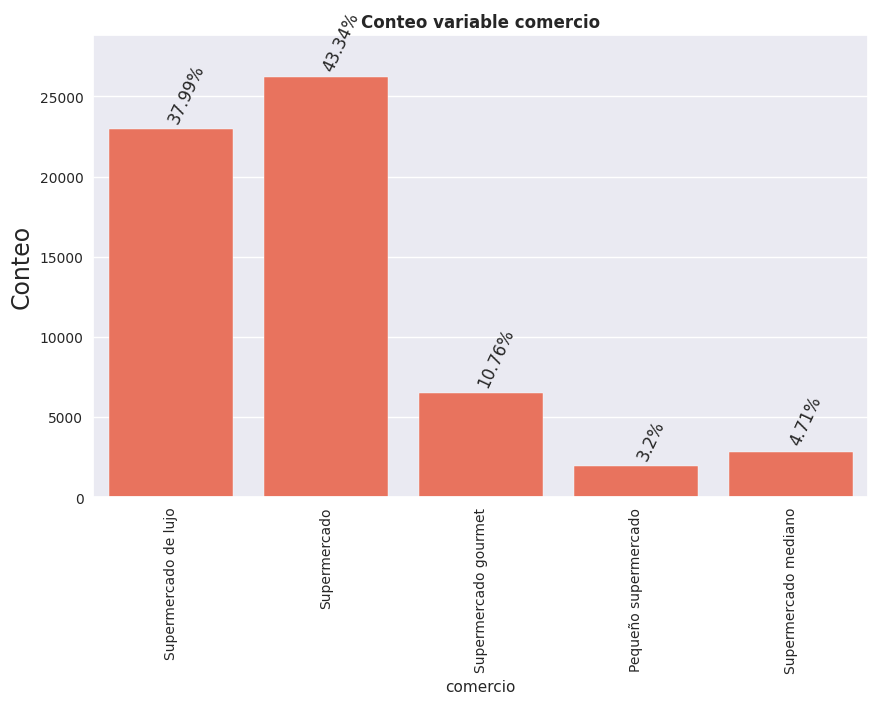

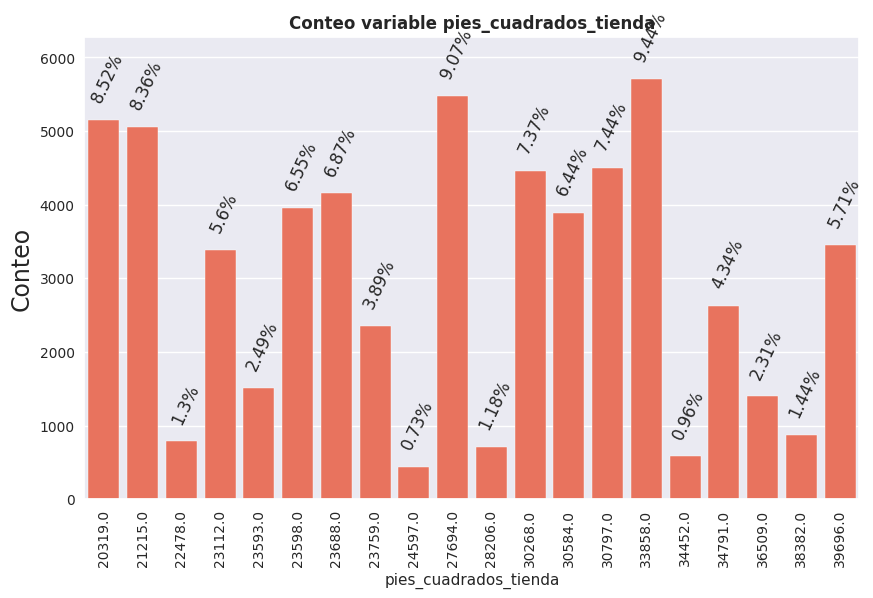

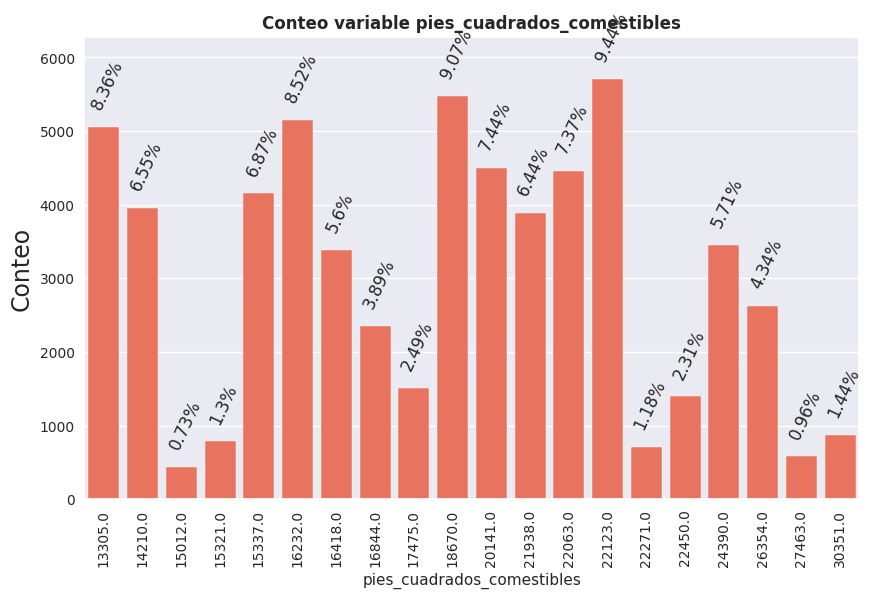

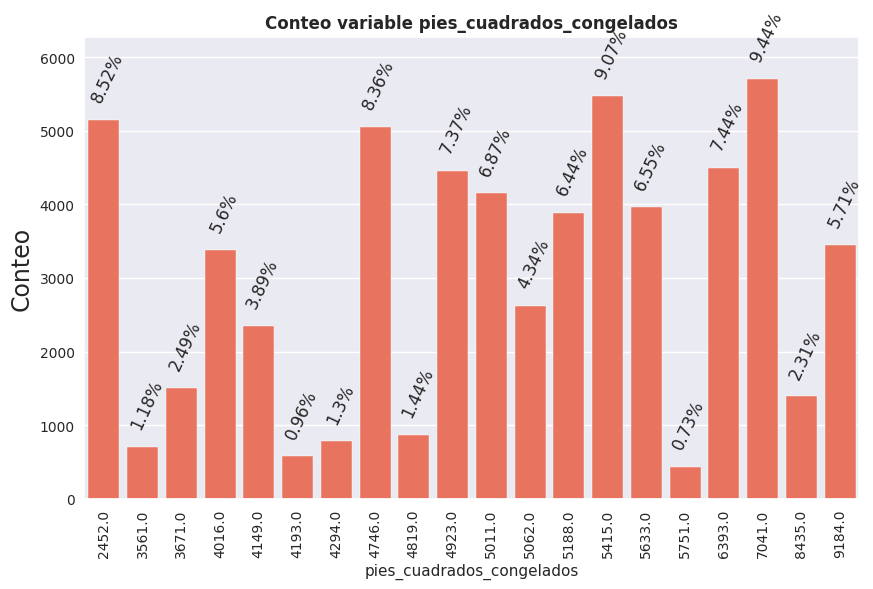

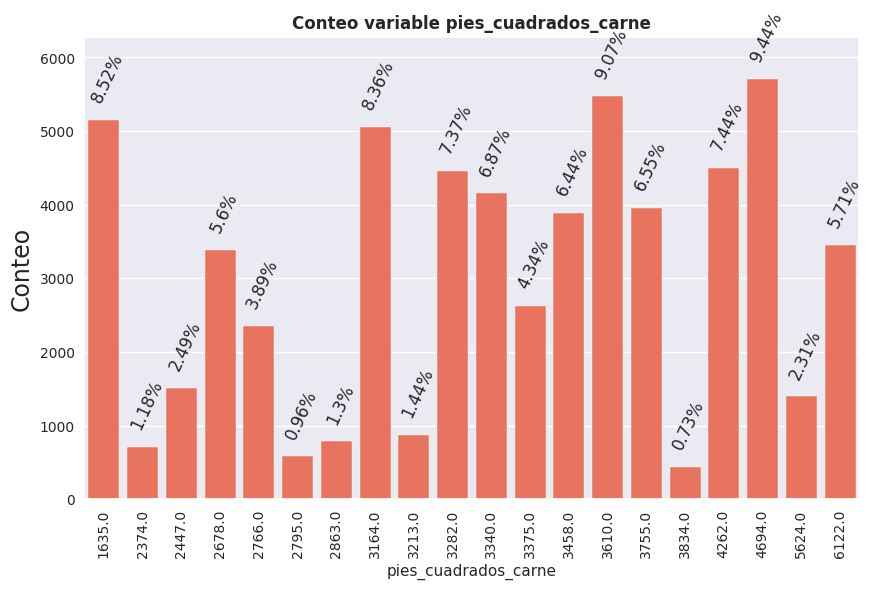

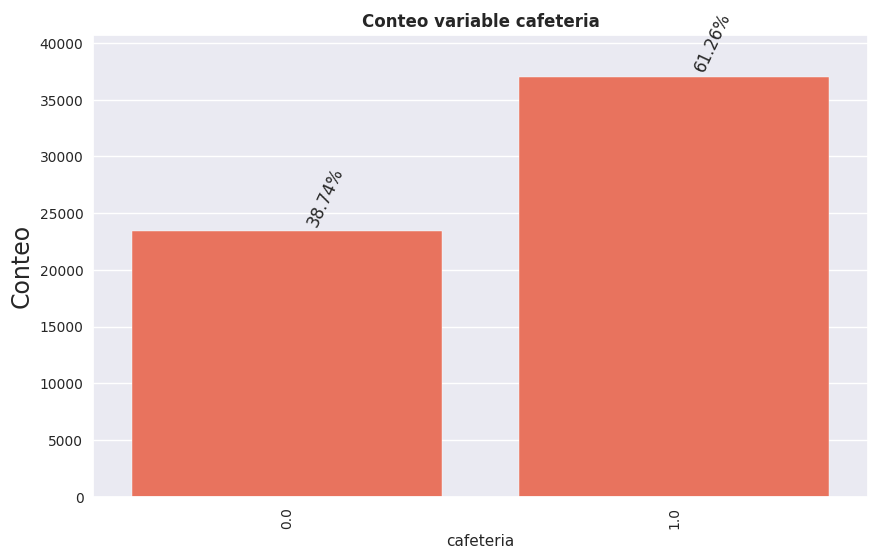

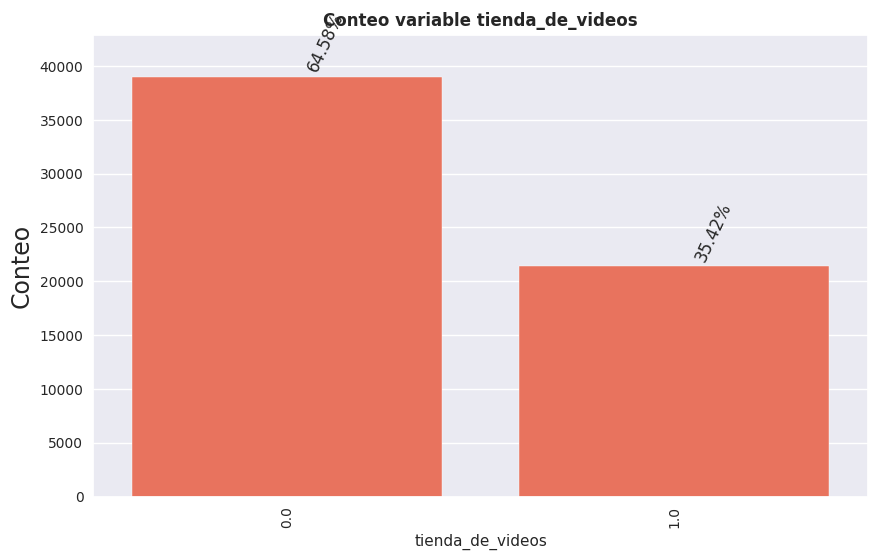

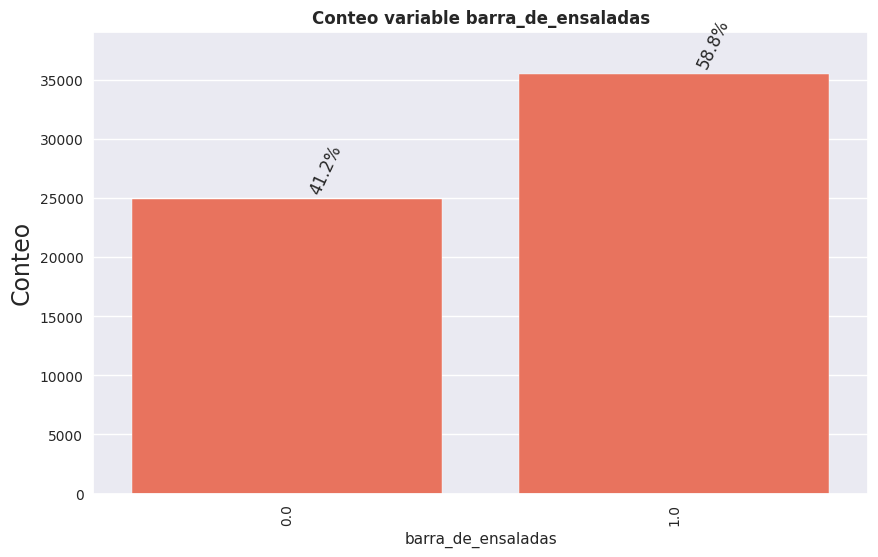

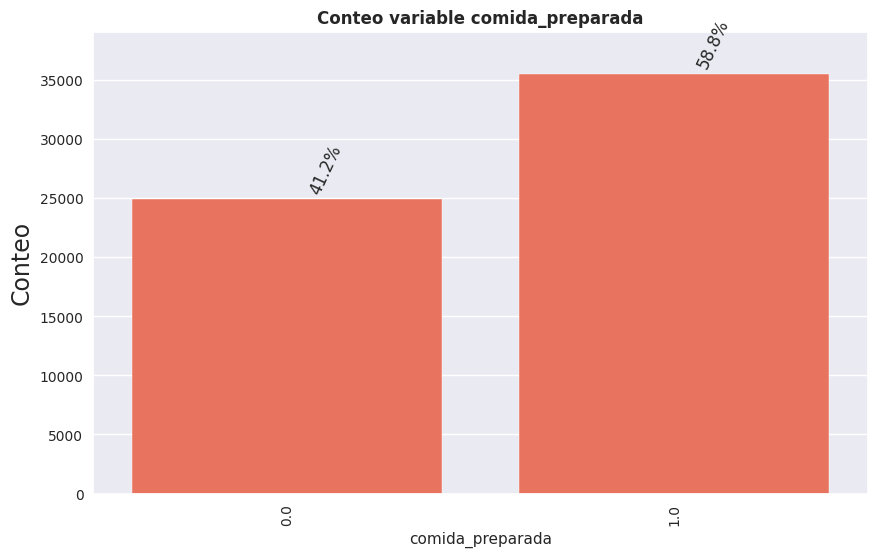

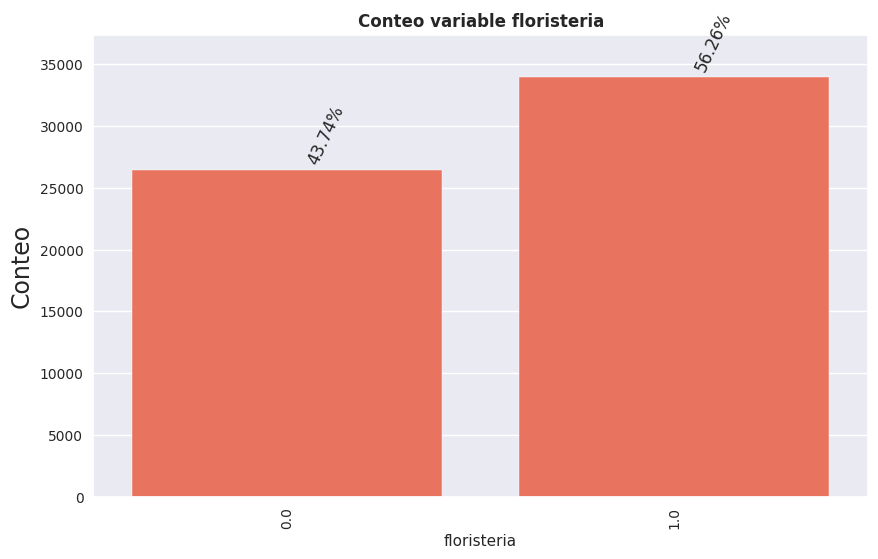

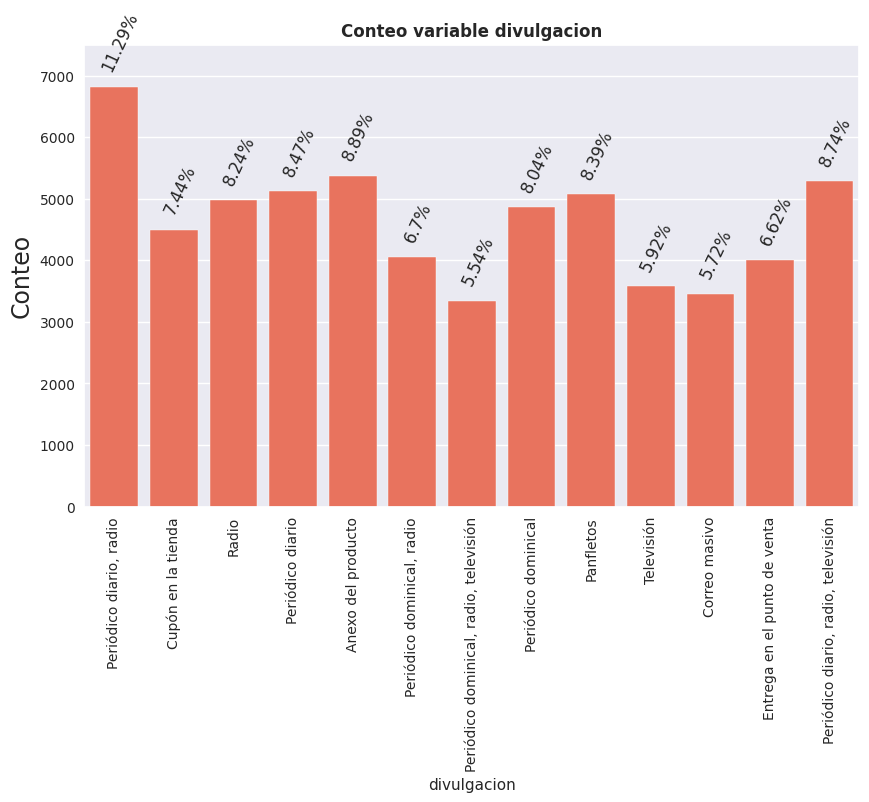

In [ ]:
for i in stores_columns:
  plot_porcentajes(i,df,'tomato')

### 2.3.2 Analisis Bivariado (con respecto al nivel de ingresos)


---



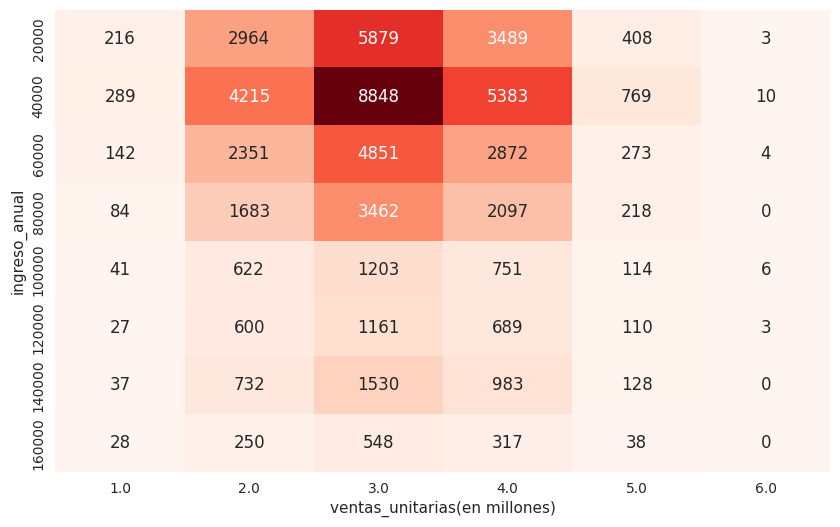

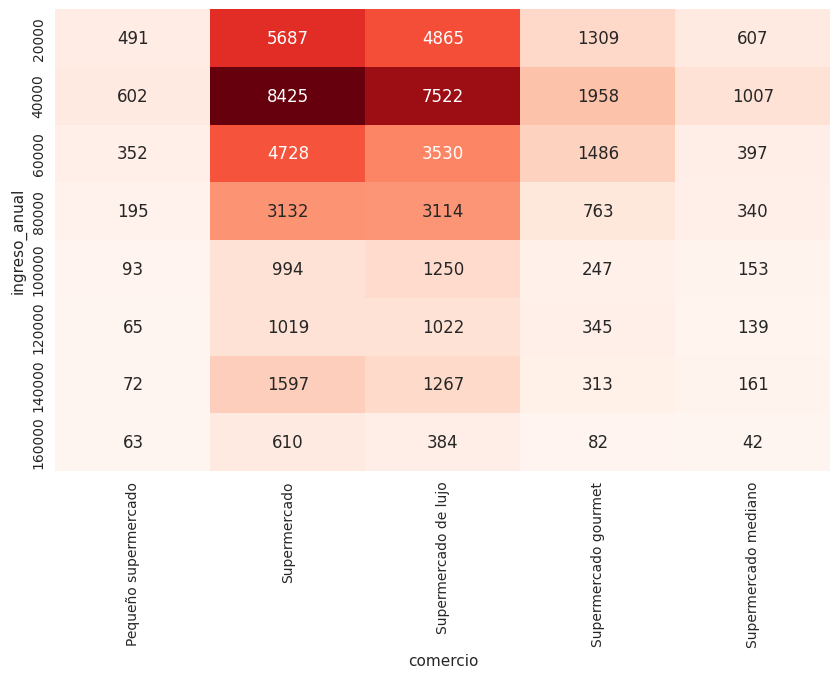

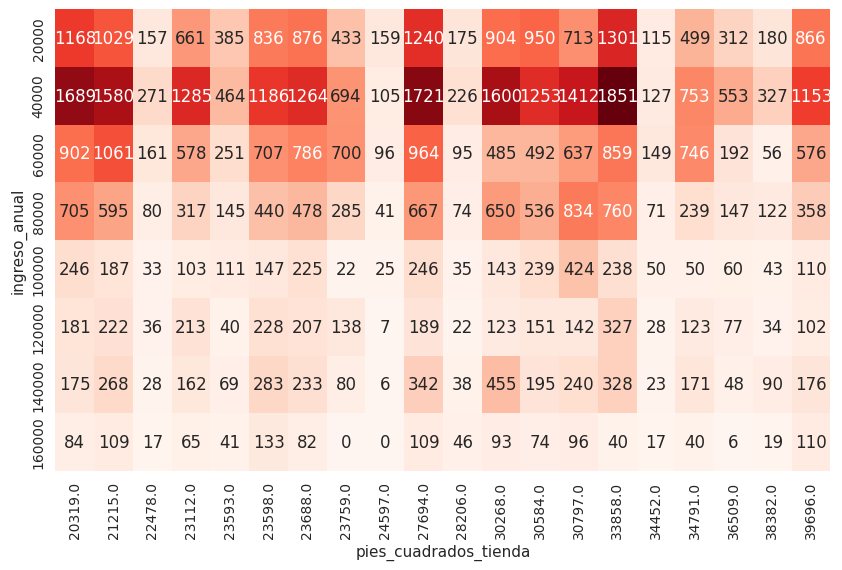

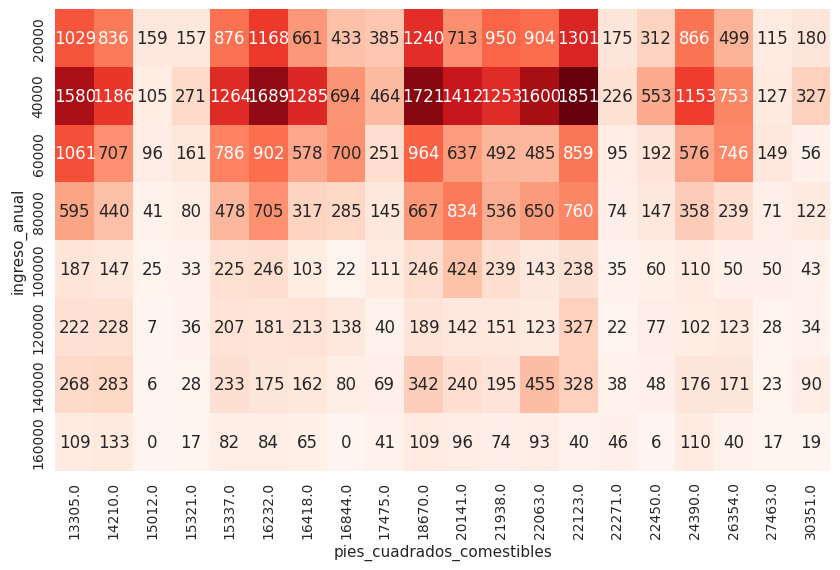

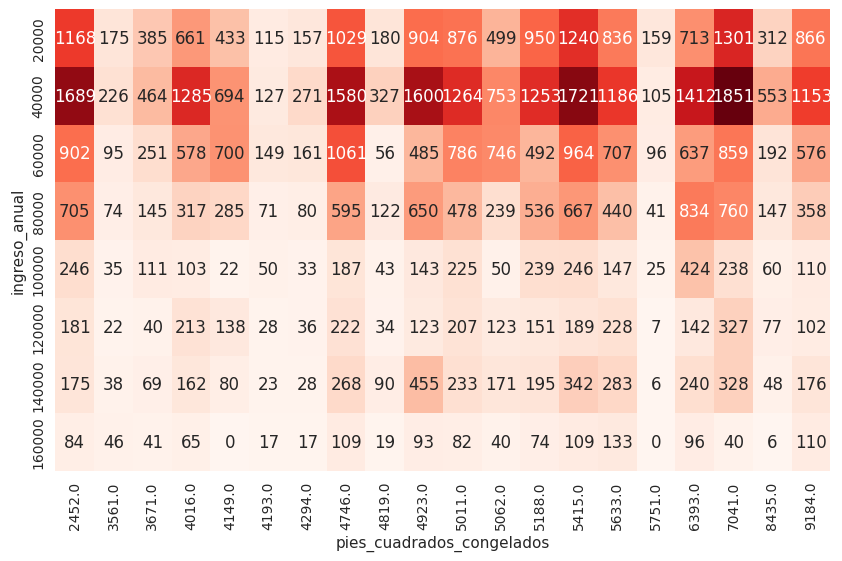

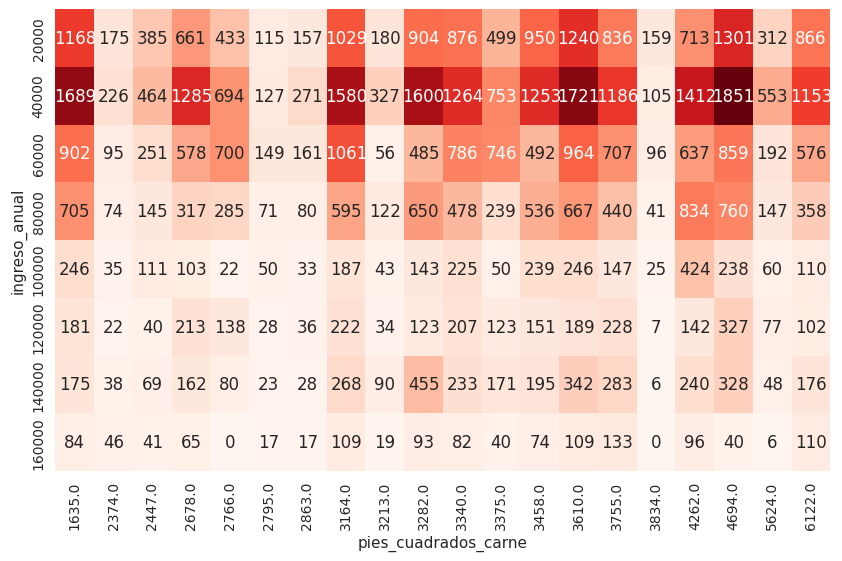

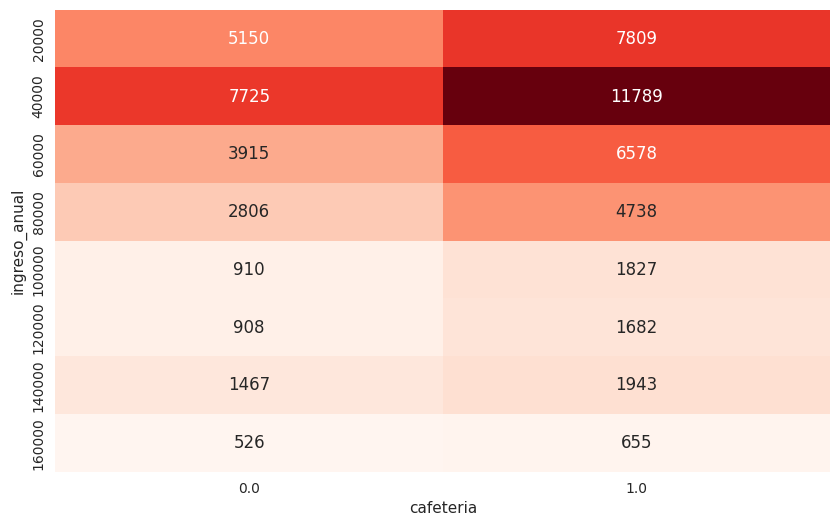

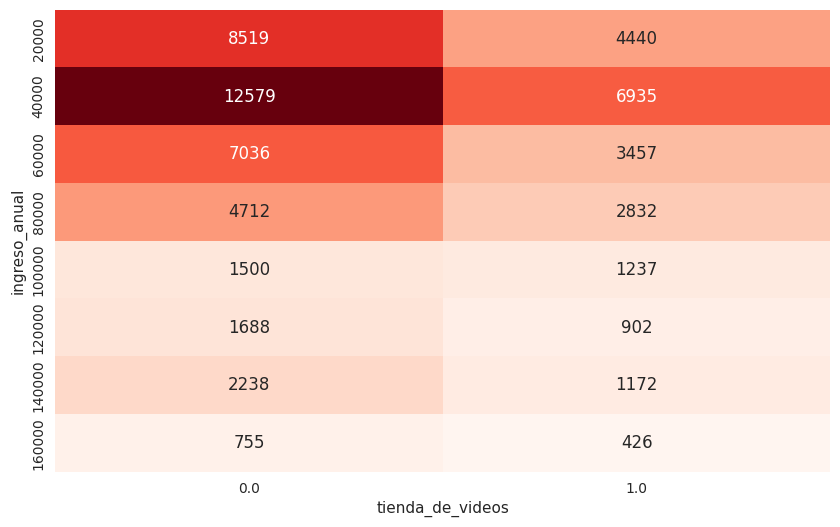

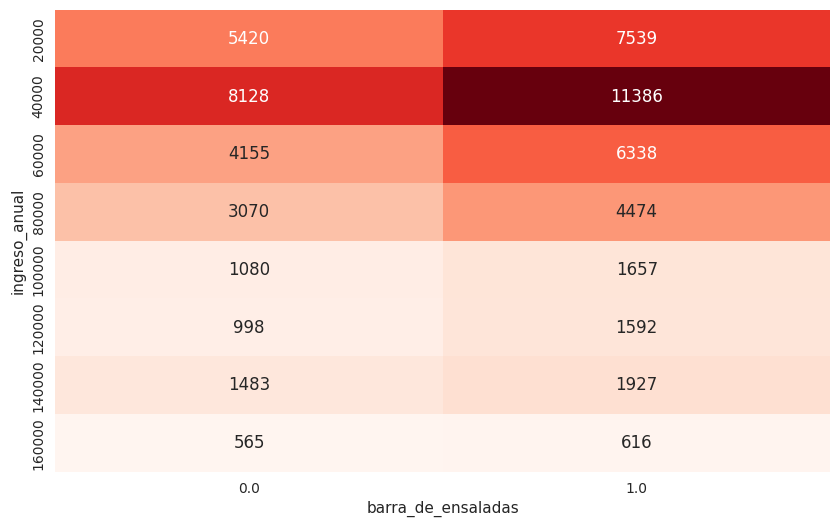

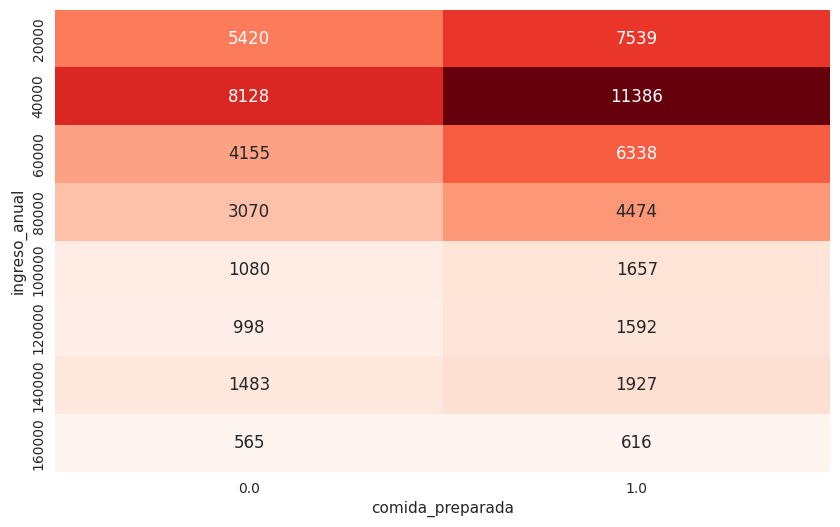

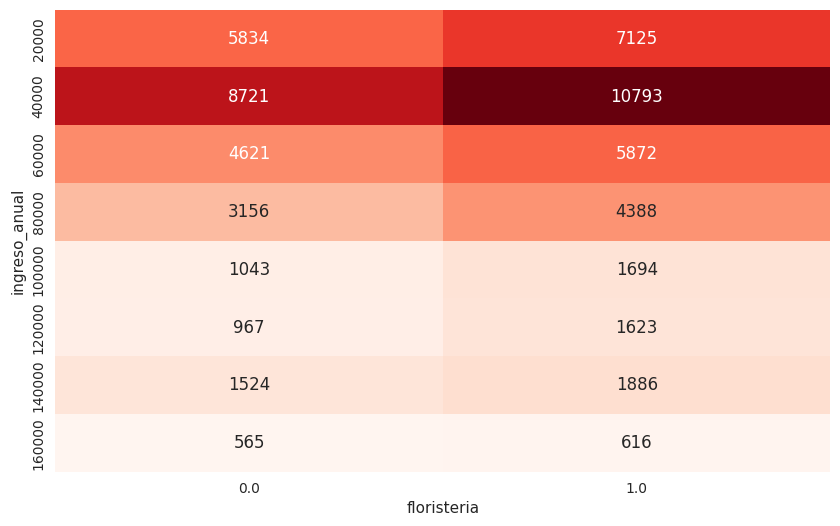

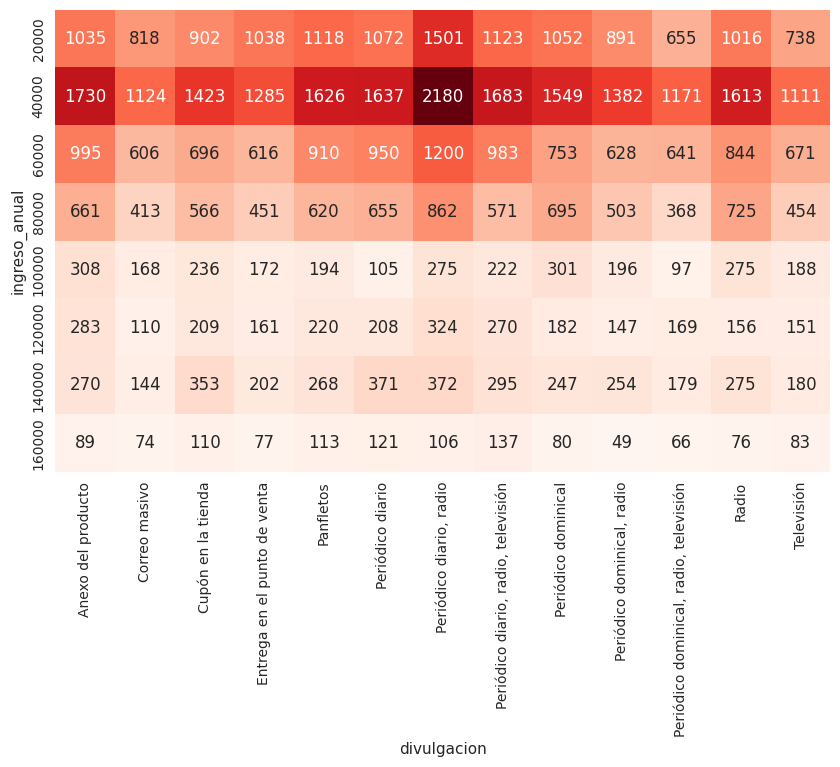

In [ ]:
categorical_crosstable(df,'ingreso_anual',stores_columns,'Reds',True)

<Figure size 1000x600 with 0 Axes>

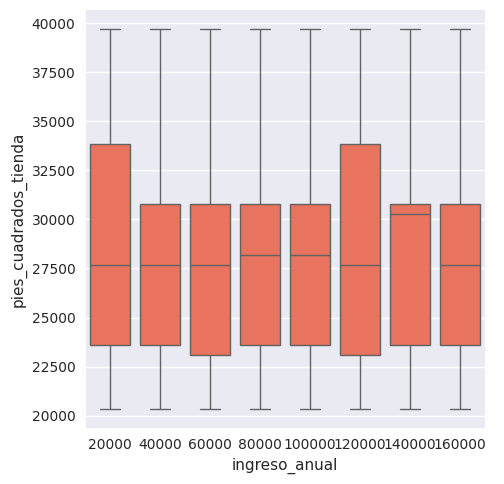

In [ ]:
num_and_cat_boxplot(df,['ingreso_anual'],"pies_cuadrados_tienda",'tomato')

**Comentario:** Como era de esperarse, para todas las variables relacionadas con los productos, la gran mayoría estan concentradas en la franja menor a $8000. Especialmente en 4000 dolares.

**insights:** Con respecto al tipo de variables que se podrían considerar en el modelo, dado que visualmente no se evidencian patrones particulares, se considera tomar aquellas variables que en el momento de realizar los tests, obtengan un índice elevado. De lo contrario, las variables relacionadas a las características de las tiendas no serán consideradas.

**Comentario:** Las **variables geográficas** no fueron consideradas para el objeto de este análisis. Una cosa que se podría hacer más adelante es realizar el mismo análisis de cluster por regiones separadas, ya que dicha información tendría un valor más relevante que el de hacer un análisis global de todos los clientes.



---


# 3. Preprocesamiento y Obtención de Features

---



# 3.1 Creación de funciones


---



In [ ]:
# El StandardScaler se utiliza para estandarizar las características (variables) de un conjunto de datos.
# La instancia 'ss' del StandardScaler se puede utilizar para ajustar (fit) y transformar (transform) los datos.

ss = StandardScaler()

In [ ]:
# Esta función transformar_df realiza dos pasos principales: aplica one-hot encoding
# a las columnas dummy utilizando pd.get_dummies y luego estandariza todo el DataFrame
# utilizando StandardScaler. La función devuelve el DataFrame transformado.

def transformar_df(data,dummy_columns):
  # Aplicar one-hot encoding a las columnas dummy
  data=pd.get_dummies(data, columns=dummy_columns)

  # Aplicar estandarización a todo el DataFrame
  data=ss.fit_transform(data)

  # Devuelve el DataFrame transformado
  return data

In [ ]:
# Esta función toma la inercia de un modelo de clustering, así como el número mínimo y máximo de clusters.
# Calcula la distancia perpendicular entre cada punto en la curva de inercia y la línea que conecta los puntos mínimo y máximo.
# La función devuelve una lista de distancias, que se pueden utilizar para identificar el "codo" en la curva de inercia,
# que a menudo indica el número ideal de clusters en un algoritmo de clustering.


def numero_ideal_clusters(inercia, min_clusters, max_clusters):
   # Coordenadas del punto mínimo (min_clusters, inercia[0])
  x1,y1 = min_clusters, inercia[0]
  # Coordenadas del punto máximo (max_clusters, inercia[-1])
  x2,y2 = max_clusters, inercia[-1]

  distancia =[]

  # Iterar sobre la inercia para calcular las distancias
  for i in range(len(inercia)):
    x0 = i+1
    y0 = inercia[i]
    # Calcular la distancia perpendicular entre el punto y la línea que une los puntos mínimo y máximo
    numerador = abs((y2-y1)*x0-(x2-x1)*y0 + x2*y1 -y2*x1)
    denominador = ((y2-y1)**2 + (x2-x1)**2)**(1/2)
    distancia.append(numerador/denominador)

  return distancia

In [ ]:
# Esta función toma un conjunto de datos 'datos' y un rango de clusters 'min_clusters' a 'max_clusters'.
# Utiliza el algoritmo KMeans para ajustar modelos con diferentes números de clusters y calcula diferentes scores para cada configuración.
# Devuelve un DataFrame con los scores y un gráfico que muestra la inercia en función del número de clusters.

def calcular_scores(datos, min_clusters, max_clusters):
   # Listas para almacenar los resultados
  elbow=[]
  sil_score_list=[]
  dbi_score_list=[]
  ch_score_list=[]
  cluster_dict = {}

  # Iterar sobre el rango de clusters
  for k in range(min_clusters,max_clusters):
     # Inicializar y ajustar el modelo de KMeans
    kmeans= KMeans(n_clusters=k, random_state=42)
    clusters=kmeans.fit_predict(X=datos)
    cluster_dict[k]=[clusters]

    # Calcular la inercia y añadirla a la lista
    elbow.append(kmeans.inertia_)

    # Calcular el silhouette score y añadirlo a la lista
    sil_score = silhouette_score(datos,clusters)
    sil_score_list.append(sil_score)

    # Calcular el Davies-Bouldin score y añadirlo a la lista
    dbi_score = davies_bouldin_score(datos, clusters)
    dbi_score_list.append(dbi_score)

    # Calcular el Calinski-Harabasz score y añadirlo a la lista
    ch_score = calinski_harabasz_score(datos, clusters)
    ch_score_list.append(ch_score)

  # Crear un DataFrame con la inercia para visualizar el elbow method
  df_cost = pd.DataFrame()
  df_cost['clusters'] = range( min_clusters, max_clusters)
  df_cost['inercia'] = elbow

  # elbow method for number of clusters
  plt.figure(figsize=(10,6))
  grafico = sns.lineplot(x='clusters', y= 'inercia', data=df_cost)

  # Crear un DataFrame con los scores y la regla matemática del codo
  df_scores=pd.DataFrame({'clusters':range(min_clusters,max_clusters),
                            'Regla_matematica_codo':numero_ideal_clusters(elbow,min_clusters,max_clusters-1),
                            'silhouette_score':sil_score_list,'davies_bouldin_score':dbi_score_list,
                            'calinski_harabasz_score':ch_score_list})

  # Devuelve los scores y el gráfico
  return df_scores, grafico, cluster_dict

In [ ]:
# Esta función toma un conjunto de datos 'data', una lista de columnas dummy 'dummy_columns' y una métrica 'metric'.
# Aplica one-hot encoding a las columnas dummy y estandariza el conjunto de datos.
# Luego utiliza el KMeans y el KElbowVisualizer para visualizar la inercia y ayudar
# a determinar el número óptimo de clusters.

def visualize_distortion_score(data,dummy_columns,metric,locate_elbow,timings):

  # Aplicar one-hot encoding a las columnas dummy
  data = pd.get_dummies(data, columns=dummy_columns)

  # Aplicar estandarización a todo el DataFrame
  data= ss.fit_transform(data)

  # Crear una instancia del modelo KMeans
  km = KMeans(random_state=42)

  # Crear un visualizador KElbowVisualizer para determinar el número óptimo de clusters
  visualizer = KElbowVisualizer(km, k=(2,11), metric=metric,locate_elbow=locate_elbow,timings=timings)

  # Ajustar el modelo KMeans y visualizar la inercia
  visualizer.fit(data)
  visualizer.show()

In [ ]:
# Esta función toma un conjunto de datos 'data' y una lista de columnas dummy 'dummy_columns'.
# Aplica one-hot encoding a las columnas dummy y estandariza el conjunto de datos.
# Luego, crea subgráficas para visualizar los resultados del gráfico de Silhouette para diferentes números de clusters.

def plot_SilhouetteVisualizer(data,dummy_columns):

  # Aplicar one-hot encoding a las columnas dummy
  data=pd.get_dummies(data, columns=dummy_columns)

  # Aplicar estandarización a todo el DataFrame
  data=ss.fit_transform(data)

  # Crear una figura con subgráficos para visualizar los resultados para diferentes números de clusters
  fig, ax = plt.subplots(5, 2, figsize=(15,8))

  # Iterar sobre diferentes números de clusters
  for i in range(2,11):

    # Crear una instancia del modelo KMeans
    km = KMeans(n_clusters=i, random_state=42)

    # Calcular la posición de la subgráfica en la figura
    q, mod = divmod(i, 2)

    # Crear una instancia de SilhouetteVisualizer con el modelo KMeans
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])

    # Ajustar el modelo y visualizar el gráfico de Silhouette
    visualizer.fit(data)

# 3.2 Preprocesamiento de los datos


---



In [ ]:
# Estas son las variables que voy a incorporar en mi modelo

X=df[['ingreso_anual','escolaridad','tipo','bajo_en_grasa']]

In [ ]:
# Se realizan dos tipos de transformaciones.


# La variable ingreso_anueal la agruperemos en 4 grupos en vez de 8
# como se muestra en el diccionario transforming_ingreso_anual
transforming_ingreso_anual={20000:1,40000:2,60000:3,80000:3,100000:4,120000:4,140000:4,160000:4}


# La variable escolaridad la cambiamos de "string" a ordinal.
# Como se muestra en el diccionario escolaridad_column
escolaridad_column={'Primaria':1,'Secundaria':2,'Técnico':3,'Superior':4,'Maestría':5}

X.escolaridad = X.escolaridad.map(escolaridad_column)
X.ingreso_anual = X.ingreso_anual.map(transforming_ingreso_anual)

In [ ]:
# Se prepara el dataset para poder ser usado en el modelo de clusterización kmeans
X_std=transformar_df(X,['tipo'])

In [ ]:
X_std[0]

array([-1.41266466, -1.13088586, -0.73449876, -0.31867688,  0.62935021,
       -0.48670798])



---


# 4. Clusterizacion y Validación

---



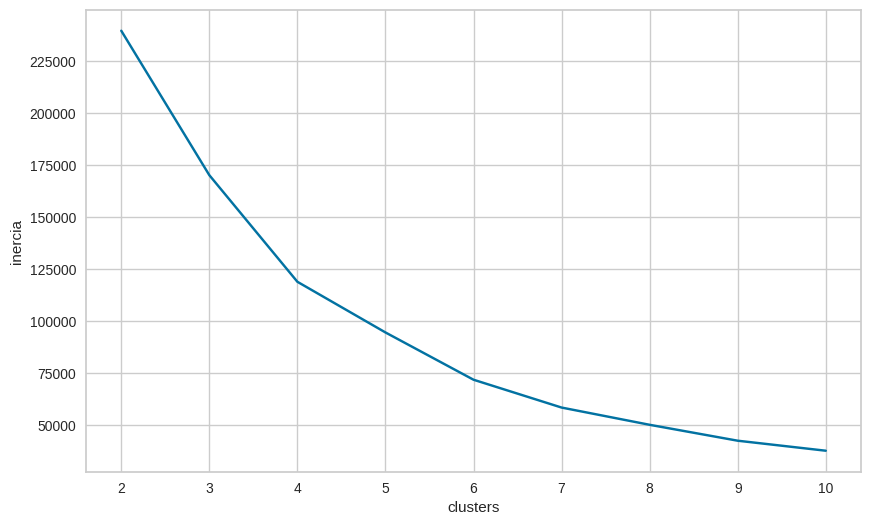

In [ ]:
# Esta función nos arroja tres resultados. El primero es ya visible
scores = calcular_scores(X_std, 2, 11)

**Comentario:** Basandonos solo en la gráfica es difícil individuar el número de clusters que podrían ser usados

In [ ]:
scores[0]

clusters  Regla_matematica_codo  silhouette_score  davies_bouldin_score  \
0         2               1.000000          0.429078              1.290970   
1         3               2.751116          0.493859              0.816548   
2         4               3.782091          0.432359              0.970177   
3         5               3.747209          0.452018              0.858711   
4         6               3.647750          0.528284              0.758828   
5         7               3.177849          0.538335              0.728617   
6         8               2.506332          0.568576              0.691423   
7         9               1.809366          0.589363              0.645078   
8        10               1.000000          0.617354              0.610159   

   calinski_harabasz_score  
0             31077.910827  
1             34185.963650  
2             41267.646797  
3             42791.442452  
4             48851.125372  
5             52295.357729  
6             53626.904830  
7             56681.277738  
8             57633.964807

**lineamentos requeridos:** El puntaje mínimo de Silhouette debe ser de 0.50; el de Davies-Bouldin máximo de 0.75; y el de CalinskiHarabasz, el número más alto posible.

**Insights:** Desde el cluster 7 en adelante se cumplen todos los lineamentos requeridos.

**A continuación se muestra la representación gráfica de los scores obtenidos anteriormente.**

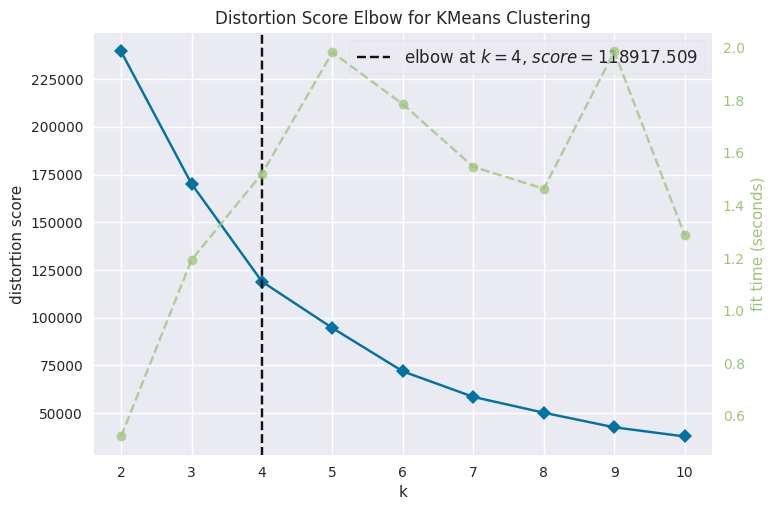

In [ ]:
# En esta gráfica se muestra el score de distorción para el modelo KMeans con respecto al número de clusters.
visualize_distortion_score(X,['tipo'],"distortion",True,True)

# Según la representación visual, el número de clusters optimos a considerar es 4. Ya que es el punto en el cual
# se eviencia la mayor curvatura de la gráfica.

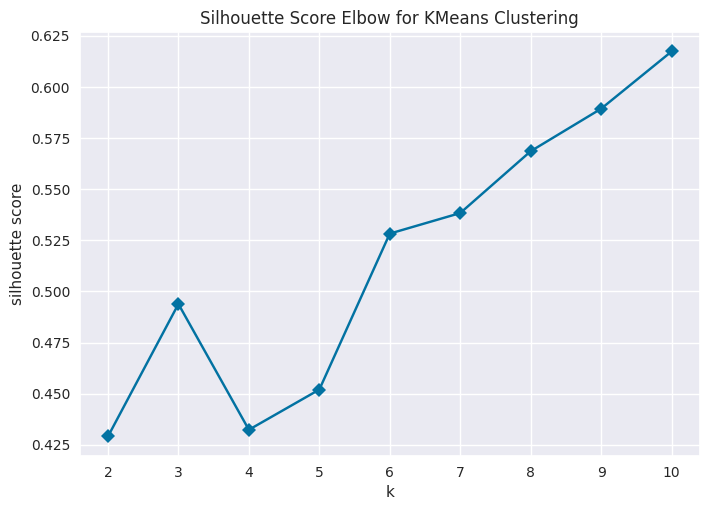

In [ ]:
# En esta grafica se muestra el score de silhouette con respecto al número de clusters
visualize_distortion_score(X,['tipo'],"silhouette",False,False)
# A medida que el número de clusters aumenta, después del 4 cluster, lo hace tambien el score de Silhouette.

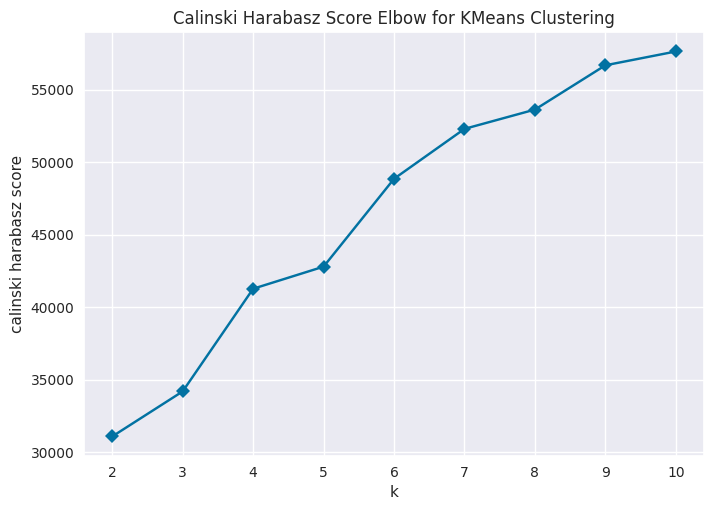

In [ ]:
# En esta grafica se muestra el score de calinski_harabasz con respecto al número de clusters
visualize_distortion_score(X,['tipo'],"calinski_harabasz",False,False)
# A medida que el número de clusters aumenta, lo hace tambien el score de calinski_harabasz

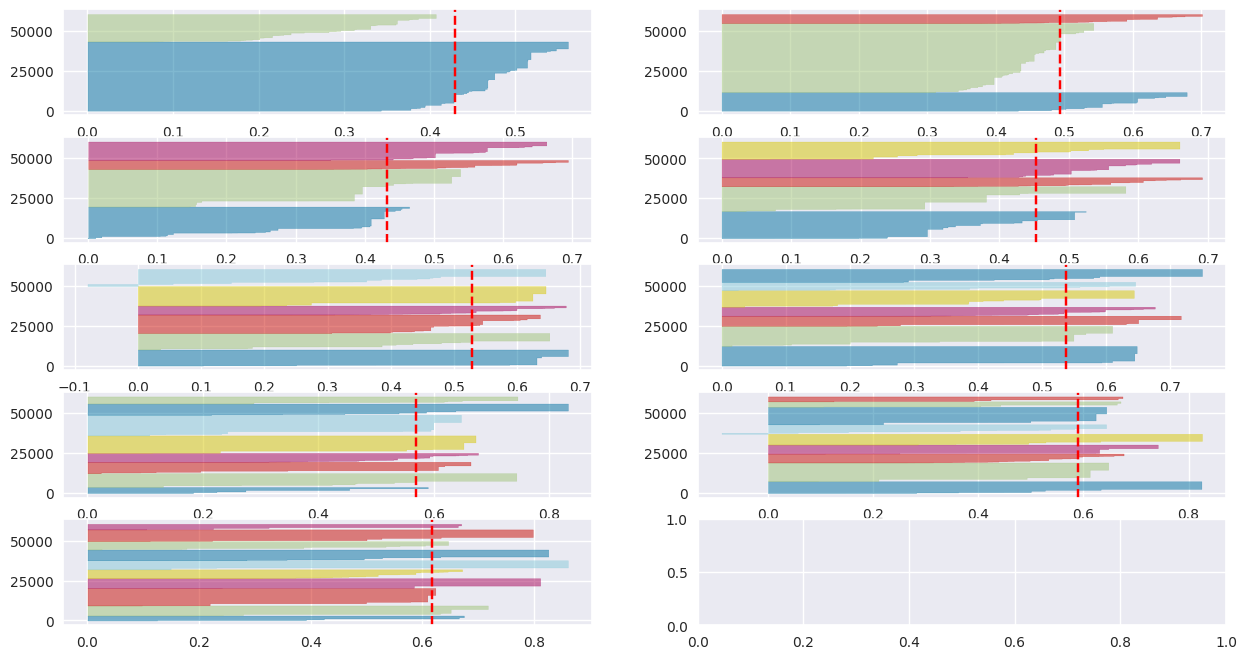

In [ ]:
# Este es un análisis adicional que quise considerar.
plot_SilhouetteVisualizer(X,['tipo'])

Deben comprobarse las siguientes **condiciones para elegir la "K"** correcta utilizando los **gráficos de Silhouette:**

**1.** Para una K determinada, todos los conglomerados deben tener una puntuación Silhouette superior a la puntuación media del conjunto de datos representado por la línea de puntos rojos. El eje x representa la puntuación Silhouette.

**2.** No debería haber grandes fluctuaciones en el tamaño de los conglomerados. La anchura de los conglomerados representa el número de puntos de datos.

**Insight:** para este caso los clusters k=2, k=3 y k=10 no cumplen la primera condición. En cabio los clusters k=2, k=3 y k=4 no cumplen la segunda condición. Adicionalmente, en los clusters k=9 y k=6 se ve que hay un cluster con una parte que se extiende hacia la parte negativa, lo que quiere decir que hay datos en esos clusters que fueron mal clasterizados (tendrían que estar en otro cluster). Entre los clusters k=7 y k=8, visualmente los datos estan mejor agrupados en el cluster **k=7**. Ahora se pocede a realizar la validación de dicho número de clusters.

# 4.1 Validando la estructura de los clusters

---



In [ ]:
len(X_std)

60428

In [ ]:
X_std[0]

array([-1.41266466, -1.13088586, -0.73449876, -0.31867688,  0.62935021,
       -0.48670798])

## 4.1.1 Creando el baseline

In [ ]:
# lista vacía para almacenar los datos generados aleatoriamente
random_data = []

# Iterar sobre un rango de 60428 veces
for _ in range(len(X_std)):  # Usar '_' como variable desechable si no se usa en el bucle
    # Establecer el tamaño del array
    array_size = 6
    # Generar números aleatorios entre -1 y 1
    random_numbers = np.random.uniform(-1, 1, array_size)

    # Agregar los números aleatorios generados a la lista
    random_data.append(random_numbers)


In [ ]:
# Esta función toma un conjunto de datos 'datos' y un numero especifico de clusters.
# Utiliza el algoritmo KMeans para ajustar modelos con el número de clusters indicado y calcula los scores para cada configuración.
# Devuelve un DataFrame con los scores en función del número de clusters.

def calcular_scores_k(datos, n_clusters):
   # Listas para almacenar los resultados

  sil_score_list=[]
  dbi_score_list=[]
  ch_score_list=[]

  # Inicializar y ajustar el modelo de KMeans
  kmeans= KMeans(n_clusters=n_clusters, random_state=42)
  clusters=kmeans.fit_predict(X=datos)

  # Calcular el silhouette score y añadirlo a la lista
  sil_score = silhouette_score(datos,clusters)
  sil_score_list.append(sil_score)

  # Calcular el Davies-Bouldin score y añadirlo a la lista
  dbi_score = davies_bouldin_score(datos, clusters)
  dbi_score_list.append(dbi_score)

  # Calcular el Calinski-Harabasz score y añadirlo a la lista
  ch_score = calinski_harabasz_score(datos, clusters)
  ch_score_list.append(ch_score)


  # Crear un DataFrame con los scores y la regla matemática del codo
  df_scores=pd.DataFrame({'clusters':n_clusters,
                            'silhouette_score':sil_score_list,'davies_bouldin_score':dbi_score_list,
                            'calinski_harabasz_score':ch_score_list})

  # Devuelve el df_scores
  return df_scores

In [ ]:
calcular_scores_k(random_data,7)

clusters  silhouette_score  davies_bouldin_score  calinski_harabasz_score
0         7          0.122394               1.66779              6222.488084

**Comentario:** Los valores de los scores obtenidos del modelo escogído son superiores a los de la baseline.

Para **k=7** los valores de los scores del modelo escogído son los siguientes: **silhouette_score:** 0.538335, **davies_bouldin_score:** 0.728617, y **calinski_harabasz_score:** 52295.357729.




# 4.2 Validando la estabilidad de los clusters


---



In [ ]:
sub_arrays = np.array_split(X_std, 3)

In [ ]:
len(sub_arrays)

3

In [ ]:
for array in sub_arrays:
  score = calcular_scores_k(array,7)
  print(score)

   clusters  silhouette_score  davies_bouldin_score  calinski_harabasz_score
0         7          0.545666              0.687903             16204.982759
   clusters  silhouette_score  davies_bouldin_score  calinski_harabasz_score
0         7          0.525829              0.775095             18244.469035
   clusters  silhouette_score  davies_bouldin_score  calinski_harabasz_score
0         7          0.538706              0.735658             18542.511285


In [ ]:
# Scores del modelo escogído
silhouette_score = 0.538335
davies_bouldin_score = 0.728617

In [ ]:
# Diferencia del score de silhuoette entre el modelo original y los diferentes segmentos del dataset
print(0.545666-silhouette_score, 0.525829-silhouette_score, 0.538706-silhouette_score)

0.007330999999999976 -0.012506000000000017 0.0003710000000000102


In [ ]:
# Diferencia del score de davies-bouldin entre el modelo original y los diferentes segmentos del dataset

print(0.687903-davies_bouldin_score, 0.775095-davies_bouldin_score, 0.735658-davies_bouldin_score)

-0.04071399999999992 0.04647800000000002 0.007041000000000075


**Insight**: Los puntajes no presenten una variación mayor a ±5% entre sí.

# 4.3 Instanciando los clusters: k=7

In [ ]:
datos_raw=df.copy()

In [ ]:
len(scores[2][7][0])

60428

In [ ]:
datos_raw['cluster']=scores[2][7][0]
datos_raw.head()

categoria_alimento          departamento    tipo  \
0  Alimentos para el desayuno  Alimentos congelados  Comida   
1  Alimentos para el desayuno  Alimentos congelados  Comida   
2  Alimentos para el desayuno  Alimentos congelados  Comida   
3  Alimentos para el desayuno  Alimentos congelados  Comida   
4  Alimentos para el desayuno  Alimentos congelados  Comida   

   ventas_tienda(en millones)  costo_tienda(en millones)  \
0                        7.36                     2.7232   
1                        5.52                     2.5944   
2                        3.68                     1.3616   
3                        3.68                     1.1776   
4                        4.08                     1.4280   

   ventas_unitarias(en millones)                        promocion  \
0                            4.0                    Bolsas llenas   
1                            3.0  Lotería de la caja registradora   
2                            2.0  Ahorro para apostadores grandes   
3                            2.0  Lotería de la caja registradora   
4                            3.0                      Venta Doble   

             pais estado_civil     genero  total_de_hijos escolaridad miembro  \
0  Estados Unidos       Casado   Femenino             1.0    Primaria     NaN   
1  Estados Unidos       Casado  Masculino             0.0    Superior   Plata   
2  Estados Unidos      Soltero   Femenino             4.0    Primaria     NaN   
3  Estados Unidos       Casado   Femenino             2.0  Secundaria  Bronce   
4  Estados Unidos       Casado  Masculino             0.0    Primaria  Bronce   

     ocupacion vivienda_propia  promedio_autos(aprox)  ingreso_anual  \
0      Técnico              Sí                    1.0          20000   
1  Profesional              Sí                    4.0          60000   
2       Obrero              No                    1.0          20000   
3       Obrero              Sí                    2.0          40000   
4      Técnico              No                    2.0          40000   

   numero_hijos       marca  precio_recomendado  peso_bruto  peso_neto  \
0           1.0  Carrington                1.84       19.70      17.70   
1           0.0  Carrington                1.84       19.70      17.70   
2           0.0  Carrington                1.84       19.70      17.70   
3           2.0  Carrington                1.84       19.70      17.70   
4           0.0      Golden                1.36        7.12       5.11   

   empaque_reciclable  bajo_en_grasa  unidades_por_caja              comercio  \
0                 1.0            0.0               17.0  Supermercado de lujo   
1                 1.0            0.0               17.0  Supermercado de lujo   
2                 1.0            0.0               17.0  Supermercado de lujo   
3                 1.0            0.0               17.0  Supermercado de lujo   
4                 0.0            1.0               29.0  Supermercado de lujo   

  ciudad estado  pies_cuadrados_tienda  pies_cuadrados_comestibles  \
0  Salem     OR                27694.0                     18670.0   
1  Salem     OR                27694.0                     18670.0   
2  Salem     OR                27694.0                     18670.0   
3  Salem     OR                27694.0                     18670.0   
4  Salem     OR                27694.0                     18670.0   

   pies_cuadrados_congelados  pies_cuadrados_carne  cafeteria  \
0                     5415.0                3610.0        1.0   
1                     5415.0                3610.0        1.0   
2                     5415.0                3610.0        1.0   
3                     5415.0                3610.0        1.0   
4                     5415.0                3610.0        1.0   

   tienda_de_videos  barra_de_ensaladas  comida_preparada  floristeria  \
0               1.0                 1.0               1.0          1.0   
1               1.0                 1.0     

# 5.  Descripción de los clusters

In [ ]:
def plot_clusters(x, y, datos):
    # Crear una figura con un tamaño específico
    plt.figure(figsize=(10, 6))

    # Paleta de colores para los clusters
    palette = ["#F72585", "#764703", "#3A0CA3", "#4361EE", "#4CC9F0", '#FDC507', '#FF0013']

    # Establecer el estilo de la cuadrícula y los códigos de color
    sns.set(color_codes=True, style='whitegrid')

    # Gráfico de dispersión con colores según los clusters
    scatter_plot = sns.scatterplot(x=x, y=y, hue='cluster',data=datos,palette=palette)

    # Mover la leyenda fuera del área del gráfico
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Mostrar el gráfico
    plt.show()

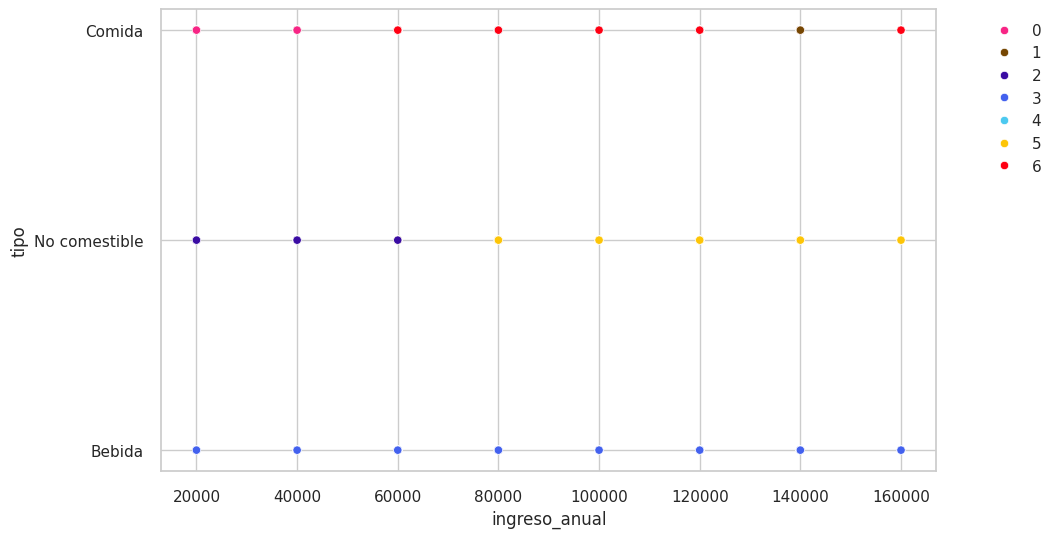

In [ ]:
# A continuación se hace una series de gráficos para individuar las características de cada cluster
plot_clusters('ingreso_anual','tipo',datos_raw)

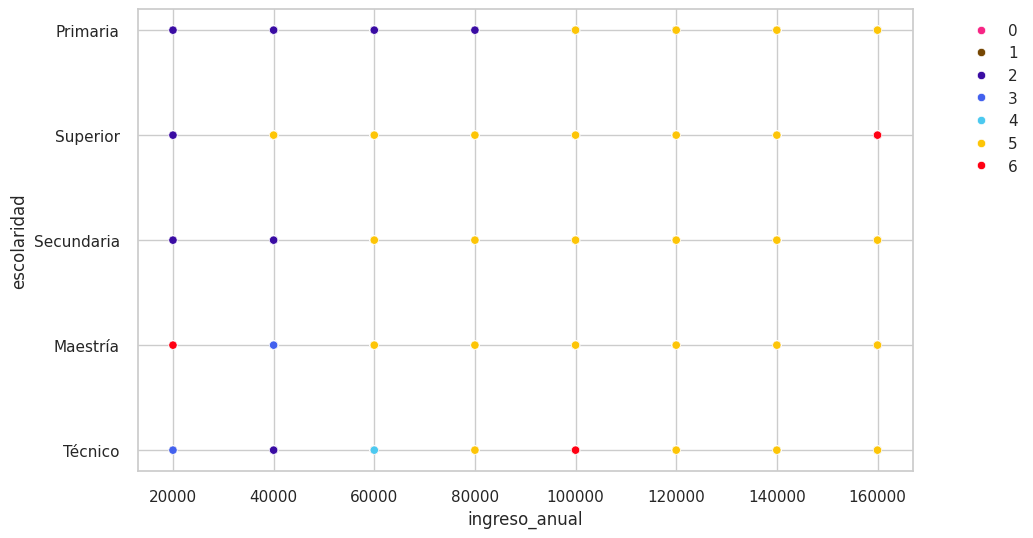

In [ ]:
plot_clusters('ingreso_anual',"escolaridad",datos_raw)

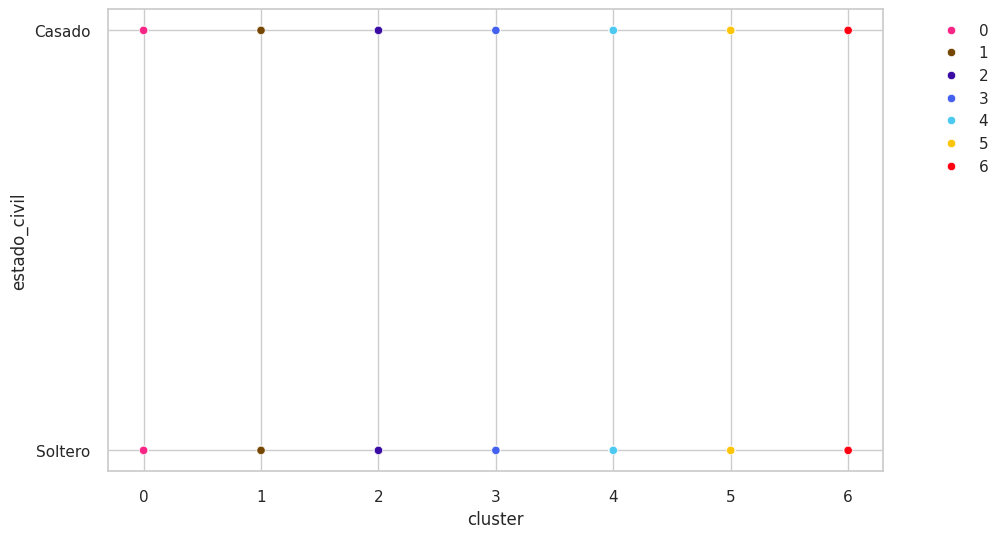

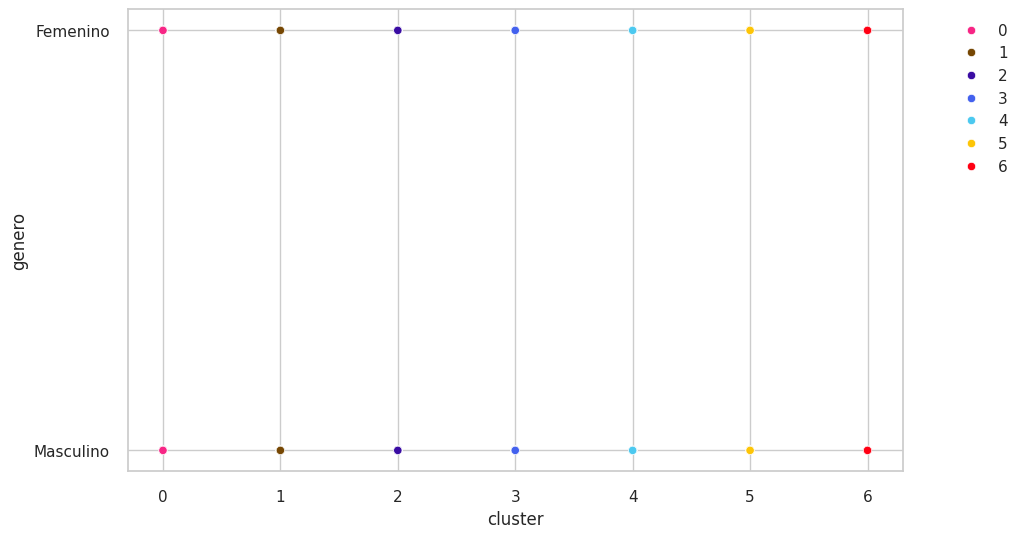

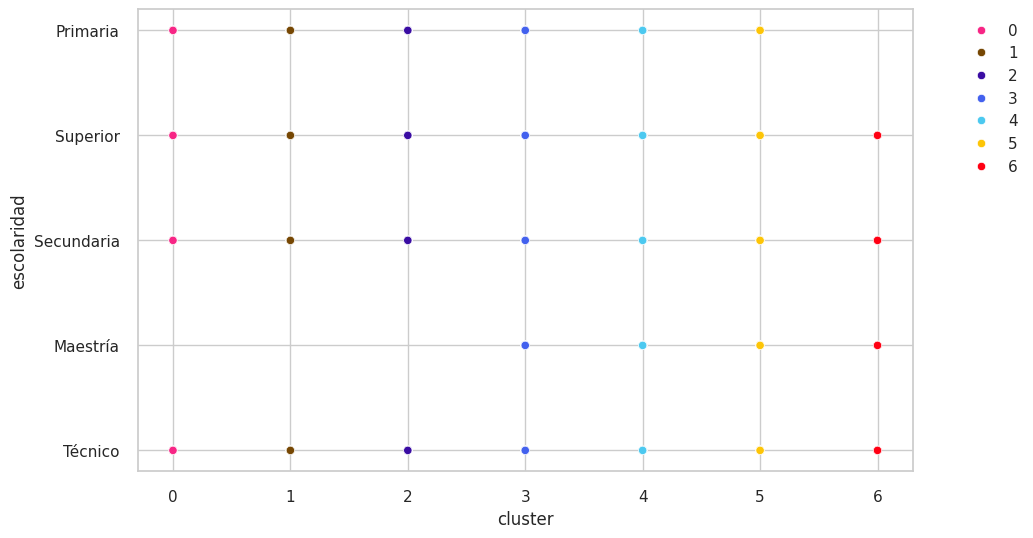

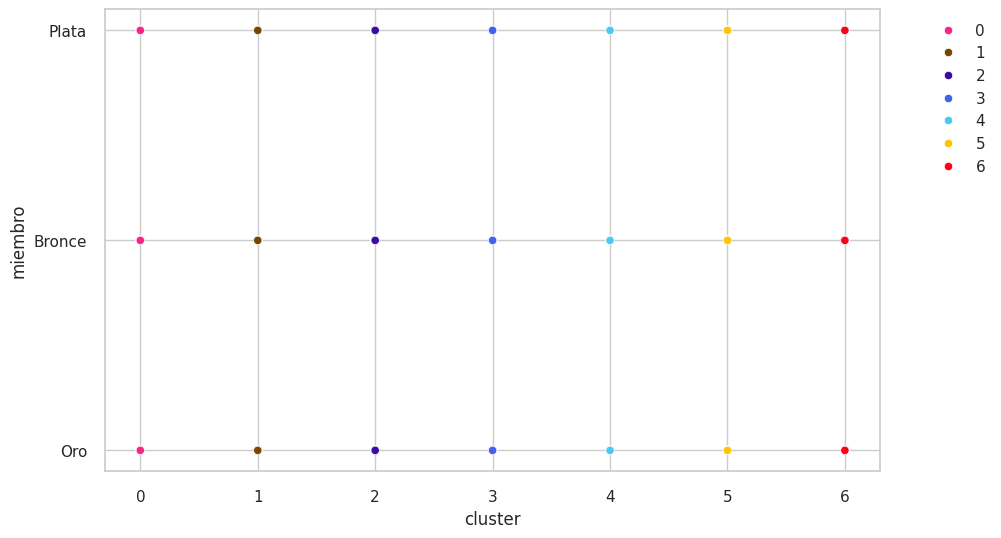

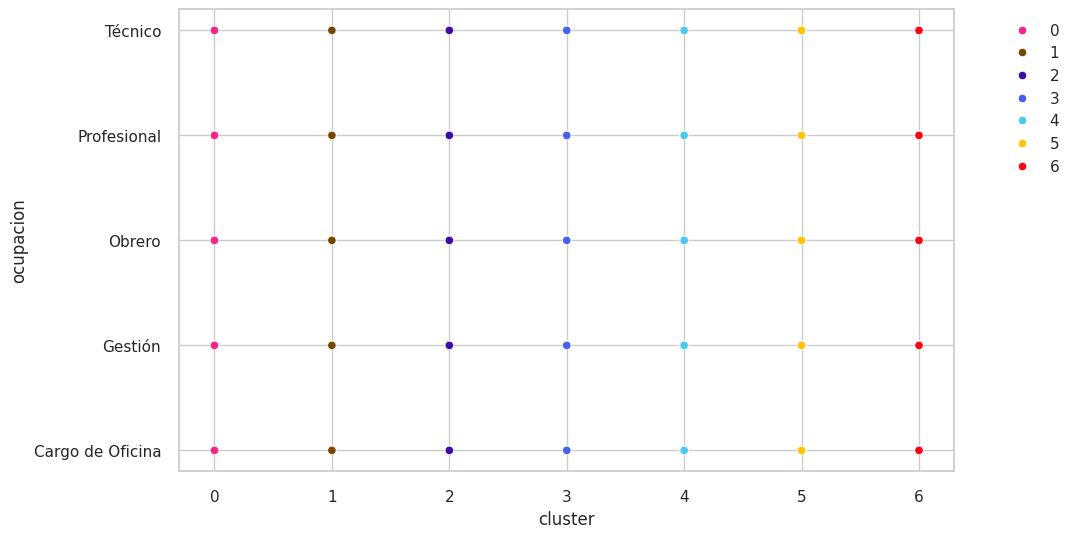

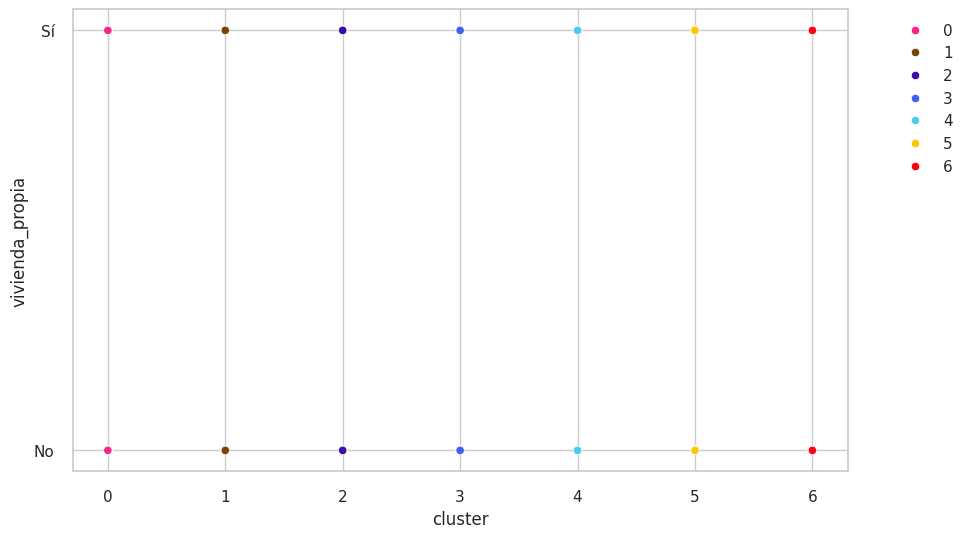

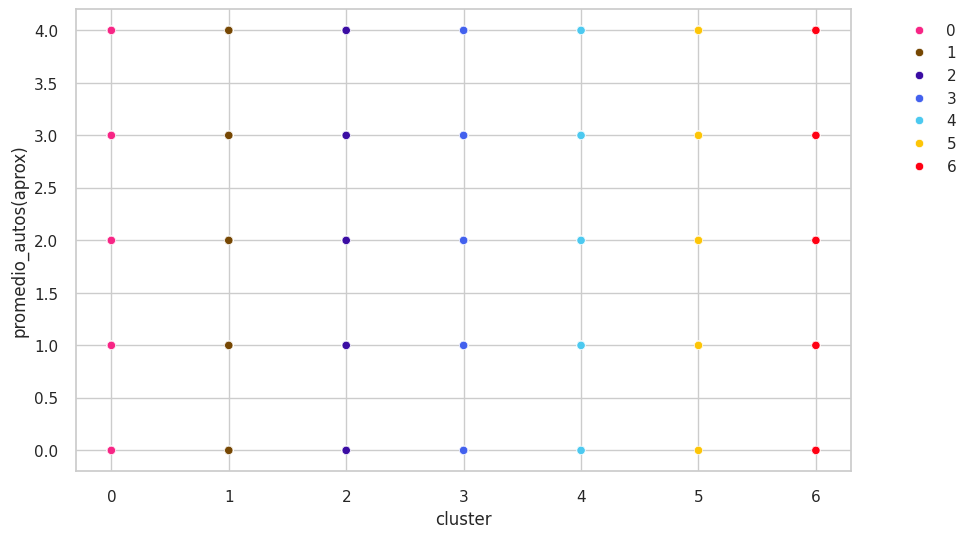

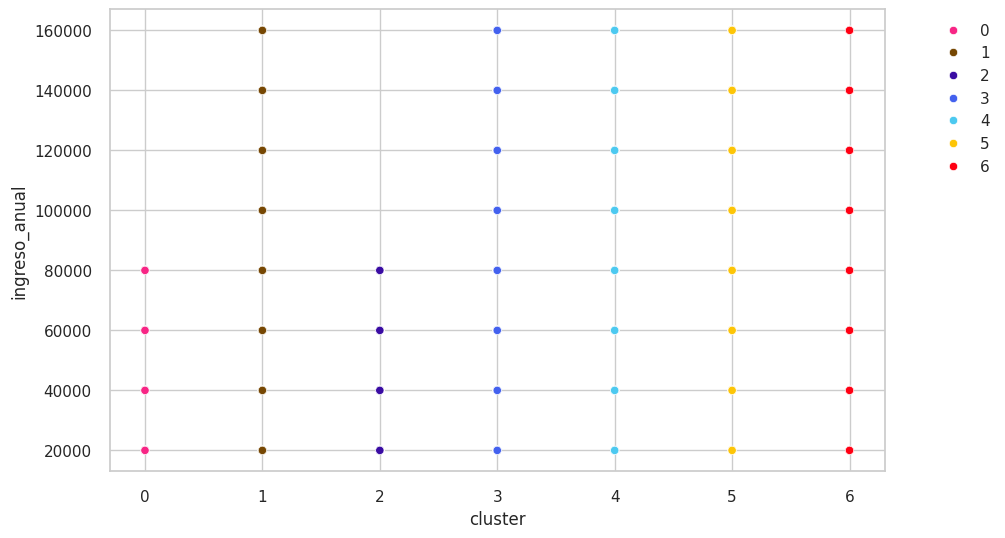

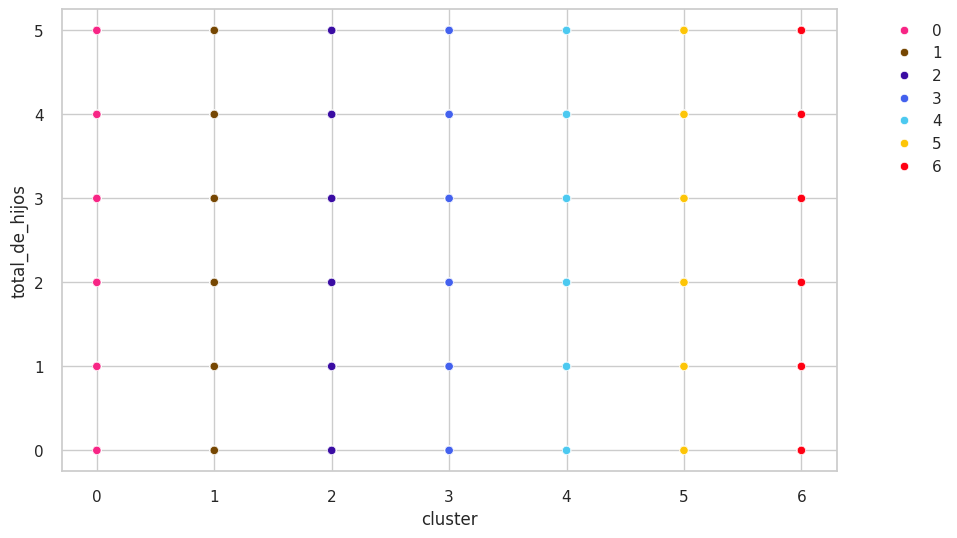

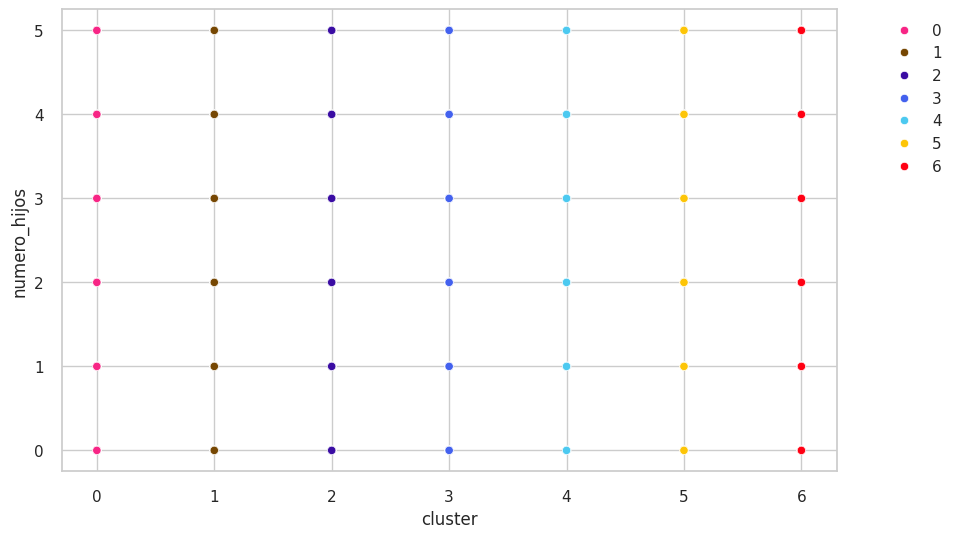

In [ ]:
for column in customer_columns:
  plot_clusters('cluster',column,datos_raw)

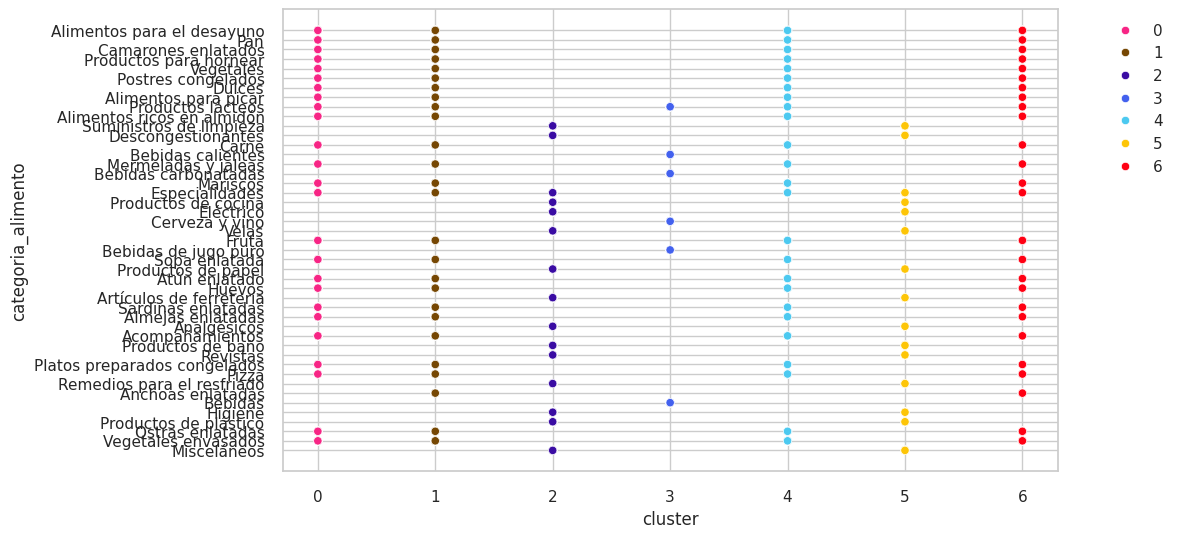

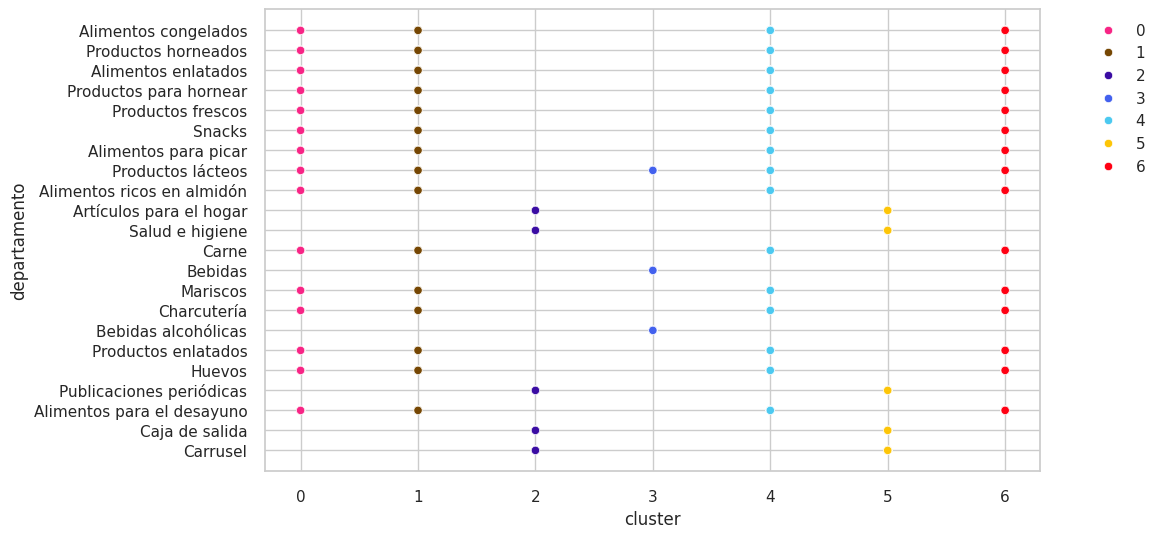

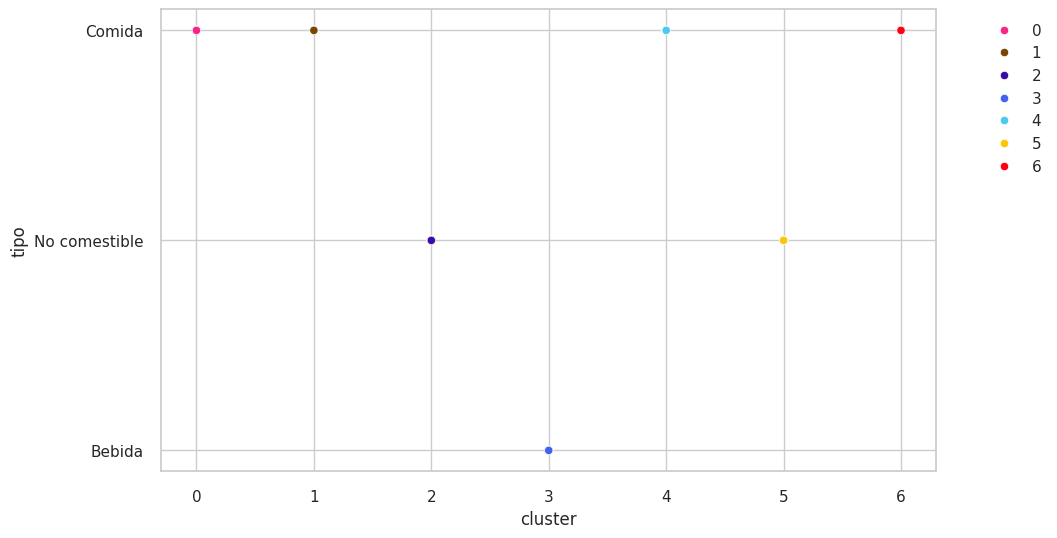

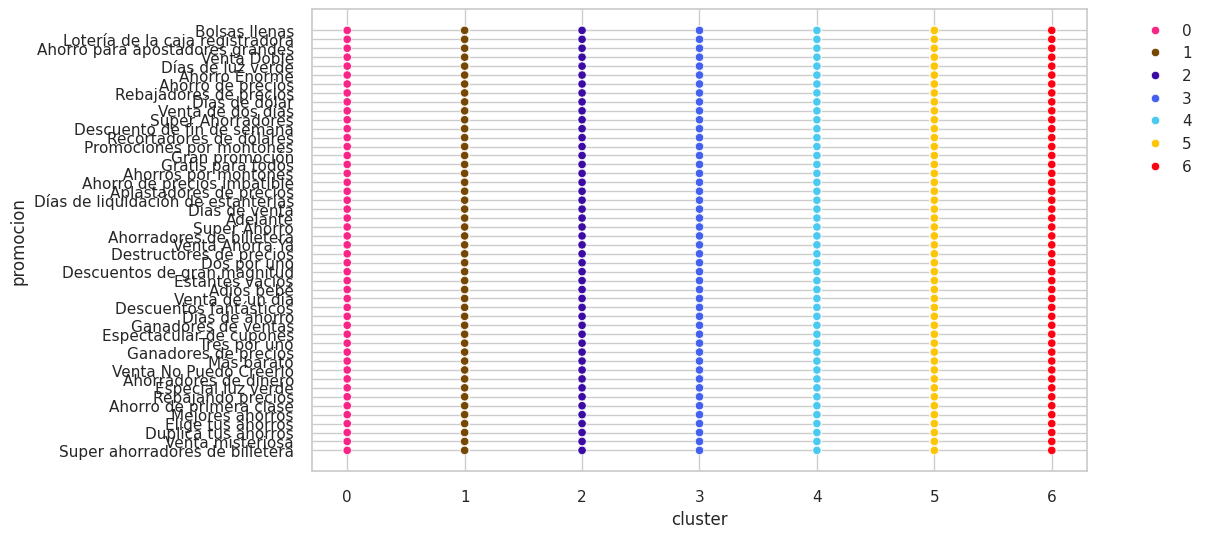

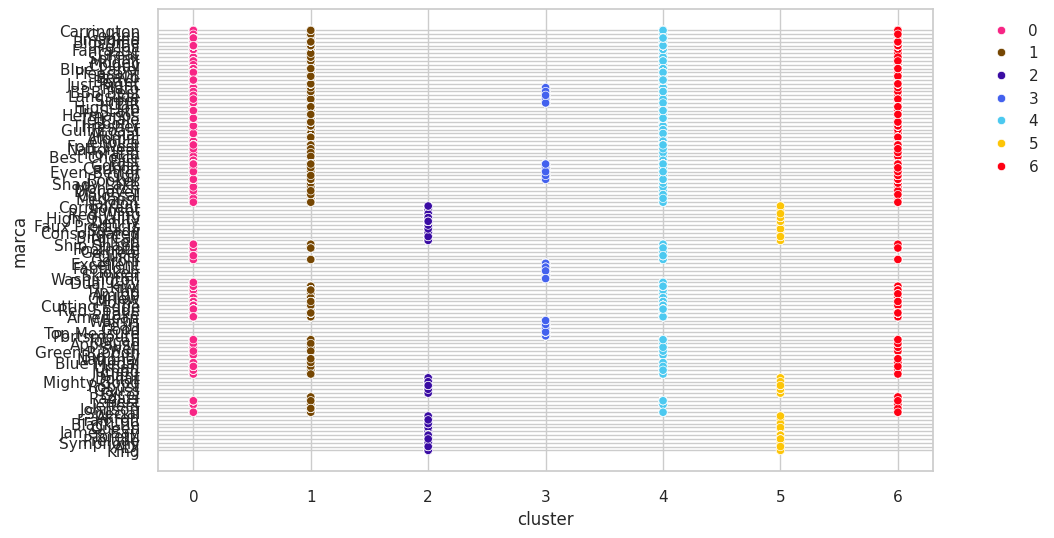

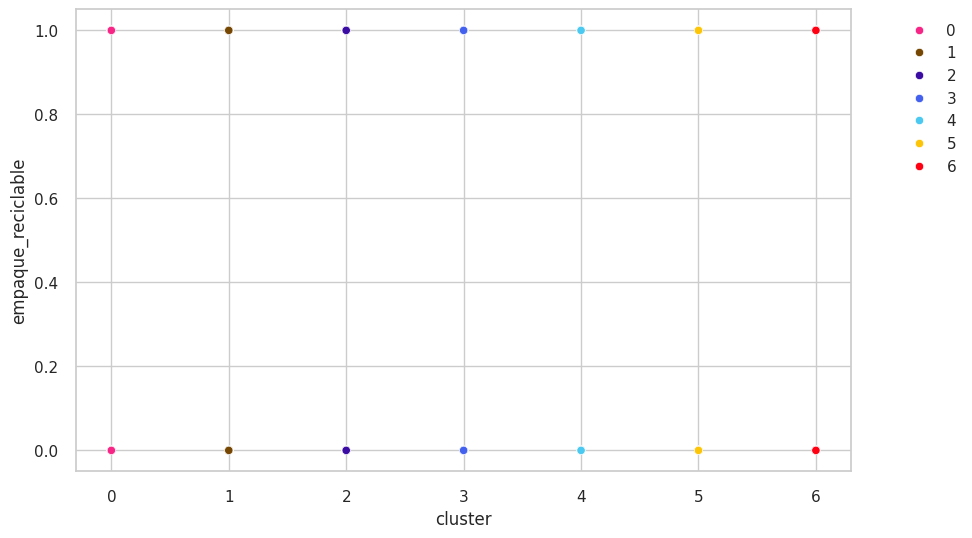

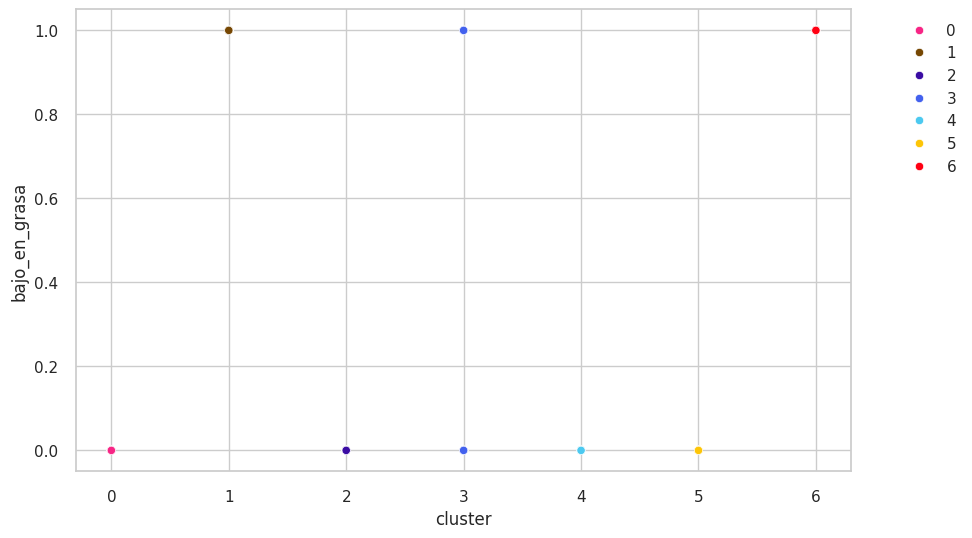

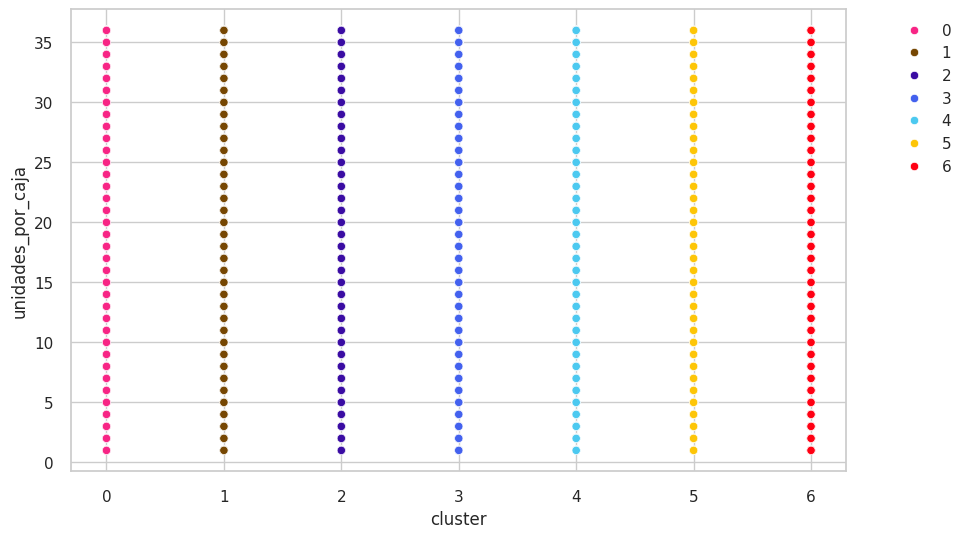

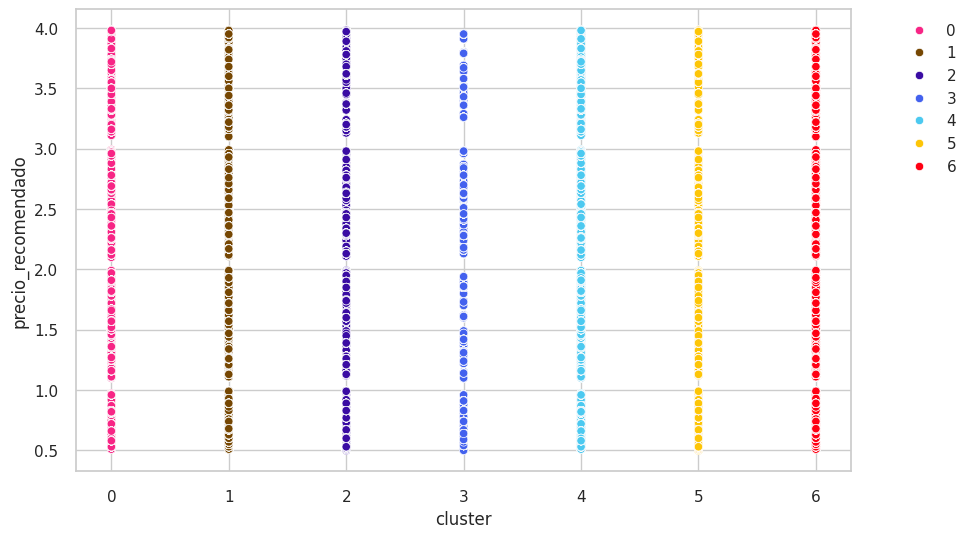

In [ ]:
for column in products_columns:
  plot_clusters('cluster',column,datos_raw)

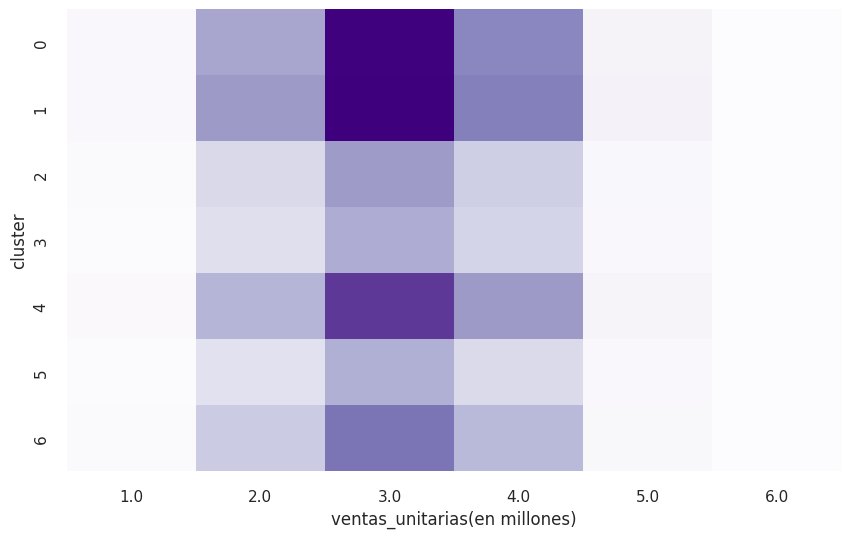

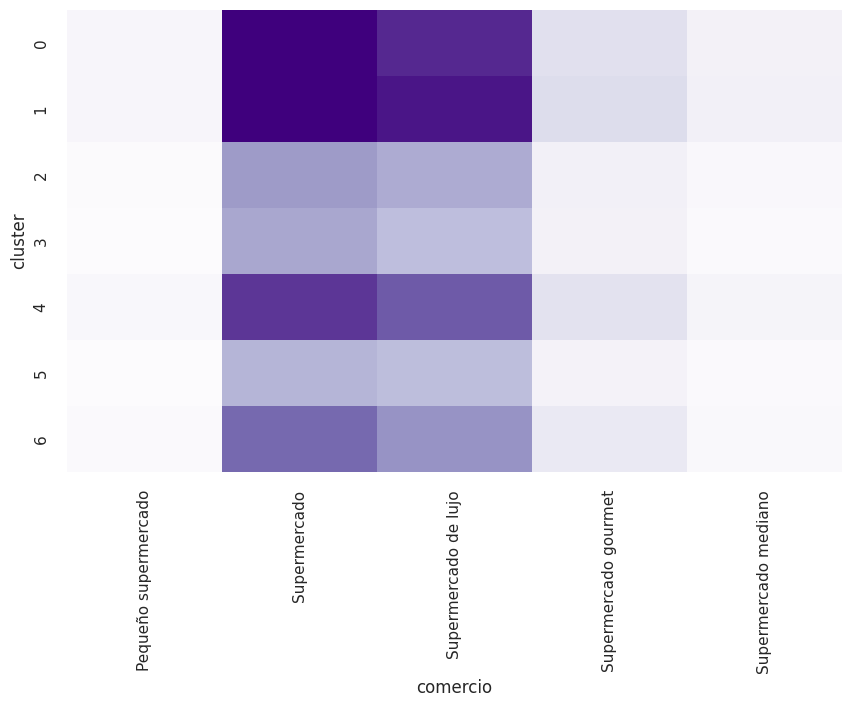

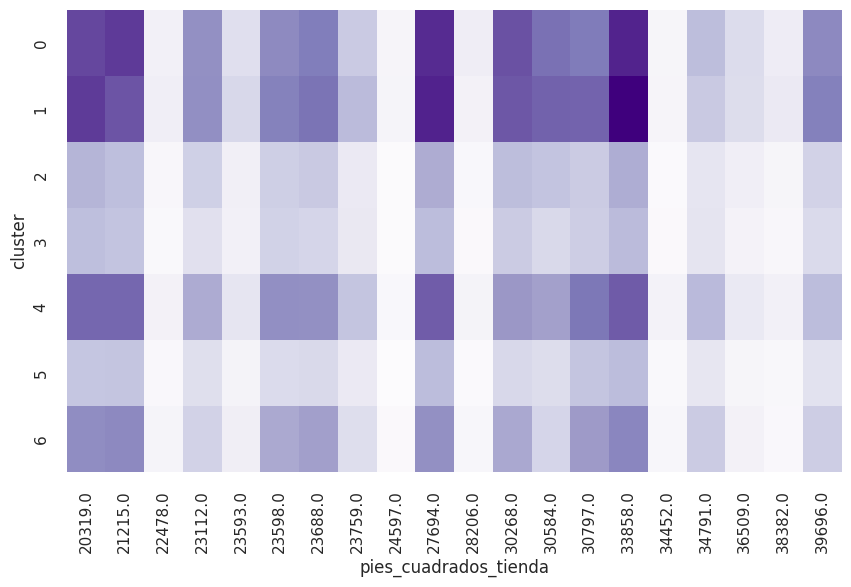

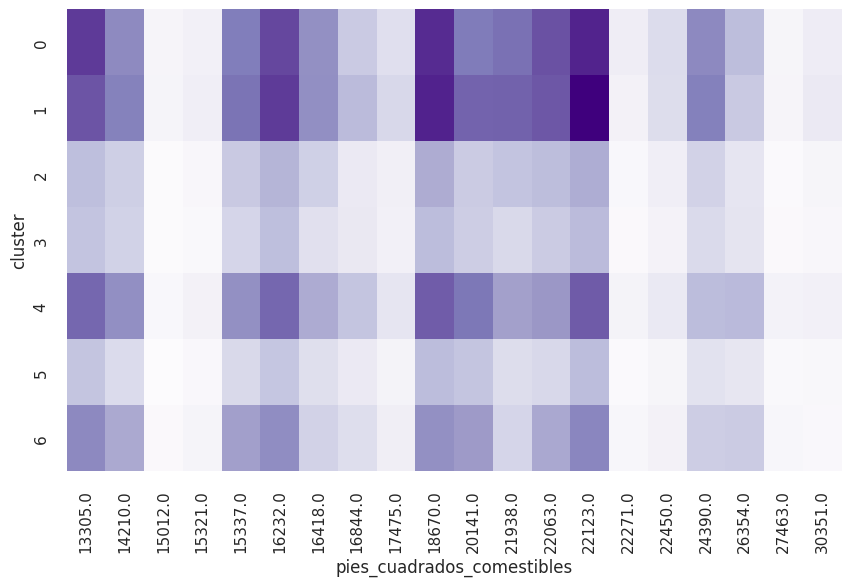

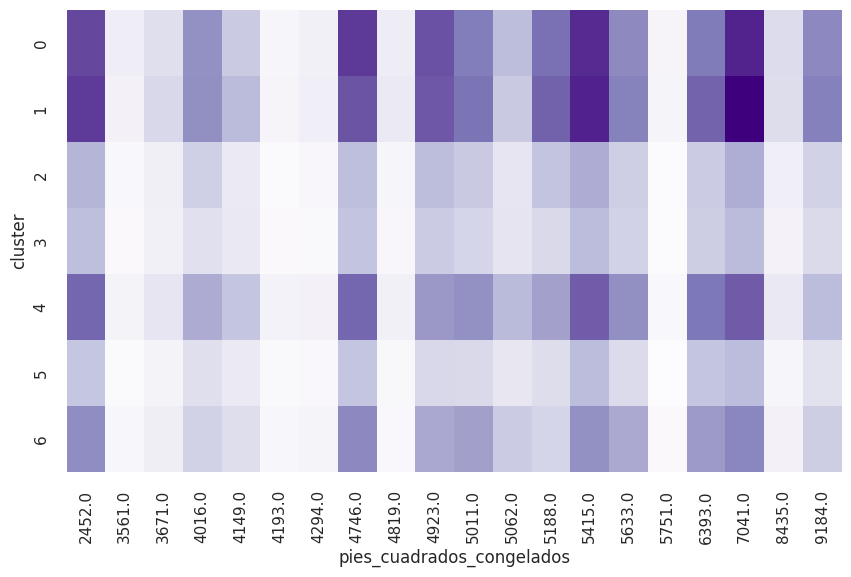

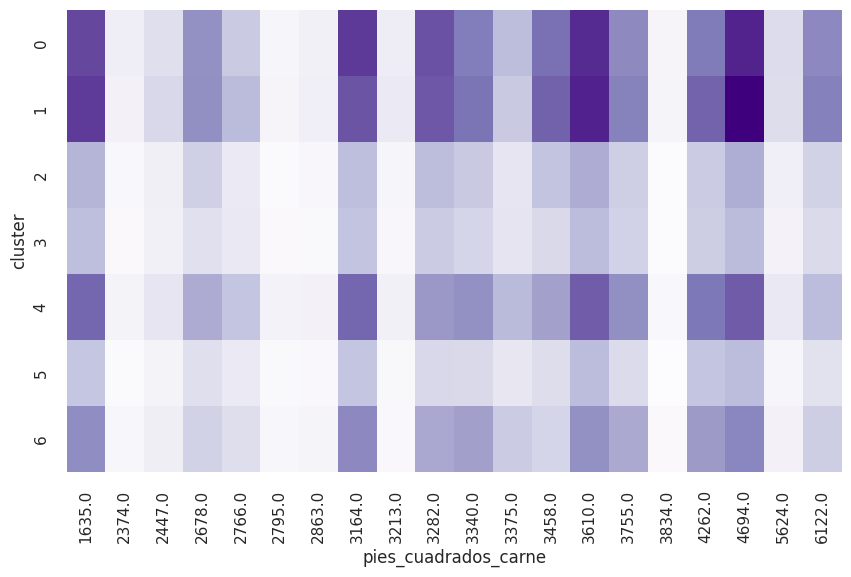

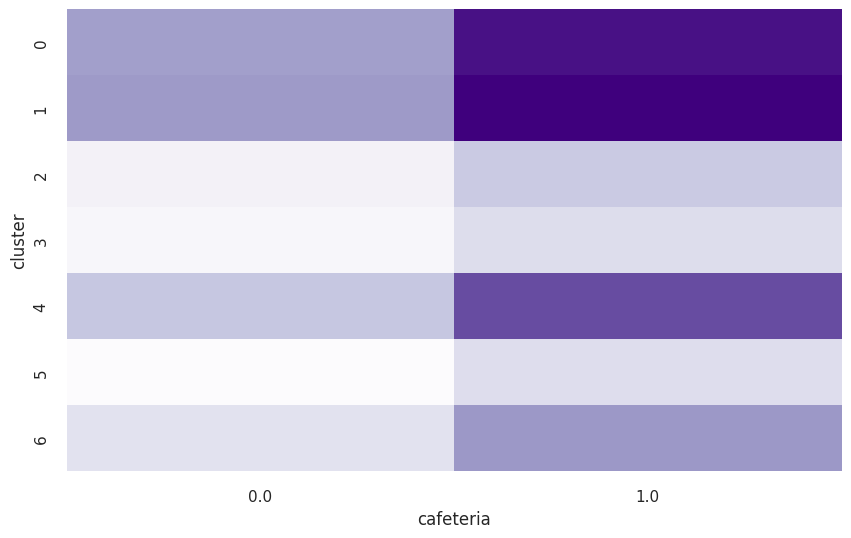

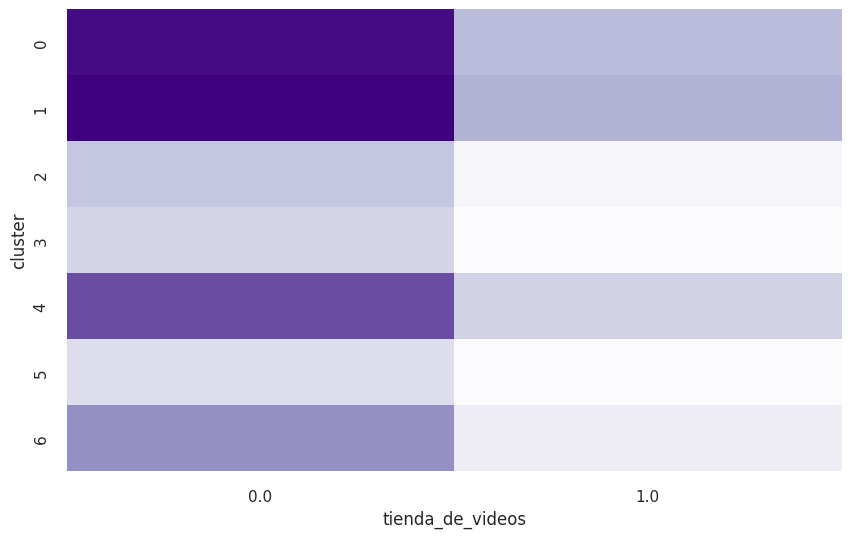

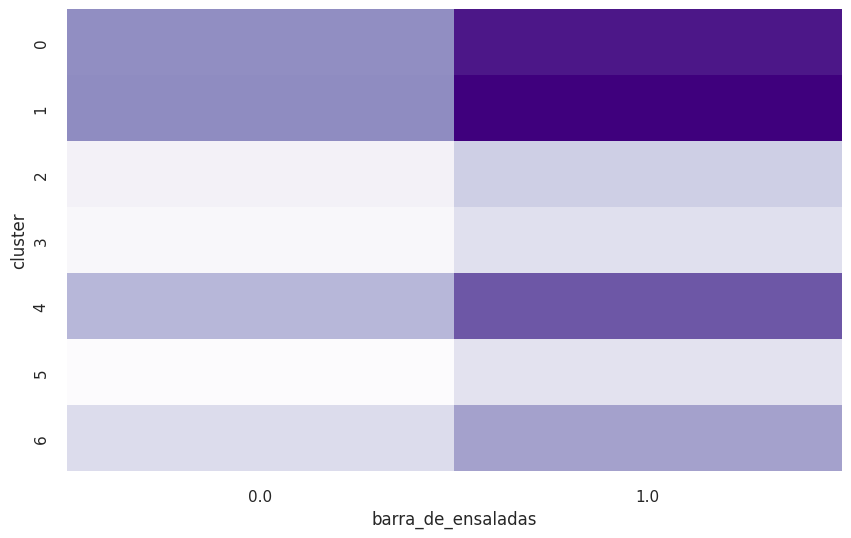

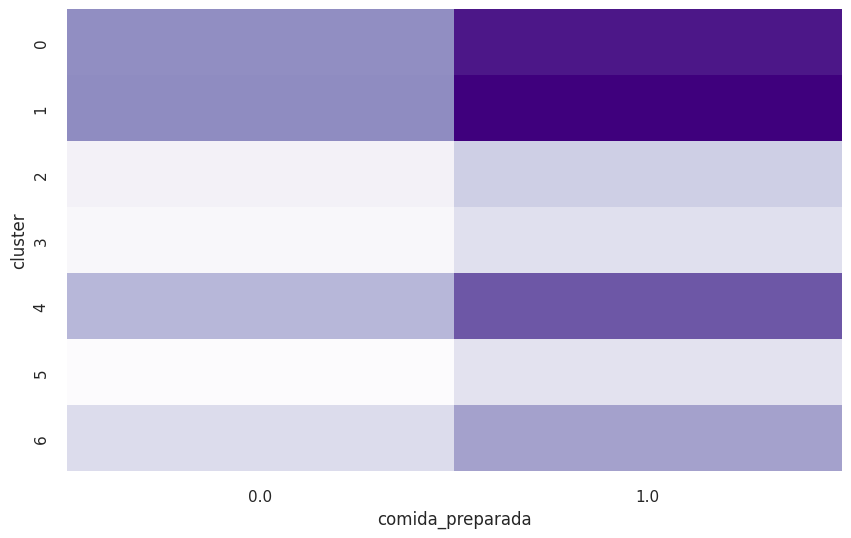

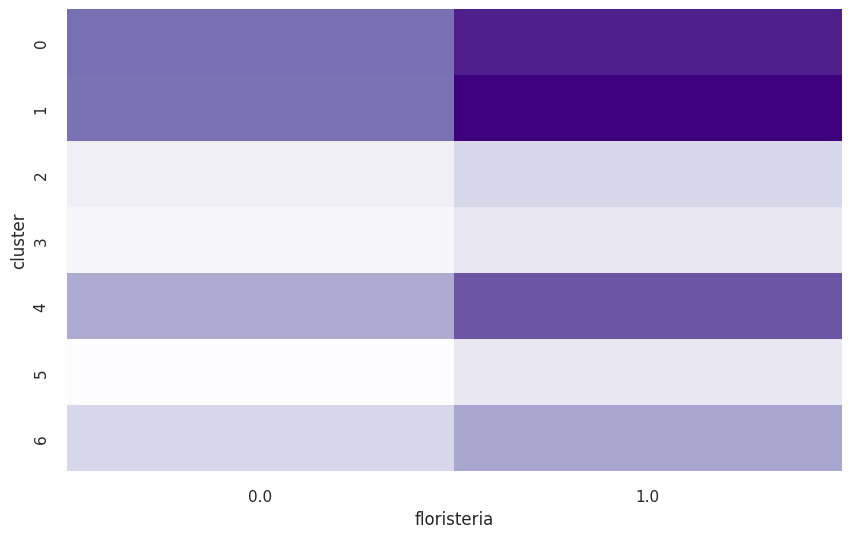

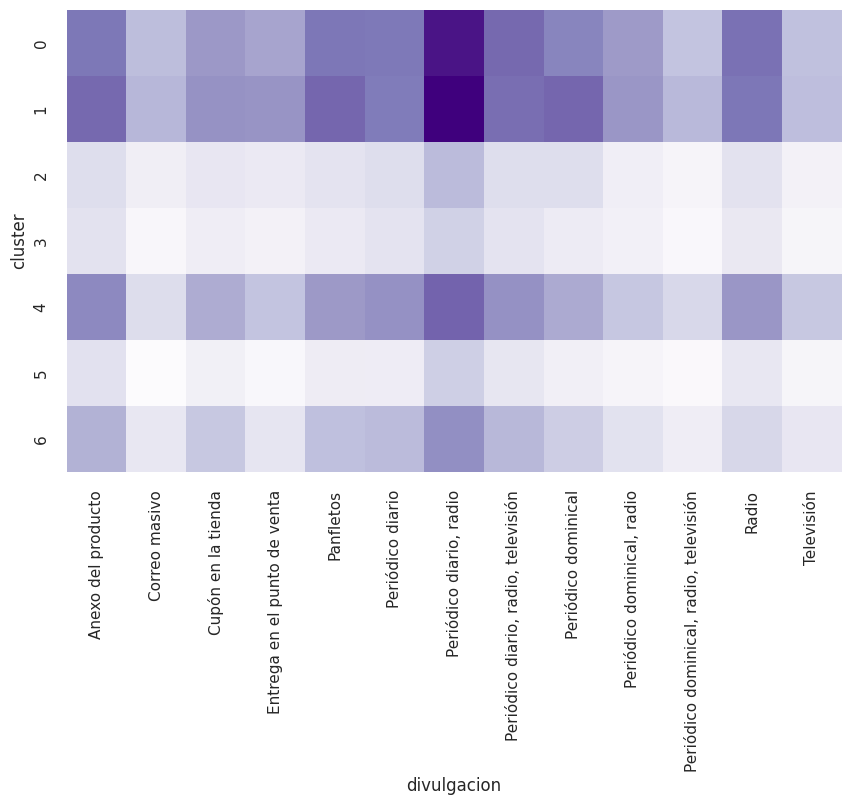

In [ ]:
categorical_crosstable(datos_raw,'cluster',stores_columns,'Purples',False)

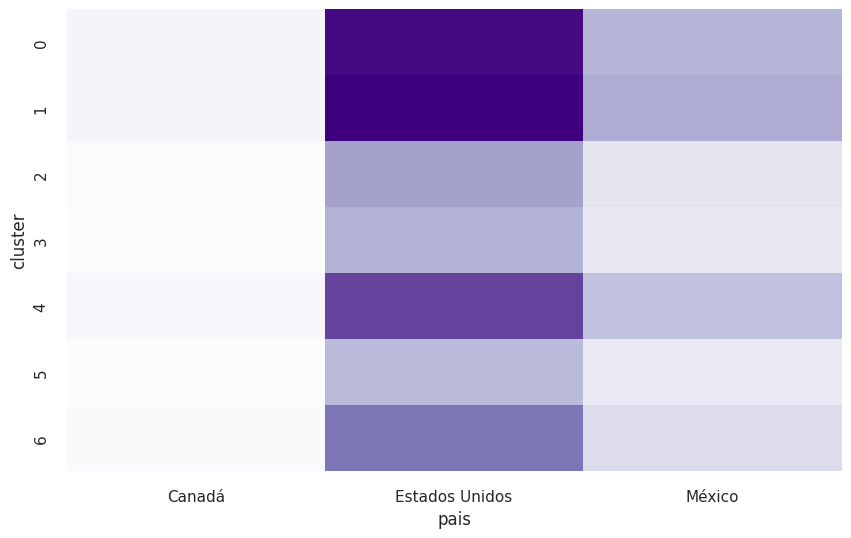

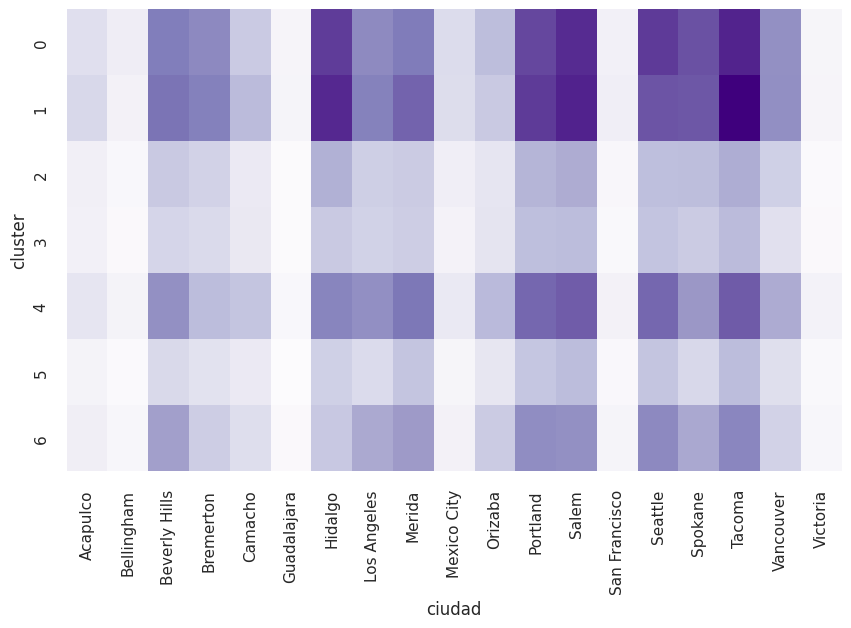

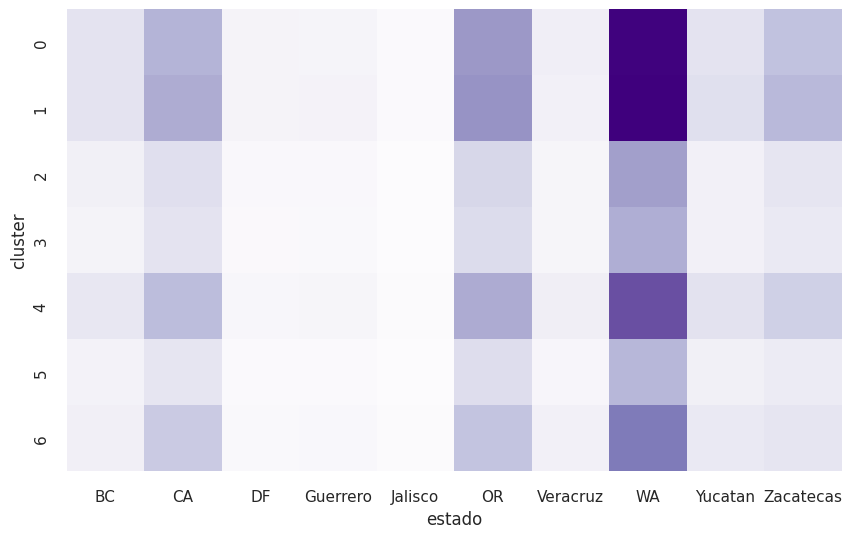

In [ ]:
categorical_crosstable(datos_raw,'cluster',geographic_columns,'Purples',False)

**Insights:**

**Cluster 0:** No incluida escolaridad maestria, menos de $8000 anuales. No bajo en grasa.

**Cluster 1:** No incluida escolaridad maestria. Bajo en grasa.

**Cluster 2:** No incluida escolaridad maestria, menos de $8000 anuales. No bajo en grasa

**Cluster 3:** Unicos que compran bebidas.

**Cluster 4:** No bajo en grasa.

**Cluster 5:** No bajo en grasa.

**Cluster 6:** No incluida escolaridad primaria. Bajo en grasa.




**Los clusters 0, 1, 4 y 6 compran los siguientes productos:**

'Alimentos congelados', 'Productos horneados',
       'Alimentos enlatados', 'Productos para hornear',
       'Productos frescos', 'Snacks', 'Alimentos para picar',
       'Productos lácteos', 'Alimentos ricos en almidón', 'Carne',
       'Mariscos', 'Charcutería', 'Productos enlatados', 'Huevos',
       'Alimentos para el desayuno'


**Los clusters 2 y 5 compran los siguientes productos:**

'Artículos para el hogar', 'Salud e higiene',
       'Publicaciones periódicas', 'Caja de salida', 'Carrusel'


**El cluster 3 compra los siguientes productos:**

'Bebidas', 'Productos lácteos', 'Bebidas alcohólicas'


**Dado que en el modelo de clasterización no se tuvieron en cuenta las variables de las tiendas ni geográficas no se evidencias valiosos insights en la clasificación de los clusters.**  

## 5.1 Posibles estrategias a implementar

**Cluster 0:**

1. Al interno de la membresía que tienen los clientes se podrían realizar promociones de artículos que no tengan precios altos,sobretodo en los que no son bajos en grasa.

2. Elaborar una campaña dirigida a estos clientes para que también compren bebidas y productos no comestibles.

3. Por la gran variedad de productos que son comprados por los clientes de este cluster, se recomienda tener un trato especial. Agancharlos si no son todavía miembros. Si ya lo son, hacerles notar los beneficios que tienen!

**Cluster 1:**

1. Al interno de la membresía que tienen los clientes se podrían realizar promociones en articulos dietéticos y fitness.

2. Hacer notar los beneficios que se tienen al pertenecer a una membresía más alta.

3. Elaborar una campaña dirigida a estos clientes para que también compren bebidas y productos no comestibles.

**Cluster 2:**

1. Al interno de la membresía que tienen los clientes se podrían realizar promociones de artículos que no tengan precios altos,sobretodo en los que no son bajos en grasa.

2. Elaborar una campaña dirigida a estos clientes para que también compren bebidas y productos de comida. Por ejemplo, si hace una compra con un valor mayor a $... se le dá un bono de un cierto valor para que pueda comprar productos de comida o bebida.

**Cluster 3:**

1. En la parte del supermercado en la cual se exponen los diferentes tipos de bebidas se podrían colocar confecciones de bebidas y alimentos juntas en forma de promoción, para así incentivar la compra de otro tipo de productos.

2. Si el cliente realiza grandes compras en bebidas regularmente, se podría realizar la campaña de bonos mencionada en el cluster anterior. Si hace una compra con un valor mayor a $... se le dá un bono de un cierto valor para que pueda comprar productos de comida o productos para el hogar.

**Cluster 4 y 6:**

1. Al interno de la membresía que tienen los clientes se podrían realizar promociones de artículos que no tengan precios altos,sobretodo en los que no son bajos en grasa.

2. Elaborar una campaña dirigida a estos clientes para que también compren bebidas y productos no comestibles.

3. Por la gran variedad de productos que son comprados por los clientes de este cluster, se recomienda tener un trato especial. Agancharlos si no son todavía miembros. Si ya lo son, hacerles notar los beneficios que tienen!

4. Hacer notar los beneficios que se tienen al pertenecer a una membresía más alta.

**Cluster 5:**

1. Al interno de la membresía que tienen los clientes se podrían realizar promociones de artículos que no tengan precios altos,sobretodo en los que no son bajos en grasa.

2. Elaborar una campaña dirigida a estos clientes para que también compren bebidas y productos de comida. Por ejemplo, si hace una compra con un valor mayor a $... se le dá un bono de un cierto valor para que pueda comprar productos de comida o bebida.

3. Hacer notar los beneficios que se tienen al pertenecer a una membresía más alta.

# 6. Bonus - KPrototypes

In [ ]:
X.head()

ingreso_anual  escolaridad    tipo  bajo_en_grasa
0              1            1  Comida            0.0
1              3            4  Comida            0.0
2              1            1  Comida            0.0
3              2            2  Comida            0.0
4              2            1  Comida            1.0

In [ ]:
x_prototypes = X.copy()

In [ ]:
# getting categorical columns and their indices.
catColumnsPos = [x_prototypes.columns.get_loc(col) for col in list(x_prototypes.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(x_prototypes.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['tipo']
Categorical columns position  : [2]


In [ ]:
df_matrix = x_prototypes.to_numpy()

In [ ]:
cost = []
for i in range(2,11):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = i, init = 'Huang', random_state = 42)
    clusters = kprototype.fit_predict(df_matrix, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('Cluster initiation: {}'.format(clusters))

Cluster initiation: [1 0 1 ... 1 0 1]
Cluster initiation: [0 2 0 ... 0 2 0]
Cluster initiation: [3 0 3 ... 1 0 3]
Cluster initiation: [1 2 1 ... 3 2 1]
Cluster initiation: [3 0 3 ... 4 0 3]
Cluster initiation: [6 1 6 ... 4 1 6]
Cluster initiation: [6 3 6 ... 5 3 6]
Cluster initiation: [8 1 8 ... 6 1 8]
Cluster initiation: [0 3 0 ... 2 3 0]


<Axes: xlabel='clusters', ylabel='cost'>

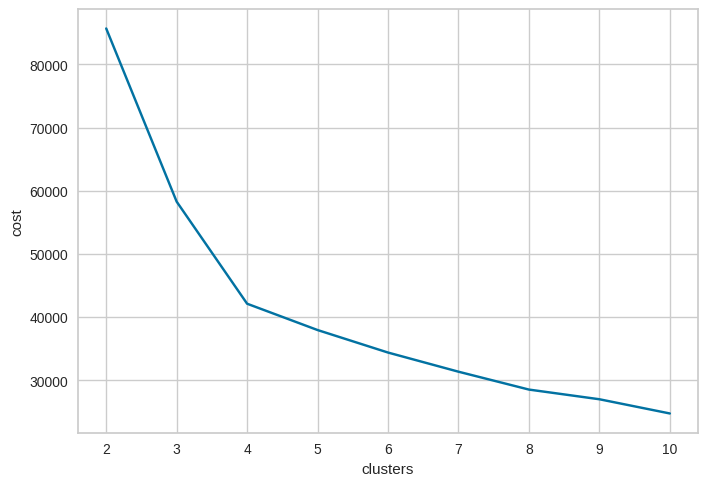

In [ ]:
df_cost = pd.DataFrame()
df_cost['clusters'] = range(2,11)
df_cost['cost'] = cost
sns.lineplot(x='clusters', y= 'cost', data=df_cost)